In [1]:
%matplotlib inline
from netCDF4 import Dataset as ncread
import netCDF4 as nc
import numpy as np
from scipy.io import loadmat
import pandas as pd
import h5py
import math
import pandas as pd
from datetime import datetime
from itertools import product
from cftime import DatetimeNoLeap
import xarray as xr

In [2]:
from preprocess import get_principle_components_and_EOFs
from L_functions import sel_train_data_lead, climat_probab
from train import get_train_test_val, cross_valid_one_out
from post import score, rps, rpss
import os
import visualization

2023-07-09 17:10:46.232293: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-09 17:10:48.081846: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-09 17:10:48.081902: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-09 17:10:55.913552: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams #For changing text properties
import cmocean #A package with beautiful colormaps
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.path as mpath

In [4]:
from datetime import datetime 
from datetime import timedelta
from datetime import date
import time
from eofs.xarray import Eof

In [5]:
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.utils import shuffle
from sklearn.inspection import permutation_importance

In [7]:
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec

## Data set

In [8]:
import pathlib

print('Adjust paths for your own machine')
root_data = '/s2s/mpyrina/Lorentz_Workshop/Data/'

root_results = '/s2s_nobackup/zhengwu/workshop/Results/'

Adjust paths for your own machine


#### target data and climatological/ presistence probabilities
see https://github.com/AI4S2S/Lorentz_s2spy_workshop/blob/main/preprocess_target.ipynb

-target should be center alinged like in the notebook of the link above

-no direct import of file chrips_1981-2021_target_new_left.nc, its corrupted

In [9]:
SYY = 1981   # start year of target data
EYY = 2010   # DUE TO OLR missing values in 2021 !!!
NYRS = EYY-SYY+1

CSYY = SYY # start year for the calculation of climatology
CEYY = EYY

#CSYY = 2000 # start year for the calculation of climatology
#CEYY = 2020 # end year for the calculation of climatology

all_years = list(np.arange(SYY,EYY+1))
#take_OND_years = list(np.arange(SYY,EYY+1))
#take_OND_years = [y for y in take_OND_years if y not in drop_OND_years]
# If model used to predict MAM then:
#drop_MAM_years = [2009,2001,2002,2005,2020]
#drop_OND_years = [2004,2005,2006,2007,2018]

In [10]:
# Calculate the spatial mean of the tp file after applying the spatial mask
file=xr.open_mfdataset(root_data+f'/chrips_precip_1981-2021.nc',combine='by_coords').compute()
tp_series=file.sel(longitude=slice(38,53),latitude=slice(-5,8)).mean(dim=('latitude', 'longitude'))

# Apply rolling mean #time=28
tp_rol = tp_series.rolling(time=15, min_periods=1, center=True).mean().sel(time = slice(str(SYY),str(EYY)))

# Select climatology years + calculate tercile
tp_rol_cl = tp_rol.sel(time = slice(str(CSYY),str(CEYY)))
tp_rol_q1 = tp_rol_cl.groupby(tp_rol_cl.time.dt.dayofyear).quantile(q=0.333,dim='time')
tp_rol_q3 = tp_rol_cl.groupby(tp_rol_cl.time.dt.dayofyear).quantile(q=0.666,dim='time')

# Smoothed percentile threshold
tp_rol_q_sm1 = tp_rol_q1.rolling(dayofyear=31, min_periods=1, center=True).mean()
tp_rol_q_sm3 = tp_rol_q3.rolling(dayofyear=31, min_periods=1, center=True).mean()
#print('values of tercile', tp_rol_q_sm1)

# Tercile index (like Sem, but according to smoothed tercile)
tp1_terc = (tp_rol.groupby(tp_rol.time.dt.dayofyear) <= tp_rol_q_sm1).astype(int).drop('dayofyear').drop('quantile')

tp3_terc_a = (tp_rol.groupby(tp_rol.time.dt.dayofyear) < tp_rol_q_sm3).astype(int).drop('dayofyear').drop('quantile')
tp3_terc_b = (tp_rol.groupby(tp_rol.time.dt.dayofyear) > tp_rol_q_sm1).astype(int).drop('dayofyear').drop('quantile')
tp3_terc = tp3_terc_a * tp3_terc_b

tp4_terc = (tp_rol.groupby(tp_rol.time.dt.dayofyear) >= tp_rol_q_sm3).astype(int).drop('dayofyear').drop('quantile')
#print('target array', tp1_terc, 'counts',np.unique(tp1_terc['precip'], return_counts=True))

# Tercile index (like Sem, but according to smoothed tercile)
tp11_terc = tp1_terc
tp33_terc = xr.where(tp3_terc==1,2,0)
tp44_terc = xr.where(tp4_terc==1,3,0)

# Select daily values to be predicted
sm_sd = 8
em_ed = 10
t1 = xr.concat([tp11_terc.sel(time=slice(f"{yyyy}-10-{sm_sd}",f"{yyyy}-12-{em_ed}")) for yyyy in tp11_terc.time.dt.year.to_index().unique()],"time")
print('target array', t1, 'counts',np.unique(t1['precip'], return_counts=True))
t3 = xr.concat([tp33_terc.sel(time=slice(f"{yyyy}-10-{sm_sd}",f"{yyyy}-12-{em_ed}")) for yyyy in tp33_terc.time.dt.year.to_index().unique()],"time")
print('target array', t3, 'counts',np.unique(t3['precip'], return_counts=True))
t4 = xr.concat([tp44_terc.sel(time=slice(f"{yyyy}-10-{sm_sd}",f"{yyyy}-12-{em_ed}")) for yyyy in tp44_terc.time.dt.year.to_index().unique()],"time")
print('target array', t4, 'counts',np.unique(t4['precip'], return_counts=True))

# Create and save tp target
tp_target = t1 + t3 + t4
print('target array', tp_target, 'counts',np.unique(tp_target['precip'], return_counts=True))

target array <xarray.Dataset>
Dimensions:  (time: 1920)
Coordinates:
  * time     (time) datetime64[ns] 1981-10-08 1981-10-09 ... 2010-12-10
Data variables:
    precip   (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1 1 counts (array([0, 1]), array([1329,  591]))
target array <xarray.Dataset>
Dimensions:  (time: 1920)
Coordinates:
  * time     (time) datetime64[ns] 1981-10-08 1981-10-09 ... 2010-12-10
Data variables:
    precip   (time) int64 0 0 0 0 0 0 0 0 0 2 2 2 2 ... 0 0 0 0 0 0 0 0 0 0 0 0 counts (array([0, 2]), array([1264,  656]))
target array <xarray.Dataset>
Dimensions:  (time: 1920)
Coordinates:
  * time     (time) datetime64[ns] 1981-10-08 1981-10-09 ... 2010-12-10
Data variables:
    precip   (time) int64 3 3 3 3 3 3 3 3 3 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 counts (array([0, 3]), array([1247,  673]))
target array <xarray.Dataset>
Dimensions:  (time: 1920)
Coordinates:
  * time     (time) datetime64[ns] 1981-10-08 1981-10-09 ... 2010-12-10
Data variables:


In [11]:
tp_rol_cl_anom = tp_rol_cl.groupby("time.dayofyear") - tp_rol_cl.groupby("time.dayofyear").mean("time",skipna=True)
tp_anom = xr.concat([tp_rol_cl_anom.sel(time=slice(f"{yyyy}-10-{sm_sd}",f"{yyyy}-12-{em_ed}")) for yyyy in tp11_terc.time.dt.year.to_index().unique()],"time")
tp_anom

<xarray.Dataset>
Dimensions:    (time: 1920)
Coordinates:
  * time       (time) datetime64[ns] 1981-10-08 1981-10-09 ... 2010-12-10
    dayofyear  (time) int64 281 282 283 284 285 286 ... 339 340 341 342 343 344
Data variables:
    precip     (time) float32 0.1622 0.1063 0.09337 ... -0.6619 -0.6312 -0.6131

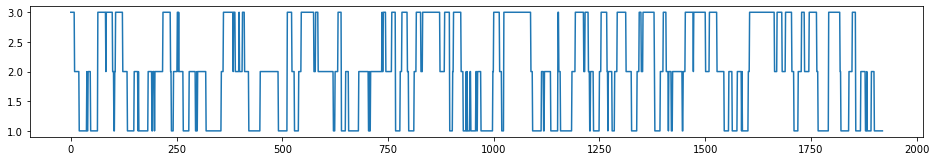

In [12]:
fig, axs = plt.subplots(1, figsize=plt.figaspect(0.15))
plt.plot(tp_target.precip[0:])

<xarray.DataArray 'time' (time: 30)>
array(['1981-10-28T00:00:00.000000000', '1982-10-28T00:00:00.000000000',
       '1983-10-28T00:00:00.000000000', '1984-10-27T00:00:00.000000000',
       '1985-10-28T00:00:00.000000000', '1986-10-28T00:00:00.000000000',
       '1987-10-28T00:00:00.000000000', '1988-10-27T00:00:00.000000000',
       '1989-10-28T00:00:00.000000000', '1990-10-28T00:00:00.000000000',
       '1991-10-28T00:00:00.000000000', '1992-10-27T00:00:00.000000000',
       '1993-10-28T00:00:00.000000000', '1994-10-28T00:00:00.000000000',
       '1995-10-28T00:00:00.000000000', '1996-10-27T00:00:00.000000000',
       '1997-10-28T00:00:00.000000000', '1998-10-28T00:00:00.000000000',
       '1999-10-28T00:00:00.000000000', '2000-10-27T00:00:00.000000000',
       '2001-10-28T00:00:00.000000000', '2002-10-28T00:00:00.000000000',
       '2003-10-28T00:00:00.000000000', '2004-10-27T00:00:00.000000000',
       '2005-10-28T00:00:00.000000000', '2006-10-28T00:00:00.000000000',
       '2007-1

(array([1., 4., 4., 7., 3., 0., 0., 3., 1., 1., 2., 1., 1., 0., 0., 0., 0.,
        1., 0., 1.]),
 array([0.2765902, 0.680053 , 1.0835158, 1.4869787, 1.8904414, 2.2939043,
        2.697367 , 3.1008298, 3.5042925, 3.9077554, 4.3112183, 4.714681 ,
        5.1181436, 5.5216064, 5.9250693, 6.328532 , 6.731995 , 7.135458 ,
        7.5389204, 7.9423833, 8.345846 ], dtype=float32),
 <BarContainer object of 20 artists>)

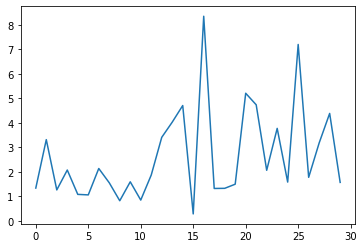

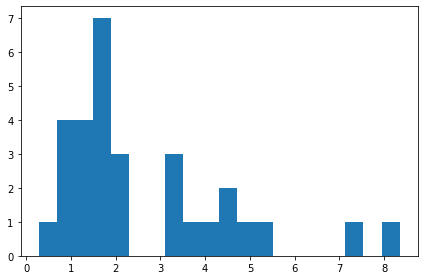

In [12]:
dummy = tp_rol_cl.precip[np.where(tp_rol_cl['time.dayofyear'].values == 301)]
print(dummy.time)
plt.plot(dummy)
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
# We can set the number of bins with the *bins* keyword argument.
axs.hist(dummy, bins=20)

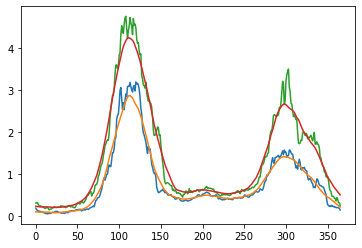

In [13]:
plt.plot(tp_rol_q1['precip'])
plt.plot(tp_rol_q_sm1['precip'])
plt.plot(tp_rol_q3['precip'])
plt.plot(tp_rol_q_sm3['precip'])

In [13]:
# calculate daily climatological probability of getting a category

# Category 1
cat_1 = xr.concat([tp1_terc.sel(time=slice(f"{yyyy}-10-{sm_sd}",f"{yyyy}-12-{em_ed}")) for yyyy in tp1_terc.time.dt.year.to_index().unique()],"time")
index_file,my_var,month,s_days_list,e_days_list = cat_1,'precip',10,[sm_sd,1,1],[31,30,em_ed]
n_years=len(index_file.time.dt.year.to_index().unique())
print('number of years to calculate probability from',n_years)

# Probability excluding test years
clim_pr_cat1, clim_pr_y_cat1 = climat_probab(index_file,my_var,month,s_days_list,e_days_list)
print(clim_pr_cat1.shape,clim_pr_cat1)

# Category 3
cat_3 = xr.concat([tp3_terc.sel(time=slice(f"{yyyy}-10-{sm_sd}",f"{yyyy}-12-{em_ed}")) for yyyy in tp3_terc.time.dt.year.to_index().unique()],"time")
index_file,my_var,month,s_days_list,e_days_list = cat_3,'precip',10,[sm_sd,1,1],[31,30,em_ed]
n_years=len(index_file.time.dt.year.to_index().unique())
print('number of years to calculate probability from',n_years)

# Probability excluding test years
clim_pr_cat3, clim_pr_y_cat3 = climat_probab(index_file,my_var,month,s_days_list,e_days_list)
print(clim_pr_cat3.shape,clim_pr_cat3)

# Category 4
cat_4 = xr.concat([tp4_terc.sel(time=slice(f"{yyyy}-10-{sm_sd}",f"{yyyy}-12-{em_ed}")) for yyyy in tp4_terc.time.dt.year.to_index().unique()],"time")
index_file,my_var,month,s_days_list,e_days_list = cat_4,'precip',10,[sm_sd,1,1],[31,30,em_ed]
n_years=len(index_file.time.dt.year.to_index().unique())
print('number of years to calculate probability from',n_years)

# Probability excluding test years
clim_pr_cat4, clim_pr_y_cat4 = climat_probab(index_file,my_var,month,s_days_list,e_days_list)
print(clim_pr_cat4.shape,clim_pr_cat4)

number of years to calculate probability from 30
number of days per year (64,)
(64,) [0.33333333 0.33333333 0.2        0.23333333 0.26666667 0.26666667
 0.3        0.23333333 0.23333333 0.26666667 0.3        0.3
 0.3        0.26666667 0.26666667 0.23333333 0.23333333 0.3
 0.3        0.3        0.33333333 0.33333333 0.3        0.33333333
 0.3        0.26666667 0.23333333 0.23333333 0.26666667 0.3
 0.33333333 0.4        0.36666667 0.36666667 0.33333333 0.33333333
 0.3        0.33333333 0.33333333 0.4        0.33333333 0.23333333
 0.23333333 0.3        0.26666667 0.3        0.4        0.46666667
 0.4        0.36666667 0.4        0.33333333 0.36666667 0.36666667
 0.4        0.33333333 0.3        0.3        0.3        0.3
 0.3        0.3        0.26666667 0.26666667]
number of years to calculate probability from 30
number of days per year (64,)
(64,) [0.33333333 0.26666667 0.43333333 0.36666667 0.33333333 0.36666667
 0.3        0.4        0.43333333 0.4        0.36666667 0.4
 0.36666667 0.4

### Predictors

In [14]:
# read RMM index
# data is from Cheng Zhang, ERA-interim daily data from 1981.1.1-2019.8.31 
DIR = '/net/cfc/s2s/zhengwu/Datasets/MJO/'
datafn = DIR+'rmm_ERA-Interim.nc'
rmm = xr.open_mfdataset(datafn,combine='by_coords').compute()

date_start = datetime.strftime(datetime(year=1960,month=1,day=1), "%Y.%m.%d")
time_date = []
for ii in range(len(rmm.time)):
    time_date.append(datetime.strftime(datetime.strptime(date_start, "%Y.%m.%d") + timedelta(days=int(rmm.time.values[ii])),"%Y.%m.%d"))
    
rmm = rmm.assign_coords(time=time_date)
rmm = rmm.assign_coords(time=pd.DatetimeIndex(rmm.time))
rmm = rmm.sel(time = slice(str(SYY),str(EYY))).rolling(time=7, center=True).mean(skipna=True)
rmm

<xarray.Dataset>
Dimensions:    (time: 10957)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2010-12-31
Data variables:
    amplitude  (time) float32 nan nan nan 0.5651 0.4607 ... 0.7636 nan nan nan
    phase      (time) float32 nan nan nan 3.286 3.571 ... 5.571 nan nan nan
    RMM1       (time) float32 nan nan nan 0.1393 0.2246 ... 0.4809 nan nan nan
    RMM2       (time) float32 nan nan nan -0.3833 -0.2881 ... 0.5447 nan nan nan

In [15]:
root_data = '/s2s_nobackup/zhengwu/workshop/'
file_vars = ['sst', 'sst', 'ERA5_t2m', 'gleam_E']
header_vars = ['sst', 'sst', 't2m', 'E']

# select regions for the individual predictor
lon_slices = [[-170,-120],[50,110],[38,55],[38,55]]
lat_slices = [[6,-6],[10,-10],[10,-10],[-10,10]]
for file_var, header_var, lon_slice, lat_slice in zip (file_vars, header_vars, lon_slices, lat_slices):

    if file_var == 'gleam_E':
        file = xr.open_dataset(root_data+file_var+'_1980-2021_daily_1.0deg_65S-65N.nc')
    else:
        file = xr.open_dataset(root_data+file_var+'_1959-2021_1_12_daily_2.0deg.nc')

    if "longitude" in file.coords:
        file = file.rename({"longitude": "lon","latitude": "lat"})

    assert "lat" in file.coords
    assert "lon" in file.coords
    #lon = file.coords['lon'].values
    #lat = file.coords['lat'].values

    # select region
    var_dim = file.sel(lon=slice(lon_slice[0],lon_slice[1]),lat=slice(lat_slice[0],lat_slice[1]))
    lon = var_dim.lon.values
    lat = var_dim.lat.values
    
    var_series = var_dim.sel(time=var_dim.time.dt.year.isin([np.arange(SYY,EYY+1)])).rolling(time=15, center=True).mean(skipna=True)
    var_series = var_series.sel(time=var_series.time.dt.year.isin(all_years))

    # remove climatology
    var_anom_series = var_series.groupby("time.dayofyear") - var_series.groupby("time.dayofyear").mean("time",skipna=True)
    print(var_anom_series)
    
    # ENSO indices
    if file_var == 'ERA5_t2m':
        t2m = var_anom_series.mean(dim=('lat', 'lon'),skipna=True)
        print('t2m',t2m)
    elif file_var == 'gleam_E':
        evap = var_anom_series.mean(dim=('lat', 'lon'),skipna=True)
        print('evap',evap)
    else:
        if lat_slice == [6, -6]:
            enso = var_anom_series.mean(dim=('lat', 'lon'),skipna=True)
            print('enso',enso)
        else:
            iod_1 = var_anom_series.sel(lon=slice(50,70),lat=slice(10,-10)).mean(dim=('lat', 'lon'),skipna=True)
            iod_2 = var_anom_series.sel(lon=slice(90,110),lat=slice(0,-10)).mean(dim=('lat', 'lon'),skipna=True)
            iod = iod_1-iod_2
            print('iod',iod)

<xarray.Dataset>
Dimensions:    (time: 10957, lon: 26, lat: 7)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2010-12-31
  * lon        (lon) float32 -170.0 -168.0 -166.0 ... -124.0 -122.0 -120.0
  * lat        (lat) float32 6.0 4.0 2.0 0.0 -2.0 -4.0 -6.0
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
Data variables:
    sst        (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
enso <xarray.Dataset>
Dimensions:    (time: 10957)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2010-12-31
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
Data variables:
    sst        (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan
<xarray.Dataset>
Dimensions:    (time: 10957, lon: 31, lat: 11)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2010-12-31
  * lon        (lon) float32 50.0 52.0 54.0 56.0 ... 104.0 106.0 108.0 110.0

In [16]:
time_dim = rmm.coords['time']
enso = xr.Dataset({"Index": (("time"), enso.sst.values),}, 
                  coords={'time': time_dim})
enso = enso.assign_coords(feature=np.arange(1))
iod = xr.Dataset({"Index": (("time"), iod.sst.values),}, 
                  coords={'time': time_dim})
iod = iod.assign_coords(feature=(np.arange(1)+1))
rmm1 = xr.Dataset({"Index": (("time"), rmm.RMM1.values),}, 
                  coords={'time': time_dim})
rmm1 = rmm1.assign_coords(feature=(np.arange(1)+2))
rmm2 = xr.Dataset({"Index": (("time"), rmm.RMM2.values),}, 
                  coords={'time': time_dim})
rmm2 = rmm2.assign_coords(feature=(np.arange(1)+3))
t2m = xr.Dataset({"Index": (("time"), t2m.t2m.values),}, 
                  coords={'time': time_dim})
t2m = t2m.assign_coords(feature=(np.arange(1)+4))
evap = xr.Dataset({"Index": (("time"), evap.E.values),}, 
                  coords={'time': time_dim})
evap = evap.assign_coords(feature=(np.arange(1)+5))

In [15]:
path = root_results+'index_ENSO.nc'
enso.to_netcdf(path)
path = root_results+'index_IOD.nc'
iod.to_netcdf(path)
path = root_results+'index_RMM1.nc'
rmm1.to_netcdf(path)
path = root_results+'index_RMM2.nc'
rmm2.to_netcdf(path)
path = root_results+'index_T2M.nc'
rmm2.to_netcdf(path)
path = root_results+'index_E.nc'
rmm2.to_netcdf(path)

In [24]:
# file = open(root_data+'rMII_index_latest.txt', 'r')
# Lines = file.readlines()

# count = 0
# dates = []
# years = []
# months = []
# days = []
# rmm1 = []
# rmm2 = []
# phase = []
# # Strips the newline character
# for line in Lines:
#     count += 1
#     #print("Line{}: {}".format(count, line.strip()))
#     tmp = line.split()
#     years.append(tmp[0])
#     months.append(tmp[1])
#     days.append(tmp[2])
#     rmm1.append(float(tmp[3]))
#     rmm2.append(float(tmp[4]))
#     phase.append(tmp[5])
#     dates.append(datetime.strftime(datetime(year=int(tmp[0]),month=int(tmp[1]),day=int(tmp[2])),"%Y-%m-%d"))
# file = pd.DataFrame(list(zip(rmm1, rmm2)), columns =['RMM1', 'RMM2'])
# nrmm = np.arange(2)
# mjo = xr.DataArray(file, coords={'time': dates, 'feature': nrmm}, dims=["time","feature"])
# print(mjo)

# mjo_rol = mjo.rolling(time=7, center=True, min_periods=1).mean(skipna=True)
# mjo_sel = xr.concat([mjo_rol.sel(time=slice(f"{yyyy}-01-01",f"{yyyy}-12-31")) for yyyy in all_years],"time")
# print(mjo_sel)

In [19]:
# tmp = []
# tmp1 = enso.assign_coords(feature=range(1))
# tmp2 = iod.assign_coords(feature=range(1))
# tmp.append(tmp1)
# tmp.append(tmp2)
# tmp = xr.concat(tmp,"feature")
# tmp3 = tmp.transpose()
# del tmp
# tmp = tmp3.sst.values
# print(tmp.shape)
# del tmp1
# tmp1 = np.concatenate((tmp,rmm.RMM1),axis=1)
# tmp1 = np.concatenate((tmp,rmm.RMM1),axis=1)
# print(tmp1.shape)
# time_dim = enso.coords['time']
# features = np.arange(4)
# predictors = xr.DataArray(tmp1, coords={'time': time_dim, 'feature': features}, dims=["time","feature"])
# print(predictors)

In [112]:
pc_xr = xr.concat([enso,iod,rmm1,rmm2,t2m,evap],"feature")

# Run the function
s_target_date='08-10-1981'
e_target_date='10-12-2010' # end of year - approximatelly 14 days

# if eof is 15 days centered then rw_1=7 # If eof is 15 days NOT-centered then rw_1=15
rw_1 = 7 # half eof smoothing
lead_time = 14 # days until valid_time starts
rw = 15 # data full smoothing value (gets half in function), because the data are centered, otherwise set to 0

# LSTM timestep
ntimestep = 60 # lags to consider for the lstm
target_len = len(tp_target) # len(tp_target)

drop_OND_years = [1970, 1971, 1972, 1973, 1974] # fake years to drop because we dont want to do any drop currently
predictor_array=sel_train_data_lead(pc_xr, target_len, s_target_date, e_target_date,
                rw_1, lead_time, rw, ntimestep, drop_OND_years)

starting
start target date 8 10 1981
end target 10 12 2010
1981.10.08 1981.07.13 1981.09.10 0
1981.10.09 1981.07.14 1981.09.11 1
1981.10.10 1981.07.15 1981.09.12 1
1981.10.11 1981.07.16 1981.09.13 1
1981.10.12 1981.07.17 1981.09.14 1
1981.10.13 1981.07.18 1981.09.15 1
1981.10.14 1981.07.19 1981.09.16 1
1981.10.15 1981.07.20 1981.09.17 1
1981.10.16 1981.07.21 1981.09.18 1
1981.10.17 1981.07.22 1981.09.19 1
1981.10.18 1981.07.23 1981.09.20 1
1981.10.19 1981.07.24 1981.09.21 1
1981.10.20 1981.07.25 1981.09.22 1
1981.10.21 1981.07.26 1981.09.23 1
1981.10.22 1981.07.27 1981.09.24 1
1981.10.23 1981.07.28 1981.09.25 1
1981.10.24 1981.07.29 1981.09.26 1
1981.10.25 1981.07.30 1981.09.27 1
1981.10.26 1981.07.31 1981.09.28 1
1981.10.27 1981.08.01 1981.09.29 1
1981.10.28 1981.08.02 1981.09.30 1
1981.10.29 1981.08.03 1981.10.01 1
1981.10.30 1981.08.04 1981.10.02 1
1981.10.31 1981.08.05 1981.10.03 1
1981.11.01 1981.08.06 1981.10.04 1
1981.11.02 1981.08.07 1981.10.05 1
1981.11.03 1981.08.08 1981.10.0

1985.11.28 1985.09.02 1985.10.31 1
1985.11.29 1985.09.03 1985.11.01 1
1985.11.30 1985.09.04 1985.11.02 1
1985.12.01 1985.09.05 1985.11.03 1
1985.12.02 1985.09.06 1985.11.04 1
1985.12.03 1985.09.07 1985.11.05 1
1985.12.04 1985.09.08 1985.11.06 1
1985.12.05 1985.09.09 1985.11.07 1
1985.12.06 1985.09.10 1985.11.08 1
1985.12.07 1985.09.11 1985.11.09 1
1985.12.08 1985.09.12 1985.11.10 1
1985.12.09 1985.09.13 1985.11.11 1
1985.12.10 1985.09.14 1985.11.12 1
1986.10.08 1986.07.13 1986.09.10 0
1986.10.09 1986.07.14 1986.09.11 1
1986.10.10 1986.07.15 1986.09.12 1
1986.10.11 1986.07.16 1986.09.13 1
1986.10.12 1986.07.17 1986.09.14 1
1986.10.13 1986.07.18 1986.09.15 1
1986.10.14 1986.07.19 1986.09.16 1
1986.10.15 1986.07.20 1986.09.17 1
1986.10.16 1986.07.21 1986.09.18 1
1986.10.17 1986.07.22 1986.09.19 1
1986.10.18 1986.07.23 1986.09.20 1
1986.10.19 1986.07.24 1986.09.21 1
1986.10.20 1986.07.25 1986.09.22 1
1986.10.21 1986.07.26 1986.09.23 1
1986.10.22 1986.07.27 1986.09.24 1
1986.10.23 1986.07.2

1990.11.08 1990.08.13 1990.10.11 1
1990.11.09 1990.08.14 1990.10.12 1
1990.11.10 1990.08.15 1990.10.13 1
1990.11.11 1990.08.16 1990.10.14 1
1990.11.12 1990.08.17 1990.10.15 1
1990.11.13 1990.08.18 1990.10.16 1
1990.11.14 1990.08.19 1990.10.17 1
1990.11.15 1990.08.20 1990.10.18 1
1990.11.16 1990.08.21 1990.10.19 1
1990.11.17 1990.08.22 1990.10.20 1
1990.11.18 1990.08.23 1990.10.21 1
1990.11.19 1990.08.24 1990.10.22 1
1990.11.20 1990.08.25 1990.10.23 1
1990.11.21 1990.08.26 1990.10.24 1
1990.11.22 1990.08.27 1990.10.25 1
1990.11.23 1990.08.28 1990.10.26 1
1990.11.24 1990.08.29 1990.10.27 1
1990.11.25 1990.08.30 1990.10.28 1
1990.11.26 1990.08.31 1990.10.29 1
1990.11.27 1990.09.01 1990.10.30 1
1990.11.28 1990.09.02 1990.10.31 1
1990.11.29 1990.09.03 1990.11.01 1
1990.11.30 1990.09.04 1990.11.02 1
1990.12.01 1990.09.05 1990.11.03 1
1990.12.02 1990.09.06 1990.11.04 1
1990.12.03 1990.09.07 1990.11.05 1
1990.12.04 1990.09.08 1990.11.06 1
1990.12.05 1990.09.09 1990.11.07 1
1990.12.06 1990.09.1

1995.10.31 1995.08.05 1995.10.03 1
1995.11.01 1995.08.06 1995.10.04 1
1995.11.02 1995.08.07 1995.10.05 1
1995.11.03 1995.08.08 1995.10.06 1
1995.11.04 1995.08.09 1995.10.07 1
1995.11.05 1995.08.10 1995.10.08 1
1995.11.06 1995.08.11 1995.10.09 1
1995.11.07 1995.08.12 1995.10.10 1
1995.11.08 1995.08.13 1995.10.11 1
1995.11.09 1995.08.14 1995.10.12 1
1995.11.10 1995.08.15 1995.10.13 1
1995.11.11 1995.08.16 1995.10.14 1
1995.11.12 1995.08.17 1995.10.15 1
1995.11.13 1995.08.18 1995.10.16 1
1995.11.14 1995.08.19 1995.10.17 1
1995.11.15 1995.08.20 1995.10.18 1
1995.11.16 1995.08.21 1995.10.19 1
1995.11.17 1995.08.22 1995.10.20 1
1995.11.18 1995.08.23 1995.10.21 1
1995.11.19 1995.08.24 1995.10.22 1
1995.11.20 1995.08.25 1995.10.23 1
1995.11.21 1995.08.26 1995.10.24 1
1995.11.22 1995.08.27 1995.10.25 1
1995.11.23 1995.08.28 1995.10.26 1
1995.11.24 1995.08.29 1995.10.27 1
1995.11.25 1995.08.30 1995.10.28 1
1995.11.26 1995.08.31 1995.10.29 1
1995.11.27 1995.09.01 1995.10.30 1
1995.11.28 1995.09.0

1999.12.09 1999.09.13 1999.11.11 1
1999.12.10 1999.09.14 1999.11.12 1
2000.10.08 2000.07.13 2000.09.10 0
2000.10.09 2000.07.14 2000.09.11 1
2000.10.10 2000.07.15 2000.09.12 1
2000.10.11 2000.07.16 2000.09.13 1
2000.10.12 2000.07.17 2000.09.14 1
2000.10.13 2000.07.18 2000.09.15 1
2000.10.14 2000.07.19 2000.09.16 1
2000.10.15 2000.07.20 2000.09.17 1
2000.10.16 2000.07.21 2000.09.18 1
2000.10.17 2000.07.22 2000.09.19 1
2000.10.18 2000.07.23 2000.09.20 1
2000.10.19 2000.07.24 2000.09.21 1
2000.10.20 2000.07.25 2000.09.22 1
2000.10.21 2000.07.26 2000.09.23 1
2000.10.22 2000.07.27 2000.09.24 1
2000.10.23 2000.07.28 2000.09.25 1
2000.10.24 2000.07.29 2000.09.26 1
2000.10.25 2000.07.30 2000.09.27 1
2000.10.26 2000.07.31 2000.09.28 1
2000.10.27 2000.08.01 2000.09.29 1
2000.10.28 2000.08.02 2000.09.30 1
2000.10.29 2000.08.03 2000.10.01 1
2000.10.30 2000.08.04 2000.10.02 1
2000.10.31 2000.08.05 2000.10.03 1
2000.11.01 2000.08.06 2000.10.04 1
2000.11.02 2000.08.07 2000.10.05 1
2000.11.03 2000.08.0

2004.11.24 2004.08.29 2004.10.27 1
2004.11.25 2004.08.30 2004.10.28 1
2004.11.26 2004.08.31 2004.10.29 1
2004.11.27 2004.09.01 2004.10.30 1
2004.11.28 2004.09.02 2004.10.31 1
2004.11.29 2004.09.03 2004.11.01 1
2004.11.30 2004.09.04 2004.11.02 1
2004.12.01 2004.09.05 2004.11.03 1
2004.12.02 2004.09.06 2004.11.04 1
2004.12.03 2004.09.07 2004.11.05 1
2004.12.04 2004.09.08 2004.11.06 1
2004.12.05 2004.09.09 2004.11.07 1
2004.12.06 2004.09.10 2004.11.08 1
2004.12.07 2004.09.11 2004.11.09 1
2004.12.08 2004.09.12 2004.11.10 1
2004.12.09 2004.09.13 2004.11.11 1
2004.12.10 2004.09.14 2004.11.12 1
2005.10.08 2005.07.13 2005.09.10 0
2005.10.09 2005.07.14 2005.09.11 1
2005.10.10 2005.07.15 2005.09.12 1
2005.10.11 2005.07.16 2005.09.13 1
2005.10.12 2005.07.17 2005.09.14 1
2005.10.13 2005.07.18 2005.09.15 1
2005.10.14 2005.07.19 2005.09.16 1
2005.10.15 2005.07.20 2005.09.17 1
2005.10.16 2005.07.21 2005.09.18 1
2005.10.17 2005.07.22 2005.09.19 1
2005.10.18 2005.07.23 2005.09.20 1
2005.10.19 2005.07.2

2009.11.03 2009.08.08 2009.10.06 1
2009.11.04 2009.08.09 2009.10.07 1
2009.11.05 2009.08.10 2009.10.08 1
2009.11.06 2009.08.11 2009.10.09 1
2009.11.07 2009.08.12 2009.10.10 1
2009.11.08 2009.08.13 2009.10.11 1
2009.11.09 2009.08.14 2009.10.12 1
2009.11.10 2009.08.15 2009.10.13 1
2009.11.11 2009.08.16 2009.10.14 1
2009.11.12 2009.08.17 2009.10.15 1
2009.11.13 2009.08.18 2009.10.16 1
2009.11.14 2009.08.19 2009.10.17 1
2009.11.15 2009.08.20 2009.10.18 1
2009.11.16 2009.08.21 2009.10.19 1
2009.11.17 2009.08.22 2009.10.20 1
2009.11.18 2009.08.23 2009.10.21 1
2009.11.19 2009.08.24 2009.10.22 1
2009.11.20 2009.08.25 2009.10.23 1
2009.11.21 2009.08.26 2009.10.24 1
2009.11.22 2009.08.27 2009.10.25 1
2009.11.23 2009.08.28 2009.10.26 1
2009.11.24 2009.08.29 2009.10.27 1
2009.11.25 2009.08.30 2009.10.28 1
2009.11.26 2009.08.31 2009.10.29 1
2009.11.27 2009.09.01 2009.10.30 1
2009.11.28 2009.09.02 2009.10.31 1
2009.11.29 2009.09.03 2009.11.01 1
2009.11.30 2009.09.04 2009.11.02 1
2009.12.01 2009.09.0

In [113]:
predictor_array

<xarray.Dataset>
Dimensions:  (time: 1920, feature: 6, lag: 60)
Coordinates:
  * lag      (lag) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
  * feature  (feature) int64 0 1 2 3 4 5
  * time     (time) datetime64[ns] 1981-10-08 1981-10-09 ... 2010-12-10
Data variables:
    Index    (time, feature, lag) float32 -0.3146 -0.3216 ... -0.4997 -0.5018

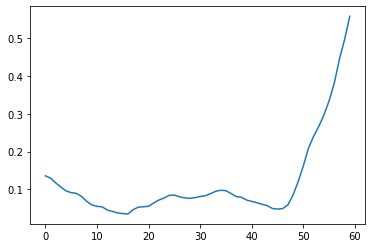

In [97]:
plt.plot(predictor_array.Index[100,5,:])

In [20]:
pc_xr_sel = xr.concat([pc_xr.sel(time=slice(f"{yyyy}-10-{sm_sd}",f"{yyyy}-12-{em_ed}")) for yyyy in tp11_terc.time.dt.year.to_index().unique()],"time")
pc_xr_sel

<xarray.Dataset>
Dimensions:  (feature: 6, time: 1920)
Coordinates:
  * time     (time) datetime64[ns] 1981-10-08 1981-10-09 ... 2010-12-10
  * feature  (feature) int64 0 1 2 3 4 5
Data variables:
    Index    (feature, time) float32 -0.4799 -0.4852 -0.4902 ... -0.6017 -0.596

In [86]:
from scipy.stats.stats import pearsonr
pc_xr_corr = np.ndarray((7,7))
pc_xr_pval = np.ndarray((6,6))
for ii in range(7):
    if ii < 6:
        dat1 = pc_xr_sel.Index[ii,:]
    if ii == 6:
        dat1 = tp_anom.precip[:]
    for jj in range(7):
        if jj < 6:
            dat2 = pc_xr_sel.Index[jj,:]
        if jj == 6:
            dat2 = tp_anom.precip[:]
        #pc_xr_corr[ii,jj] = np.corrcoef(dat1,dat2)[0,1]
        pc_xr_corr[ii,jj] = round(pearsonr(dat1, dat2)[0],2)
        print(pearsonr(dat1, dat2))

(0.9999999999999998, 0.0)
(0.6591583315208596, 1.0755464972513812e-239)
(-0.4258415548249008, 1.9769545941038392e-85)
(-0.4816426065504341, 4.461297424701924e-112)
(0.06949372703437452, 0.0023131975310272355)
(0.5358031023854866, 3.9275291968165692e-143)
(0.47023528130885794, 3.213350703863899e-106)
(0.6591583315208596, 1.0755464972513812e-239)
(1.0, 0.0)
(-0.42477728756848, 5.71981707807475e-85)
(-0.32397134271364936, 3.6825148986473964e-48)
(0.07628638345400632, 0.0008216377818101097)
(0.661691133719448, 3.6206396242101785e-242)
(0.6156986772718859, 9.74199111435493e-201)
(-0.4258415548249008, 1.9769545941038392e-85)
(-0.42477728756848, 5.71981707807475e-85)
(0.9999999999999997, 0.0)
(0.18566745185301448, 2.371061833487173e-16)
(0.1366212221982893, 1.846703188210949e-09)
(-0.3238110067314348, 4.117986241569516e-48)
(-0.4241906566017373, 1.0256347611501523e-84)
(-0.4816426065504341, 4.461297424701924e-112)
(-0.32397134271364936, 3.6825148986473964e-48)
(0.18566745185301448, 2.37106183

/tmp/ipykernel_19293/3821366655.py:1: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [93]:
lags = [2,4,6,8,10,15,20,25,30,35,40]
pc_xr_lagcorr = np.ndarray((6,len(lags)))
for ii in range(6):
    dummy = pc_xr_sel.Index[ii,:]
    kk = 0
    for jj in list(lags):
        dat1 = dummy[0:len(dummy)-jj]
        dat2 = dummy[jj:]
        pc_xr_lagcorr[ii,kk] = round(pearsonr(dat1, dat2)[0],2)
        kk = kk+1

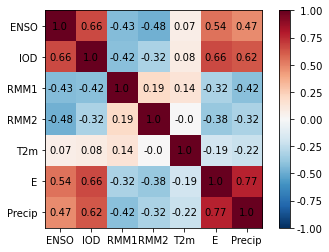

In [92]:
fig, ax = plt.subplots()
im = ax.imshow(pc_xr_corr,cmap='RdBu_r')
im.set_clim(-1, 1)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1, 2, 3, 4, 5, 6), ticklabels=('ENSO', 'IOD', 'RMM1', 'RMM2', 'T2m', 'E', 'Precip'))
ax.yaxis.set(ticks=(0, 1, 2, 3, 4, 5, 6), ticklabels=('ENSO', 'IOD', 'RMM1', 'RMM2', 'T2m', 'E', 'Precip'))
ax.set_ylim(6.5, -0.5)
for i in range(7):
    for j in range(7):
        ax.text(j, i, pc_xr_corr[i, j], ha='center', va='center',
                color='k')
cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
plt.show()
fig.savefig('indices_precip_corr.png')

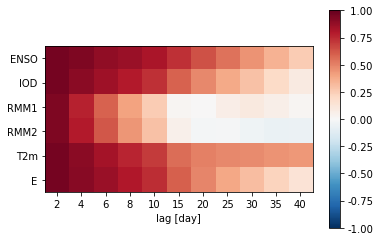

In [96]:
fig, ax = plt.subplots()
im = ax.imshow(pc_xr_lagcorr,cmap='RdBu_r')
im.set_clim(-1, 1)
ax.grid(False)
ax.xaxis.set(ticks=np.arange(len(lags)), ticklabels=['2','4','6','8','10','15','20','25','30','35','40'])
ax.yaxis.set(ticks=(0, 1, 2, 3, 4, 5), ticklabels=('ENSO', 'IOD', 'RMM1', 'RMM2', 'T2m', 'E'))
ax.set_ylim(5.5, -0.5)
ax.set_xlabel('lag [day]')
# for i in range(6):
#     for j in range(len(lags)):
#         ax.text(j, i, pc_xr_lagcorr[i, j], ha='center', va='center',
#                 color='r')
cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
plt.show()
fig.savefig('indices_lagcorr.png')

### logistic regression

In [19]:
# Logistic regression with cross-entropy loss
def build_logistic(nfeature, **kwargs):
    
    out_neurons = kwargs.get('out_neurons', 2)
    regval = kwargs.get('regval', 0.2)
    
    initializer = tf.keras.initializers.HeNormal()
    
    input_tensor = Input(shape=(nfeature,))
    output_tensor = layers.Dense(out_neurons, kernel_regularizer=regularizers.l1(regval), kernel_initializer=initializer, activation='softmax')(input_tensor)
    
    model = Model(input_tensor, output_tensor)
    model.summary()                        
    return model

In [20]:
def train_model(model, train_X, train_y, val_X, val_y, lr, callbacks_path, epochs, batch_size, class_weight):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    decay_rate = lr / epochs
    momentum = 0.9
    #opt = tf.keras.optimizers.legacy.SGD(learning_rate=lr, decay=decay_rate, momentum=momentum, nesterov=True)
    #opt = tf.keras.optimizers.RMSprop(learning_rate=lr)
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
    callbacks_list = [
        #keras.callbacks.EarlyStopping(
        #    monitor='val_loss',
        #    patience=20,
        #),
        keras.callbacks.ModelCheckpoint(
            filepath=callbacks_path,
            monitor='val_accuracy',   #save_weights_only=True, save_best_only=True,
        )
    ]
    history = model.fit(
        train_X, train_y,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(val_X, val_y),
        #callbacks=callbacks_list,
        verbose=True,
        shuffle=True,
        class_weight=class_weight
    )
    return history

In [21]:
def cross_valid_n_out(X_all, y_all, all_year, **kwargs):
    val_year = kwargs.get('val_year', [[2004,2005,2006,2007,2018]])
    val_X = X_all.sel(time = X_all.time.dt.year.isin([val_year]))   # if test year has not been defined in the main module
    val_y = y_all.sel(time = y_all.time.dt.year.isin([val_year]))
    print('validation years',val_year)
    train_year = set(all_year) - set(val_year)
    print('train years',train_year)
    train_X = X_all.sel(time = X_all.time.dt.year.isin([list(train_year)]))
    train_y = y_all.sel(time = y_all.time.dt.year.isin([list(train_year)]))
    return train_X, train_y, val_X, val_y

In [22]:
#Create a class weight dictionary to help if the classes are unbalanced
def class_weight_creator(Y):
    class_dict = {}
    weights = np.max(np.sum(Y, axis=0)) / np.sum(Y, axis=0)
    for i in range( Y.shape[-1] ):
        class_dict[i] = weights[i]
        
    return class_dict

In [114]:
n_cat=3
dummy = predictor_array.Index
#X_all = dummy.sel(lag=slice(40,59)).mean(dim='lag',skipna=True)
X_all = dummy.sel(lag=slice(20,59))
y_all = tp_target['precip']
time_dim = tp_target.coords['time']
nclass = np.arange(n_cat)
dummy = keras.utils.to_categorical(tp_target['precip']-1)
y_all_2d = xr.DataArray(dummy, coords={'time': time_dim, 'category': nclass}, dims=["time","category"])

In [115]:
nlen = 40

In [116]:
X_all_new = xr.DataArray(X_all.values.reshape(1920,6*nlen), coords={'time': time_dim, 'feature': np.arange(6*nlen)}, dims=["time","feature"])

In [117]:
X_all_new

<xarray.DataArray (time: 1920, feature: 240)>
array([[-0.3212728 , -0.366523  , -0.41395837, ...,  0.13190036,
         0.1308144 ,  0.12520641],
       [-0.366523  , -0.41395837, -0.46152252, ...,  0.1308144 ,
         0.12520641,  0.11758745],
       [-0.41395837, -0.46152252, -0.50647944, ...,  0.12520641,
         0.11758745,  0.11415125],
       ...,
       [-1.4852294 , -1.5044475 , -1.5249382 , ..., -0.4805436 ,
        -0.48886877, -0.49664137],
       [-1.5044475 , -1.5249382 , -1.5429955 , ..., -0.48886877,
        -0.49664137, -0.49967936],
       [-1.5249382 , -1.5429955 , -1.5607444 , ..., -0.49664137,
        -0.49967936, -0.5017516 ]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1981-10-08 1981-10-09 ... 2010-12-10
  * feature  (feature) int64 0 1 2 3 4 5 6 7 ... 232 233 234 235 236 237 238 239

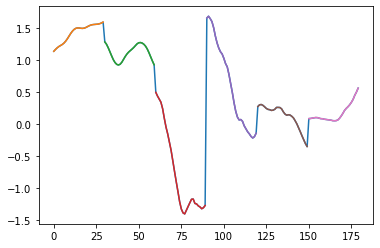

In [121]:
plt.plot(X_all_new[100,:])
plt.plot(np.arange(30),X_all[100,0,:])
plt.plot(np.arange(30)+30,X_all[100,1,:])
plt.plot(np.arange(30)+30*2,X_all[100,2,:])
plt.plot(np.arange(30)+30*3,X_all[100,3,:])
plt.plot(np.arange(30)+30*4,X_all[100,4,:])
plt.plot(np.arange(30)+30*5,X_all[100,5,:])

In [118]:
nbins = 10
train_loss_lr, train_acc_lr = [],[]
valid_loss_lr, valid_acc_lr = [],[]
acc_tr_lr, f1_tr_lr, prec_tr_lr, rec_tr_lr = [],[],[],[]
bss_tr1_lr, calib_y_tr1_lr, calib_x_tr1_lr = [],[],[]
bss_tr2_lr, calib_y_tr2_lr, calib_x_tr2_lr = [],[],[]
bss_tr3_lr, calib_y_tr3_lr, calib_x_tr3_lr = [],[],[]
acc_va_lr, f1_va_lr, prec_va_lr, rec_va_lr = [],[],[],[]
bss_va1_lr, calib_y_va1_lr, calib_x_va1_lr = [],[],[]
bss_va2_lr, calib_y_va2_lr, calib_x_va2_lr = [],[],[]
bss_va3_lr, calib_y_va3_lr, calib_x_va3_lr = [],[],[]
acc_te_lr, f1_te_lr, prec_te_lr, rec_te_lr = [],[],[],[]
bss_te1_lr, calib_y_te1_lr, calib_x_te1_lr = [],[],[]
bss_te2_lr, calib_y_te2_lr, calib_x_te2_lr = [],[],[]
bss_te3_lr, calib_y_te3_lr, calib_x_te3_lr = [],[],[]
rpss_tr_lr, rpss_va_lr, rpss_te_lr = [],[],[]
coef_lr = []
per_imp_lr, per_imp_idx_lr = [],[]
for ii in range(NYRS-1):
    print("********", ii)
    val_year = [SYY+ii,SYY+ii+1]
    X_train, Y_train, X_val, Y_val = cross_valid_n_out(X_all_new, y_all, all_years, val_year=val_year)
    Y_train_2d = keras.utils.to_categorical(Y_train-1)
    Y_val_2d = keras.utils.to_categorical(Y_val-1)
    lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, penalty='l2', C=0.2)
    lr_model.fit(X_train,Y_train)
    coef_lr.append(lr_model.coef_)
#     sfs = SFS(lr_model, 
#               n_features_to_select=10, 
#               direction='forward', 
#               scoring='accuracy',
#               cv=10,
#               n_jobs=-1)
#     sfs = sfs.fit(X_train_tmp, Y_train)
#     X_train = sfs.transform(X_train_tmp)
#     X_val = sfs.transform(X_val_tmp)
#     lr_model.fit(X_train,Y_train)
    
    # evaluation training
    yprob = lr_model.predict_proba(X_train)
    ypred = lr_model.predict(X_train)
    y_prob_ref = clim_pr_y_cat1[0:len(Y_train)]*0+0.33
    y_prob_ref_1 = np.repeat(np.array([[0.33,0.33,0.33]]),Y_train_2d.shape[0],axis=0)
    recall, precision, f1, acc, bs, bss, calib_y, calib_x = score(Y_train, Y_train_2d[:,0], ypred, 
                                                    yprob[:,0], nbins, y_prob_ref)
    acc_tr_lr.append(acc)
    f1_tr_lr.append(f1)
    prec_tr_lr.append(precision)
    rec_tr_lr.append(recall)
    calib_y_tr1_lr.append(calib_y)
    calib_x_tr1_lr.append(calib_x)
    bss_tr1_lr.append(bss)
    
    rpssv = rpss(Y_train_2d, yprob, y_prob_ref_1)
    rpss_tr_lr.append(rpssv)
    
    #y_prob_ref = clim_pr_y_cat3[0:len(Y_train)]*0+0.33
    recall, precision, f1, acc, bs, bss, calib_y, calib_x = score(Y_train, Y_train_2d[:,1], ypred, 
                                                    yprob[:,1], nbins, y_prob_ref)
    calib_y_tr2_lr.append(calib_y)
    calib_x_tr2_lr.append(calib_x)
    bss_tr2_lr.append(bss)
    
    #y_prob_ref = clim_pr_y_cat4[0:len(Y_train)]*0+0.33
    recall, precision, f1, acc, bs, bss, calib_y, calib_x = score(Y_train, Y_train_2d[:,2], ypred, 
                                                    yprob[:,2], nbins, y_prob_ref)
    calib_y_tr3_lr.append(calib_y)
    calib_x_tr3_lr.append(calib_x)
    bss_tr3_lr.append(bss)
    
    # evaluation validation
    yprob = lr_model.predict_proba(X_val)
    ypred = lr_model.predict(X_val)
    y_prob_ref = clim_pr_y_cat1[0:len(Y_val)]*0+0.33
    y_prob_ref_1 = np.repeat(np.array([[0.33,0.33,0.33]]),Y_val_2d.shape[0],axis=0)
    recall, precision, f1, acc, bs, bss, calib_y, calib_x = score(Y_val, Y_val_2d[:,0], ypred, 
                                                    yprob[:,0], nbins, y_prob_ref)
    acc_va_lr.append(acc)
    f1_va_lr.append(f1)
    prec_va_lr.append(precision)
    rec_va_lr.append(recall)
    calib_y_va1_lr.append(calib_y)
    calib_x_va1_lr.append(calib_x)
    bss_va1_lr.append(bss)
    
    rpssv = rpss(Y_val_2d, yprob, y_prob_ref_1)
    rpss_va_lr.append(rpssv)
    
    #y_prob_ref = clim_pr_y_cat3[0:len(Y_val)]*0+0.33
    recall, precision, f1, acc, bs, bss, calib_y, calib_x = score(Y_val, Y_val_2d[:,1], ypred, 
                                                    yprob[:,1], nbins, y_prob_ref)
    calib_y_va2_lr.append(calib_y)
    calib_x_va2_lr.append(calib_x)
    bss_va2_lr.append(bss)
    
    #y_prob_ref = clim_pr_y_cat4[0:len(Y_val)]*0+0.33
    recall, precision, f1, acc, bs, bss, calib_y, calib_x = score(Y_val, Y_val_2d[:,2], ypred, 
                                                    yprob[:,2], nbins, y_prob_ref)
    calib_y_va3_lr.append(calib_y)
    calib_x_va3_lr.append(calib_x)
    bss_va3_lr.append(bss)
    
    result = permutation_importance(lr_model, X_train, Y_train, n_repeats=10, random_state=42)
    # Get the sorted feature importance indices
    sorted_idx = result.importances_mean.argsort()
    per_imp_lr.append(result.importances_mean)
    per_imp_idx_lr.append(sorted_idx)

******** 0
validation years [1981, 1982]
train years {1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 1983}
Recall: [0.64 0.55 0.73]
Precision: [0.64 0.57 0.7 ]
F1-score: [0.64 0.56 0.71]
Accuracy: 0.64
Brier score:0.14715774103484186
Brier climat:0.21363214285714288
Brier skill score:0.3111629220830915
Recall: [0.64 0.55 0.73]
Precision: [0.64 0.57 0.7 ]
F1-score: [0.64 0.56 0.71]
Accuracy: 0.64
Brier score:0.19019389491360136
Brier climat:0.22786205357142864
Brier skill score:0.16531124014477172
Recall: [0.64 0.55 0.73]
Precision: [0.64 0.57 0.7 ]
F1-score: [0.64 0.56 0.71]
Accuracy: 0.64
Brier score:0.14054870775692505
Brier climat:0.2252058035714286
Brier skill score:0.37590992093439923
Recall: [0.72 0.38 0.62]
Precision: [0.58 0.35 0.76]
F1-score: [0.64 0.37 0.68]
Accuracy: 0.59
Brier score:0.18335401285175432
Brier climat:0.2124937500000001
Brier skill score:0.1371322

******** 6
validation years [1987, 1988]
train years {1984, 1985, 1986, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 1981, 1982, 1983}
Recall: [0.63 0.54 0.77]
Precision: [0.66 0.58 0.7 ]
F1-score: [0.64 0.56 0.73]
Accuracy: 0.65
Brier score:0.14308631257568147
Brier climat:0.21192455357142861
Brier skill score:0.3248242822063815
Recall: [0.63 0.54 0.77]
Precision: [0.66 0.58 0.7 ]
F1-score: [0.64 0.56 0.73]
Accuracy: 0.65
Brier score:0.180278482320198
Brier climat:0.22008303571428575
Brier skill score:0.1808615246736348
Recall: [0.63 0.54 0.77]
Precision: [0.66 0.58 0.7 ]
F1-score: [0.64 0.56 0.73]
Accuracy: 0.65
Brier score:0.13706282602284364
Brier climat:0.23469241071428576
Brier skill score:0.41598952601111694
Recall: [0.44 0.04 1.  ]
Precision: [0.78 1.   0.1 ]
F1-score: [0.56 0.08 0.19]
Accuracy: 0.27
Brier score:0.22319753157885916
Brier climat:0.23640000000000005
Brier skill score:0.05584800

******** 12
validation years [1993, 1994]
train years {1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 1981, 1982, 1983}
Recall: [0.62 0.56 0.7 ]
Precision: [0.63 0.57 0.68]
F1-score: [0.62 0.57 0.69]
Accuracy: 0.62
Brier score:0.15310888682729057
Brier climat:0.21647812500000002
Brier skill score:0.29272813672378883
Recall: [0.62 0.56 0.7 ]
Precision: [0.63 0.57 0.68]
F1-score: [0.62 0.57 0.69]
Accuracy: 0.62
Brier score:0.1868022953521836
Brier climat:0.2282415178571429
Brier skill score:0.18155865284289008
Recall: [0.62 0.56 0.7 ]
Precision: [0.63 0.57 0.68]
F1-score: [0.62 0.57 0.69]
Accuracy: 0.62
Brier score:0.138706997155053
Brier climat:0.22198035714285716
Brier skill score:0.3751384179196223
Recall: [0.88 0.15 0.73]
Precision: [0.66 0.17 0.77]
F1-score: [0.75 0.16 0.75]
Accuracy: 0.63
Brier score:0.08669744638131531
Brier climat:0.17265000000000008
Brier skill score:0.49784276

******** 18
validation years [1999, 2000]
train years {1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 1981, 1982, 1983}
Recall: [0.63 0.56 0.74]
Precision: [0.64 0.58 0.7 ]
F1-score: [0.64 0.57 0.72]
Accuracy: 0.64
Brier score:0.14634605794003938
Brier climat:0.21268348214285715
Brier skill score:0.31190679941124744
Recall: [0.63 0.56 0.74]
Precision: [0.64 0.58 0.7 ]
F1-score: [0.64 0.57 0.72]
Accuracy: 0.64
Brier score:0.1853781056456987
Brier climat:0.22577500000000006
Brier skill score:0.1789254539001277
Recall: [0.63 0.56 0.74]
Precision: [0.64 0.58 0.7 ]
F1-score: [0.64 0.57 0.72]
Accuracy: 0.64
Brier score:0.13634843237365843
Brier climat:0.2282415178571429
Brier skill score:0.40261336476477805
Recall: [0.11 0.55 0.25]
Precision: [0.71 0.3  0.23]
F1-score: [0.2  0.39 0.24]
Accuracy: 0.3
Brier score:0.23893930902939478
Brier climat:0.22577500000000006
Brier skill score:-0.058307

******** 24
validation years [2005, 2006]
train years {1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2007, 2008, 2009, 2010, 1981, 1982, 1983}
Recall: [0.65 0.56 0.66]
Precision: [0.64 0.57 0.66]
F1-score: [0.65 0.56 0.66]
Accuracy: 0.62
Brier score:0.14562322965265012
Brier climat:0.21382187500000002
Brier skill score:0.3189507404111478
Recall: [0.65 0.56 0.66]
Precision: [0.64 0.57 0.66]
F1-score: [0.65 0.56 0.66]
Accuracy: 0.62
Brier score:0.1902489244398648
Brier climat:0.22748258928571433
Brier skill score:0.16367698716091483
Recall: [0.65 0.56 0.66]
Precision: [0.64 0.57 0.66]
F1-score: [0.65 0.56 0.66]
Accuracy: 0.62
Brier score:0.14907625002347166
Brier climat:0.22539553571428575
Brier skill score:0.33860158520423134
Recall: [0.37 0.39 0.86]
Precision: [0.42 0.55 0.7 ]
F1-score: [0.39 0.45 0.77]
Accuracy: 0.6
Brier score:0.20709012873296412
Brier climat:0.20983750000000007
Brier skill score:0.013092

In [119]:
X_train_2d = np.ndarray((len(X_train.values),6,nlen))
for ii in range(6):
    X_train_2d[:,ii,:] = X_train.values[:,nlen*ii:(ii+1)*nlen]
tmp = np.where(Y_train == 1)[0]
tmp1 = np.where(Y_train == 3)[0]
tmp2 = np.where(Y_train == 2)[0]

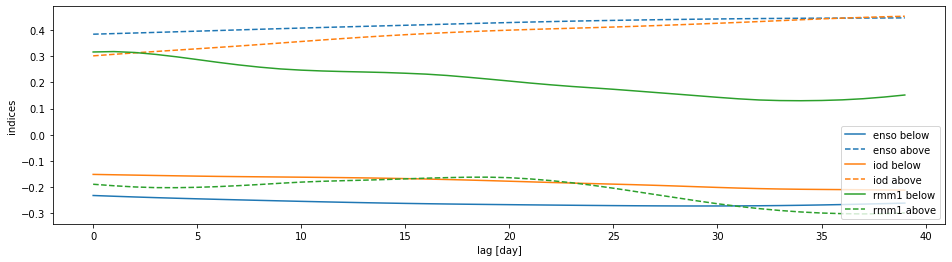

In [127]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
fig, axs = plt.subplots(1, figsize=plt.figaspect(0.25))
fig_title = ['enso','iod','rmm1','rmm2','t2m','e']
for ii in list([0,1,2]):
    plt.plot(np.nanmean(X_train_2d[tmp,ii,:],axis=0), color=colors[ii], label=fig_title[ii]+' below')
#     plt.plot(np.percentile(X_train_2d[tmp,ii,:],75,axis=0),color=colors[ii])
#     plt.plot(np.percentile(X_train_2d[tmp,ii,:],25,axis=0),color=colors[ii])
#     axs.fill_between(
#         np.arange(nlen),np.percentile(X_train_2d[tmp,ii,:],25,axis=0), np.percentile(X_train_2d[tmp,ii,:],75,axis=0), color=colors[ii], alpha=0.25, 
#     )
    plt.plot(np.nanmean(X_train_2d[tmp1,ii,:],axis=0), linestyle='dashed', color=colors[ii], label=fig_title[ii]+' above')
#     plt.plot(np.percentile(X_train_2d[tmp1,ii,:],75,axis=0),linestyle='dashed',color=colors[ii])
#     plt.plot(np.percentile(X_train_2d[tmp1,ii,:],25,axis=0),linestyle='dashed',color=colors[ii])
#     axs.fill_between(
#         np.arange(nlen),np.percentile(X_train_2d[tmp1,ii,:],25,axis=0), np.percentile(X_train_2d[tmp1,ii,:],75,axis=0), color=colors[ii], alpha=0.25, 
#     )
    #plt.plot(np.nanmean(X_train_2d[tmp2,ii,:],axis=0), linestyle='dotted', color=colors[ii])
    plt.legend(loc='lower right')
    plt.xlabel('lag [day]')
    plt.ylabel('indices')
plt.savefig('indices_drought_flood_lead14.png')

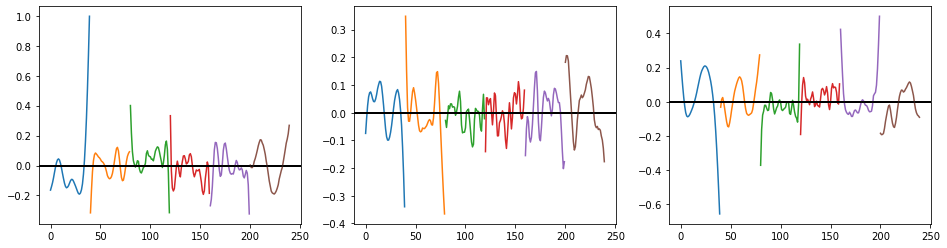

In [121]:
coef_mean = np.nanmean(coef_lr,axis=0)
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=plt.figaspect(0.25))
for ii in range(6):
    ax1.plot(np.arange(nlen)+nlen*ii,coef_mean[0,nlen*ii:(ii+1)*nlen])
    ax1.axhline(y = 0, color = 'k', linestyle = '-')
    ax2.plot(np.arange(nlen)+nlen*ii,coef_mean[1,nlen*ii:(ii+1)*nlen])
    ax2.axhline(y = 0, color = 'k', linestyle = '-')
    ax3.plot(np.arange(nlen)+nlen*ii,coef_mean[2,nlen*ii:(ii+1)*nlen])
    ax3.axhline(y = 0, color = 'k', linestyle = '-')
#plt.savefig('coef_lead14_lr.png')

In [122]:
per_imp_mean = np.nanmean(per_imp_lr,axis=0)
sorted_idx = per_imp_mean.argsort()
sorted_idx

array([ 73,  71,  70,  72,   6,  93,  95,   5,  88, 170, 171,   7,  74,
       169,  94,  10,  87,  82,   8,   9, 215, 214, 216, 179,  41, 172,
       205, 188,   4, 204,  11, 189,  58,  42, 180, 178, 203,  57, 213,
        34, 184,  59, 206,  60, 127, 190, 137, 217,  61, 202,  62, 131,
       200, 201, 191, 103,  33, 185, 187, 181,  69, 138, 183, 135, 102,
       182, 142,  83,  12, 195, 212, 192, 218, 196, 207, 134,  56, 128,
       168, 126, 158, 186,  86, 101, 139, 129,  84, 177, 193, 136,   3,
       104, 163, 194, 113,  63, 132, 219, 140, 141, 208, 111,  48, 211,
        92,  49, 157, 220, 147,  89,  50, 146,  47, 143, 209, 197, 223,
       114, 156, 109, 225,  13,  55, 221, 210, 112, 222, 224,  85, 148,
       110, 130, 133, 105, 226, 227, 162, 235,  52, 228,  51, 145, 149,
        54,  75,  64, 121,  53, 173, 230, 229, 232, 231, 167, 118, 106,
       236, 234,  46, 164, 176, 233, 100,  14,  43,  96, 198,  91, 108,
       150,   2, 237,  90, 107, 166, 165,  99, 175, 117, 174,  1

Text(0.5, 0, 'Permutation Importance')

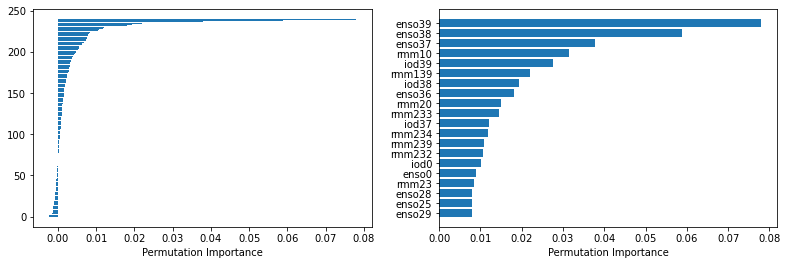

In [123]:
# Plot the feature importance
idx_list = []
for ii in range(len(sorted_idx)):
    if sorted_idx[ii] < nlen:
        idx_list.append('enso'+str(sorted_idx[ii]))
    elif sorted_idx[ii] < nlen*2:
        idx_list.append('iod'+str(sorted_idx[ii]-nlen))
    elif sorted_idx[ii] < nlen*3:
        idx_list.append('rmm1'+str(sorted_idx[ii]-nlen*2))
    elif sorted_idx[ii] < nlen*4:
        idx_list.append('rmm2'+str(sorted_idx[ii]-nlen*3))
    elif sorted_idx[ii] < nlen*5:
        idx_list.append('t2m'+str(sorted_idx[ii]-nlen*4))
    else:
        idx_list.append('e'+str(sorted_idx[ii]-nlen*5))

fig, (ax1,ax2) = plt.subplots(1,2, figsize=plt.figaspect(0.30))
ax1.barh(np.arange(nlen*6), per_imp_mean[sorted_idx], height=0.8)
ax1.set_xlabel('Permutation Importance')

ax2.barh(np.arange(20), per_imp_mean[sorted_idx[-20:]], tick_label=idx_list[-20:], height=0.8)
ax2.set_xlabel('Permutation Importance')
#plt.savefig('permut_import_lead14_lr.png')

In [105]:
np.corrcoef(coef_mean[0,:],coef_mean[2,:])

array([[ 1.        , -0.62281843],
       [-0.62281843,  1.        ]])

In [106]:
train_loss_lr, train_acc_lr = [],[]
valid_loss_lr, valid_acc_lr = [],[]
acc_tr_lr, f1_tr_lr, prec_tr_lr, rec_tr_lr = [],[],[],[]
bss_tr1_lr, calib_y_tr1_lr, calib_x_tr1_lr = [],[],[]
bss_tr2_lr, calib_y_tr2_lr, calib_x_tr2_lr = [],[],[]
bss_tr3_lr, calib_y_tr3_lr, calib_x_tr3_lr = [],[],[]
acc_va_lr, f1_va_lr, prec_va_lr, rec_va_lr = [],[],[],[]
bss_va1_lr, calib_y_va1_lr, calib_x_va1_lr = [],[],[]
bss_va2_lr, calib_y_va2_lr, calib_x_va2_lr = [],[],[]
bss_va3_lr, calib_y_va3_lr, calib_x_va3_lr = [],[],[]
acc_te_lr, f1_te_lr, prec_te_lr, rec_te_lr = [],[],[],[]
bss_te1_lr, calib_y_te1_lr, calib_x_te1_lr = [],[],[]
bss_te2_lr, calib_y_te2_lr, calib_x_te2_lr = [],[],[]
bss_te3_lr, calib_y_te3_lr, calib_x_te3_lr = [],[],[]
nbins = 10
for ii in range(NYRS-1):
    print("********", ii)
    val_year = [SYY+ii,SYY+ii+1]
    X_train, Y_train, X_val, Y_val = cross_valid_n_out(X_all_new, y_all, all_years, val_year=val_year)
    Y_train_2d = keras.utils.to_categorical(Y_train-1)
    Y_val_2d = keras.utils.to_categorical(Y_val-1)
    
    # for imbalanced classes
    class_weight = class_weight_creator(Y_train_2d)
    class_weight[0] = 2.0
    class_weight[1] = 1.0
    class_weight[2] = 1.0
    print(class_weight)
    
    mdim = np.shape(X_train)[1]
    lr_model = build_logistic(mdim, out_neurons=n_cat, regval=0.01)
    callbacks_path = '/net/cfc/s2s/zhengwu/code/tmp/precip_lr.h5'
    batch_size = 64
    epochs = 300
    lr = 0.0008
    history = train_model(lr_model, X_train, Y_train_2d, X_val, Y_val_2d, lr, callbacks_path, epochs, batch_size, class_weight)
   
    train_loss_lr.append(history.history['loss'])
    train_acc_lr.append(history.history['accuracy'])
    valid_loss_lr.append(history.history['val_loss'])
    valid_acc_lr.append(history.history['val_accuracy'])
    
    # evaluation training
    yprob = lr_model.predict(X_train)
    ypred = np.argmax(yprob,axis=1)+1
    y_prob_ref = clim_pr_y_cat1[0:len(Y_train)]
    recall, precision, f1, acc, bs, bss, calib_y, calib_x = score(Y_train, Y_train_2d[:,0], ypred, 
                                                    yprob[:,0], nbins, y_prob_ref)
    acc_tr_lr.append(acc)
    f1_tr_lr.append(f1)
    prec_tr_lr.append(precision)
    rec_tr_lr.append(recall)
    calib_y_tr1_lr.append(calib_y)
    calib_x_tr1_lr.append(calib_x)
    bss_tr1_lr.append(bss)
    
    y_prob_ref = clim_pr_y_cat3[0:len(Y_train)]
    recall, precision, f1, acc, bs, bss, calib_y, calib_x = score(Y_train, Y_train_2d[:,1], ypred, 
                                                    yprob[:,1], nbins, y_prob_ref)
    calib_y_tr2_lr.append(calib_y)
    calib_x_tr2_lr.append(calib_x)
    bss_tr2_lr.append(bss)
    
    y_prob_ref = clim_pr_y_cat4[0:len(Y_train)]
    recall, precision, f1, acc, bs, bss, calib_y, calib_x = score(Y_train, Y_train_2d[:,2], ypred, 
                                                    yprob[:,2], nbins, y_prob_ref)
    calib_y_tr3_lr.append(calib_y)
    calib_x_tr3_lr.append(calib_x)
    bss_tr3_lr.append(bss)
    
    # evaluation validation
    yprob = lr_model.predict(X_val)
    ypred = np.argmax(yprob,axis=1)+1
    y_prob_ref = clim_pr_y_cat1[0:len(Y_val)]
    recall, precision, f1, acc, bs, bss, calib_y, calib_x = score(Y_val, Y_val_2d[:,0], ypred, 
                                                    yprob[:,0], nbins, y_prob_ref)
    acc_va_lr.append(acc)
    f1_va_lr.append(f1)
    prec_va_lr.append(precision)
    rec_va_lr.append(recall)
    calib_y_va1_lr.append(calib_y)
    calib_x_va1_lr.append(calib_x)
    bss_va1_lr.append(bss)
    
    y_prob_ref = clim_pr_y_cat3[0:len(Y_val)]
    recall, precision, f1, acc, bs, bss, calib_y, calib_x = score(Y_val, Y_val_2d[:,1], ypred, 
                                                    yprob[:,1], nbins, y_prob_ref)
    calib_y_va2_lr.append(calib_y)
    calib_x_va2_lr.append(calib_x)
    bss_va2_lr.append(bss)
    
    y_prob_ref = clim_pr_y_cat4[0:len(Y_val)]
    recall, precision, f1, acc, bs, bss, calib_y, calib_x = score(Y_val, Y_val_2d[:,2], ypred, 
                                                    yprob[:,2], nbins, y_prob_ref)
    calib_y_va3_lr.append(calib_y)
    calib_x_va3_lr.append(calib_x)
    bss_va3_lr.append(bss)
    tf.keras.backend.clear_session()

******** 0
validation years [1981, 1982]
train years {1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 1983}
{0: 2.0, 1: 1.0, 2: 1.0}
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60)]              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 183       
                                                                 
Total params: 183
Trainable params: 183
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
28/28 [==============================] - 4s 106ms/step - loss: 2.0684 - accuracy: 0.3097 - val_loss: 1.5512 - val_accuracy: 0.1719
Epoch 2/300
28/28 [==============================] - 1s 23ms/step -

28/28 [==============================] - 1s 25ms/step - loss: 1.2187 - accuracy: 0.4754 - val_loss: 0.7859 - val_accuracy: 0.6875
Epoch 105/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2192 - accuracy: 0.4782 - val_loss: 0.7836 - val_accuracy: 0.6875
Epoch 106/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2189 - accuracy: 0.4799 - val_loss: 0.7835 - val_accuracy: 0.6875
Epoch 107/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2181 - accuracy: 0.4754 - val_loss: 0.7817 - val_accuracy: 0.6875
Epoch 108/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2187 - accuracy: 0.4760 - val_loss: 0.7832 - val_accuracy: 0.6875
Epoch 109/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2177 - accuracy: 0.4766 - val_loss: 0.7802 - val_accuracy: 0.6875
Epoch 110/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2180 - accuracy: 0.4766 - val_loss: 0.7842 - val_accuracy: 0.6875
Epoch 

Epoch 161/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2118 - accuracy: 0.4794 - val_loss: 0.7696 - val_accuracy: 0.6875
Epoch 162/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2123 - accuracy: 0.4777 - val_loss: 0.7733 - val_accuracy: 0.6875
Epoch 163/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2118 - accuracy: 0.4760 - val_loss: 0.7725 - val_accuracy: 0.6875
Epoch 164/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2124 - accuracy: 0.4777 - val_loss: 0.7724 - val_accuracy: 0.6875
Epoch 165/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2114 - accuracy: 0.4766 - val_loss: 0.7683 - val_accuracy: 0.6875
Epoch 166/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2110 - accuracy: 0.4760 - val_loss: 0.7688 - val_accuracy: 0.6875
Epoch 167/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2114 - accuracy: 0.4766 - val_loss: 0.7718 - val_accuracy:

Epoch 218/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2102 - accuracy: 0.4760 - val_loss: 0.7680 - val_accuracy: 0.6875
Epoch 219/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2100 - accuracy: 0.4794 - val_loss: 0.7663 - val_accuracy: 0.6875
Epoch 220/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2098 - accuracy: 0.4749 - val_loss: 0.7685 - val_accuracy: 0.6875
Epoch 221/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2102 - accuracy: 0.4782 - val_loss: 0.7688 - val_accuracy: 0.6875
Epoch 222/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2102 - accuracy: 0.4760 - val_loss: 0.7672 - val_accuracy: 0.6875
Epoch 223/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2105 - accuracy: 0.4771 - val_loss: 0.7650 - val_accuracy: 0.6875
Epoch 224/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2106 - accuracy: 0.4805 - val_loss: 0.7666 - val_accuracy:

Epoch 275/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2095 - accuracy: 0.4788 - val_loss: 0.7642 - val_accuracy: 0.6875
Epoch 276/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2088 - accuracy: 0.4782 - val_loss: 0.7661 - val_accuracy: 0.6875
Epoch 277/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2101 - accuracy: 0.4810 - val_loss: 0.7650 - val_accuracy: 0.6875
Epoch 278/300
28/28 [==============================] - 1s 21ms/step - loss: 1.2092 - accuracy: 0.4777 - val_loss: 0.7661 - val_accuracy: 0.6875
Epoch 279/300
28/28 [==============================] - 1s 27ms/step - loss: 1.2091 - accuracy: 0.4833 - val_loss: 0.7620 - val_accuracy: 0.6875
Epoch 280/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2085 - accuracy: 0.4805 - val_loss: 0.7647 - val_accuracy: 0.6875
Epoch 281/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2086 - accuracy: 0.4799 - val_loss: 0.7651 - val_accuracy:

/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


28/28 [==============================] - 4s 108ms/step - loss: 1.8470 - accuracy: 0.3689 - val_loss: 1.3428 - val_accuracy: 0.4141
Epoch 2/300
28/28 [==============================] - 1s 22ms/step - loss: 1.6553 - accuracy: 0.4369 - val_loss: 1.1249 - val_accuracy: 0.6094
Epoch 3/300
28/28 [==============================] - 1s 24ms/step - loss: 1.5815 - accuracy: 0.4559 - val_loss: 1.0490 - val_accuracy: 0.6797
Epoch 4/300
28/28 [==============================] - 1s 23ms/step - loss: 1.5354 - accuracy: 0.4570 - val_loss: 1.0090 - val_accuracy: 0.7188
Epoch 5/300
28/28 [==============================] - 1s 24ms/step - loss: 1.5058 - accuracy: 0.4509 - val_loss: 0.9929 - val_accuracy: 0.7031
Epoch 6/300
28/28 [==============================] - 1s 23ms/step - loss: 1.4828 - accuracy: 0.4537 - val_loss: 0.9672 - val_accuracy: 0.7031
Epoch 7/300
28/28 [==============================] - 1s 25ms/step - loss: 1.4648 - accuracy: 0.4548 - val_loss: 0.9524 - val_accuracy: 0.7031
Epoch 8/300
28/28

Epoch 56/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2435 - accuracy: 0.4799 - val_loss: 0.7527 - val_accuracy: 0.7031
Epoch 57/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2424 - accuracy: 0.4777 - val_loss: 0.7493 - val_accuracy: 0.7031
Epoch 58/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2410 - accuracy: 0.4788 - val_loss: 0.7463 - val_accuracy: 0.7031
Epoch 59/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2408 - accuracy: 0.4788 - val_loss: 0.7522 - val_accuracy: 0.7031
Epoch 60/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2395 - accuracy: 0.4777 - val_loss: 0.7450 - val_accuracy: 0.7031
Epoch 61/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2386 - accuracy: 0.4782 - val_loss: 0.7469 - val_accuracy: 0.7031
Epoch 62/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2376 - accuracy: 0.4777 - val_loss: 0.7477 - val_accuracy: 0.7031

Epoch 170/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2127 - accuracy: 0.4816 - val_loss: 0.7247 - val_accuracy: 0.7031
Epoch 171/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2126 - accuracy: 0.4827 - val_loss: 0.7216 - val_accuracy: 0.7031
Epoch 172/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2133 - accuracy: 0.4799 - val_loss: 0.7233 - val_accuracy: 0.7031
Epoch 173/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2124 - accuracy: 0.4805 - val_loss: 0.7273 - val_accuracy: 0.7031
Epoch 174/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2125 - accuracy: 0.4810 - val_loss: 0.7252 - val_accuracy: 0.7031
Epoch 175/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2124 - accuracy: 0.4821 - val_loss: 0.7213 - val_accuracy: 0.7031
Epoch 176/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2130 - accuracy: 0.4821 - val_loss: 0.7263 - val_accuracy:

Epoch 227/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2116 - accuracy: 0.4777 - val_loss: 0.7236 - val_accuracy: 0.7031
Epoch 228/300
28/28 [==============================] - 1s 27ms/step - loss: 1.2112 - accuracy: 0.4816 - val_loss: 0.7276 - val_accuracy: 0.7031
Epoch 229/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2117 - accuracy: 0.4799 - val_loss: 0.7271 - val_accuracy: 0.7031
Epoch 230/300
28/28 [==============================] - 1s 27ms/step - loss: 1.2118 - accuracy: 0.4799 - val_loss: 0.7213 - val_accuracy: 0.7031
Epoch 231/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2117 - accuracy: 0.4833 - val_loss: 0.7239 - val_accuracy: 0.7031
Epoch 232/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2115 - accuracy: 0.4821 - val_loss: 0.7239 - val_accuracy: 0.7031
Epoch 233/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2113 - accuracy: 0.4805 - val_loss: 0.7231 - val_accuracy:

Epoch 284/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2109 - accuracy: 0.4810 - val_loss: 0.7195 - val_accuracy: 0.7031
Epoch 285/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2107 - accuracy: 0.4810 - val_loss: 0.7274 - val_accuracy: 0.7031
Epoch 286/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2105 - accuracy: 0.4821 - val_loss: 0.7260 - val_accuracy: 0.7031
Epoch 287/300
28/28 [==============================] - 1s 22ms/step - loss: 1.2112 - accuracy: 0.4799 - val_loss: 0.7211 - val_accuracy: 0.7031
Epoch 288/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2109 - accuracy: 0.4821 - val_loss: 0.7210 - val_accuracy: 0.7031
Epoch 289/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2107 - accuracy: 0.4777 - val_loss: 0.7236 - val_accuracy: 0.7031
Epoch 290/300
28/28 [==============================] - 1s 22ms/step - loss: 1.2108 - accuracy: 0.4788 - val_loss: 0.7248 - val_accuracy:

/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Epoch 1/300
28/28 [==============================] - 4s 107ms/step - loss: 1.7007 - accuracy: 0.4537 - val_loss: 1.3297 - val_accuracy: 0.4688
Epoch 2/300
28/28 [==============================] - 1s 22ms/step - loss: 1.5797 - accuracy: 0.4771 - val_loss: 1.3245 - val_accuracy: 0.4844
Epoch 3/300
28/28 [==============================] - 1s 23ms/step - loss: 1.5114 - accuracy: 0.4927 - val_loss: 1.3262 - val_accuracy: 0.4766
Epoch 4/300
28/28 [==============================] - 1s 23ms/step - loss: 1.4711 - accuracy: 0.4883 - val_loss: 1.3250 - val_accuracy: 0.4219
Epoch 5/300
28/28 [==============================] - 1s 25ms/step - loss: 1.4464 - accuracy: 0.4939 - val_loss: 1.3294 - val_accuracy: 0.4141
Epoch 6/300
28/28 [==============================] - 1s 23ms/step - loss: 1.4274 - accuracy: 0.5022 - val_loss: 1.3226 - val_accuracy: 0.3984
Epoch 7/300
28/28 [==============================] - 1s 23ms/step - loss: 1.4124 - accuracy: 0.5061 - val_loss: 1.3163 - val_accuracy: 0.3672
Epoch

Epoch 56/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2093 - accuracy: 0.4989 - val_loss: 1.1919 - val_accuracy: 0.3672
Epoch 57/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2078 - accuracy: 0.5011 - val_loss: 1.1879 - val_accuracy: 0.3672
Epoch 58/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2065 - accuracy: 0.5017 - val_loss: 1.1897 - val_accuracy: 0.3672
Epoch 59/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2065 - accuracy: 0.5022 - val_loss: 1.1919 - val_accuracy: 0.3672
Epoch 60/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2055 - accuracy: 0.5000 - val_loss: 1.1888 - val_accuracy: 0.3672
Epoch 61/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2037 - accuracy: 0.4989 - val_loss: 1.1910 - val_accuracy: 0.3672
Epoch 62/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2028 - accuracy: 0.4994 - val_loss: 1.1873 - val_accuracy: 0.3672

Epoch 170/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1834 - accuracy: 0.5033 - val_loss: 1.1553 - val_accuracy: 0.3672
Epoch 171/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1836 - accuracy: 0.5039 - val_loss: 1.1530 - val_accuracy: 0.3672
Epoch 172/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1852 - accuracy: 0.5028 - val_loss: 1.1522 - val_accuracy: 0.3672
Epoch 173/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1837 - accuracy: 0.5050 - val_loss: 1.1539 - val_accuracy: 0.3672
Epoch 174/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1841 - accuracy: 0.5045 - val_loss: 1.1583 - val_accuracy: 0.3672
Epoch 175/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1840 - accuracy: 0.5033 - val_loss: 1.1542 - val_accuracy: 0.3672
Epoch 176/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1834 - accuracy: 0.5006 - val_loss: 1.1559 - val_accuracy:

Epoch 227/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1821 - accuracy: 0.5050 - val_loss: 1.1472 - val_accuracy: 0.3672
Epoch 228/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1818 - accuracy: 0.5056 - val_loss: 1.1582 - val_accuracy: 0.3672
Epoch 229/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1819 - accuracy: 0.5067 - val_loss: 1.1504 - val_accuracy: 0.3672
Epoch 230/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1813 - accuracy: 0.5056 - val_loss: 1.1530 - val_accuracy: 0.3672
Epoch 231/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1819 - accuracy: 0.5056 - val_loss: 1.1509 - val_accuracy: 0.3672
Epoch 232/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1832 - accuracy: 0.5050 - val_loss: 1.1541 - val_accuracy: 0.3672
Epoch 233/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1826 - accuracy: 0.5061 - val_loss: 1.1587 - val_accuracy:

Epoch 284/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1813 - accuracy: 0.5056 - val_loss: 1.1517 - val_accuracy: 0.3672
Epoch 285/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1813 - accuracy: 0.5045 - val_loss: 1.1504 - val_accuracy: 0.3672
Epoch 286/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1808 - accuracy: 0.5033 - val_loss: 1.1514 - val_accuracy: 0.3672
Epoch 287/300
28/28 [==============================] - 1s 22ms/step - loss: 1.1810 - accuracy: 0.5050 - val_loss: 1.1533 - val_accuracy: 0.3672
Epoch 288/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1812 - accuracy: 0.5028 - val_loss: 1.1521 - val_accuracy: 0.3672
Epoch 289/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1811 - accuracy: 0.5022 - val_loss: 1.1530 - val_accuracy: 0.3672
Epoch 290/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1816 - accuracy: 0.5050 - val_loss: 1.1552 - val_accuracy:

/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Epoch 1/300
28/28 [==============================] - 4s 109ms/step - loss: 1.7020 - accuracy: 0.4191 - val_loss: 1.5557 - val_accuracy: 0.2344
Epoch 2/300
28/28 [==============================] - 1s 25ms/step - loss: 1.5417 - accuracy: 0.4911 - val_loss: 1.4611 - val_accuracy: 0.2969
Epoch 3/300
28/28 [==============================] - 1s 23ms/step - loss: 1.4939 - accuracy: 0.4961 - val_loss: 1.4336 - val_accuracy: 0.2578
Epoch 4/300
28/28 [==============================] - 1s 27ms/step - loss: 1.4634 - accuracy: 0.4978 - val_loss: 1.4363 - val_accuracy: 0.2031
Epoch 5/300
28/28 [==============================] - 1s 25ms/step - loss: 1.4423 - accuracy: 0.5006 - val_loss: 1.4312 - val_accuracy: 0.2031
Epoch 6/300
28/28 [==============================] - 1s 24ms/step - loss: 1.4244 - accuracy: 0.4983 - val_loss: 1.4483 - val_accuracy: 0.2031
Epoch 7/300
28/28 [==============================] - 1s 25ms/step - loss: 1.4114 - accuracy: 0.5017 - val_loss: 1.4300 - val_accuracy: 0.2031
Epoch

Epoch 56/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2049 - accuracy: 0.5134 - val_loss: 1.3868 - val_accuracy: 0.2031
Epoch 57/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2027 - accuracy: 0.5145 - val_loss: 1.3802 - val_accuracy: 0.2031
Epoch 58/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2024 - accuracy: 0.5140 - val_loss: 1.3826 - val_accuracy: 0.2031
Epoch 59/300
28/28 [==============================] - 1s 22ms/step - loss: 1.2018 - accuracy: 0.5162 - val_loss: 1.3867 - val_accuracy: 0.2031
Epoch 60/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2015 - accuracy: 0.5140 - val_loss: 1.3768 - val_accuracy: 0.2031
Epoch 61/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2001 - accuracy: 0.5156 - val_loss: 1.3875 - val_accuracy: 0.2031
Epoch 62/300
28/28 [==============================] - 1s 21ms/step - loss: 1.1999 - accuracy: 0.5156 - val_loss: 1.3873 - val_accuracy: 0.2031

Epoch 170/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1799 - accuracy: 0.5134 - val_loss: 1.3510 - val_accuracy: 0.2031
Epoch 171/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1801 - accuracy: 0.5128 - val_loss: 1.3504 - val_accuracy: 0.2031
Epoch 172/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1809 - accuracy: 0.5145 - val_loss: 1.3563 - val_accuracy: 0.2031
Epoch 173/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1808 - accuracy: 0.5140 - val_loss: 1.3603 - val_accuracy: 0.2031
Epoch 174/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1815 - accuracy: 0.5128 - val_loss: 1.3446 - val_accuracy: 0.2031
Epoch 175/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1813 - accuracy: 0.5134 - val_loss: 1.3471 - val_accuracy: 0.2031
Epoch 176/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1795 - accuracy: 0.5145 - val_loss: 1.3537 - val_accuracy:

Epoch 227/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1791 - accuracy: 0.5151 - val_loss: 1.3639 - val_accuracy: 0.2031
Epoch 228/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1782 - accuracy: 0.5128 - val_loss: 1.3456 - val_accuracy: 0.2031
Epoch 229/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1783 - accuracy: 0.5156 - val_loss: 1.3568 - val_accuracy: 0.2031
Epoch 230/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1787 - accuracy: 0.5145 - val_loss: 1.3446 - val_accuracy: 0.2031
Epoch 231/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1776 - accuracy: 0.5140 - val_loss: 1.3518 - val_accuracy: 0.2031
Epoch 232/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1779 - accuracy: 0.5145 - val_loss: 1.3493 - val_accuracy: 0.2031
Epoch 233/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1776 - accuracy: 0.5128 - val_loss: 1.3528 - val_accuracy:

Epoch 284/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1773 - accuracy: 0.5128 - val_loss: 1.3630 - val_accuracy: 0.2031
Epoch 285/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1774 - accuracy: 0.5134 - val_loss: 1.3476 - val_accuracy: 0.2031
Epoch 286/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1773 - accuracy: 0.5134 - val_loss: 1.3627 - val_accuracy: 0.2031
Epoch 287/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1778 - accuracy: 0.5134 - val_loss: 1.3537 - val_accuracy: 0.2031
Epoch 288/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1771 - accuracy: 0.5151 - val_loss: 1.3553 - val_accuracy: 0.2031
Epoch 289/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1773 - accuracy: 0.5140 - val_loss: 1.3448 - val_accuracy: 0.2031
Epoch 290/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1775 - accuracy: 0.5134 - val_loss: 1.3552 - val_accuracy:

/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Epoch 1/300
28/28 [==============================] - 4s 107ms/step - loss: 1.6581 - accuracy: 0.4263 - val_loss: 1.4665 - val_accuracy: 0.3203
Epoch 2/300
28/28 [==============================] - 1s 23ms/step - loss: 1.5445 - accuracy: 0.4727 - val_loss: 1.3910 - val_accuracy: 0.3359
Epoch 3/300
28/28 [==============================] - 1s 25ms/step - loss: 1.4898 - accuracy: 0.4922 - val_loss: 1.3575 - val_accuracy: 0.3359
Epoch 4/300
28/28 [==============================] - 1s 24ms/step - loss: 1.4595 - accuracy: 0.5123 - val_loss: 1.3314 - val_accuracy: 0.2891
Epoch 5/300
28/28 [==============================] - 1s 25ms/step - loss: 1.4398 - accuracy: 0.5100 - val_loss: 1.3151 - val_accuracy: 0.3125
Epoch 6/300
28/28 [==============================] - 1s 24ms/step - loss: 1.4235 - accuracy: 0.5050 - val_loss: 1.3037 - val_accuracy: 0.3281
Epoch 7/300
28/28 [==============================] - 1s 24ms/step - loss: 1.4106 - accuracy: 0.5073 - val_loss: 1.2856 - val_accuracy: 0.3594
Epoch

Epoch 56/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2083 - accuracy: 0.4911 - val_loss: 1.0973 - val_accuracy: 0.5078
Epoch 57/300
28/28 [==============================] - 1s 22ms/step - loss: 1.2078 - accuracy: 0.4939 - val_loss: 1.0849 - val_accuracy: 0.5078
Epoch 58/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2070 - accuracy: 0.4916 - val_loss: 1.0932 - val_accuracy: 0.5078
Epoch 59/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2063 - accuracy: 0.4961 - val_loss: 1.0945 - val_accuracy: 0.5078
Epoch 60/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2058 - accuracy: 0.4922 - val_loss: 1.0944 - val_accuracy: 0.5078
Epoch 61/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2050 - accuracy: 0.4927 - val_loss: 1.0898 - val_accuracy: 0.5156
Epoch 62/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2043 - accuracy: 0.4939 - val_loss: 1.0925 - val_accuracy: 0.5078

Epoch 170/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1857 - accuracy: 0.4955 - val_loss: 1.0662 - val_accuracy: 0.5234
Epoch 171/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1852 - accuracy: 0.4911 - val_loss: 1.0782 - val_accuracy: 0.5234
Epoch 172/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1854 - accuracy: 0.4955 - val_loss: 1.0655 - val_accuracy: 0.5234
Epoch 173/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1852 - accuracy: 0.4927 - val_loss: 1.0658 - val_accuracy: 0.5234
Epoch 174/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1844 - accuracy: 0.4933 - val_loss: 1.0683 - val_accuracy: 0.5234
Epoch 175/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1846 - accuracy: 0.4927 - val_loss: 1.0632 - val_accuracy: 0.5234
Epoch 176/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1855 - accuracy: 0.4950 - val_loss: 1.0774 - val_accuracy:

Epoch 227/300
28/28 [==============================] - 1s 22ms/step - loss: 1.1834 - accuracy: 0.4916 - val_loss: 1.0624 - val_accuracy: 0.5234
Epoch 228/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1839 - accuracy: 0.4922 - val_loss: 1.0714 - val_accuracy: 0.5234
Epoch 229/300
28/28 [==============================] - 2s 58ms/step - loss: 1.1835 - accuracy: 0.4905 - val_loss: 1.0642 - val_accuracy: 0.5234
Epoch 230/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1834 - accuracy: 0.4916 - val_loss: 1.0651 - val_accuracy: 0.5234
Epoch 231/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1838 - accuracy: 0.4933 - val_loss: 1.0720 - val_accuracy: 0.5234
Epoch 232/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1834 - accuracy: 0.4933 - val_loss: 1.0613 - val_accuracy: 0.5234
Epoch 233/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1839 - accuracy: 0.4933 - val_loss: 1.0736 - val_accuracy:

Epoch 284/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1846 - accuracy: 0.4989 - val_loss: 1.0738 - val_accuracy: 0.5234
Epoch 285/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1829 - accuracy: 0.4911 - val_loss: 1.0656 - val_accuracy: 0.5234
Epoch 286/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1819 - accuracy: 0.4955 - val_loss: 1.0678 - val_accuracy: 0.5234
Epoch 287/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1830 - accuracy: 0.4933 - val_loss: 1.0667 - val_accuracy: 0.5234
Epoch 288/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1834 - accuracy: 0.4978 - val_loss: 1.0624 - val_accuracy: 0.5234
Epoch 289/300
28/28 [==============================] - 1s 22ms/step - loss: 1.1823 - accuracy: 0.4916 - val_loss: 1.0636 - val_accuracy: 0.5234
Epoch 290/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1818 - accuracy: 0.4922 - val_loss: 1.0643 - val_accuracy:

/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Epoch 1/300
28/28 [==============================] - 4s 107ms/step - loss: 1.7353 - accuracy: 0.4336 - val_loss: 1.4275 - val_accuracy: 0.3438
Epoch 2/300
28/28 [==============================] - 1s 23ms/step - loss: 1.5810 - accuracy: 0.4704 - val_loss: 1.3851 - val_accuracy: 0.3359
Epoch 3/300
28/28 [==============================] - 1s 26ms/step - loss: 1.5057 - accuracy: 0.4905 - val_loss: 1.3653 - val_accuracy: 0.4141
Epoch 4/300
28/28 [==============================] - 1s 25ms/step - loss: 1.4685 - accuracy: 0.5017 - val_loss: 1.3545 - val_accuracy: 0.4219
Epoch 5/300
28/28 [==============================] - 1s 23ms/step - loss: 1.4468 - accuracy: 0.5078 - val_loss: 1.3501 - val_accuracy: 0.4375
Epoch 6/300
28/28 [==============================] - 1s 25ms/step - loss: 1.4320 - accuracy: 0.5095 - val_loss: 1.3471 - val_accuracy: 0.4453
Epoch 7/300
28/28 [==============================] - 1s 24ms/step - loss: 1.4196 - accuracy: 0.4994 - val_loss: 1.3333 - val_accuracy: 0.4531
Epoch

28/28 [==============================] - 1s 25ms/step - loss: 1.2140 - accuracy: 0.4844 - val_loss: 1.1012 - val_accuracy: 0.6016
Epoch 55/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2123 - accuracy: 0.4788 - val_loss: 1.1027 - val_accuracy: 0.6016
Epoch 56/300
28/28 [==============================] - 1s 22ms/step - loss: 1.2114 - accuracy: 0.4860 - val_loss: 1.1023 - val_accuracy: 0.5938
Epoch 57/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2102 - accuracy: 0.4827 - val_loss: 1.1015 - val_accuracy: 0.6016
Epoch 58/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2082 - accuracy: 0.4833 - val_loss: 1.0983 - val_accuracy: 0.6016
Epoch 59/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2086 - accuracy: 0.4838 - val_loss: 1.0999 - val_accuracy: 0.5938
Epoch 60/300
28/28 [==============================] - 1s 21ms/step - loss: 1.2062 - accuracy: 0.4794 - val_loss: 1.0976 - val_accuracy: 0.5938
Epoch 61/300

Epoch 168/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1778 - accuracy: 0.4827 - val_loss: 1.0622 - val_accuracy: 0.6406
Epoch 169/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1776 - accuracy: 0.4883 - val_loss: 1.0604 - val_accuracy: 0.6484
Epoch 170/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1776 - accuracy: 0.4855 - val_loss: 1.0646 - val_accuracy: 0.6484
Epoch 171/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1771 - accuracy: 0.4855 - val_loss: 1.0648 - val_accuracy: 0.6406
Epoch 172/300
28/28 [==============================] - 1s 22ms/step - loss: 1.1782 - accuracy: 0.4872 - val_loss: 1.0638 - val_accuracy: 0.6484
Epoch 173/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1775 - accuracy: 0.4849 - val_loss: 1.0633 - val_accuracy: 0.6406
Epoch 174/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1782 - accuracy: 0.4877 - val_loss: 1.0624 - val_accuracy:

Epoch 225/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1768 - accuracy: 0.4849 - val_loss: 1.0621 - val_accuracy: 0.6484
Epoch 226/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1764 - accuracy: 0.4883 - val_loss: 1.0591 - val_accuracy: 0.6562
Epoch 227/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1764 - accuracy: 0.4866 - val_loss: 1.0623 - val_accuracy: 0.6484
Epoch 228/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1766 - accuracy: 0.4860 - val_loss: 1.0601 - val_accuracy: 0.6562
Epoch 229/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1769 - accuracy: 0.4860 - val_loss: 1.0600 - val_accuracy: 0.6484
Epoch 230/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1769 - accuracy: 0.4849 - val_loss: 1.0648 - val_accuracy: 0.6484
Epoch 231/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1768 - accuracy: 0.4883 - val_loss: 1.0584 - val_accuracy:

Epoch 282/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1780 - accuracy: 0.4849 - val_loss: 1.0628 - val_accuracy: 0.6484
Epoch 283/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1770 - accuracy: 0.4827 - val_loss: 1.0581 - val_accuracy: 0.6484
Epoch 284/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1772 - accuracy: 0.4900 - val_loss: 1.0613 - val_accuracy: 0.6641
Epoch 285/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1766 - accuracy: 0.4844 - val_loss: 1.0587 - val_accuracy: 0.6484
Epoch 286/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1761 - accuracy: 0.4900 - val_loss: 1.0608 - val_accuracy: 0.6562
Epoch 287/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1765 - accuracy: 0.4860 - val_loss: 1.0607 - val_accuracy: 0.6484
Epoch 288/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1766 - accuracy: 0.4855 - val_loss: 1.0589 - val_accuracy:

/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Epoch 1/300
28/28 [==============================] - 4s 108ms/step - loss: 1.9729 - accuracy: 0.4035 - val_loss: 2.3005 - val_accuracy: 0.2812
Epoch 2/300
28/28 [==============================] - 1s 24ms/step - loss: 1.8003 - accuracy: 0.4358 - val_loss: 2.0930 - val_accuracy: 0.2656
Epoch 3/300
28/28 [==============================] - 1s 24ms/step - loss: 1.6684 - accuracy: 0.4408 - val_loss: 1.8851 - val_accuracy: 0.2422
Epoch 4/300
28/28 [==============================] - 1s 24ms/step - loss: 1.5736 - accuracy: 0.4498 - val_loss: 1.7139 - val_accuracy: 0.2422
Epoch 5/300
28/28 [==============================] - 1s 24ms/step - loss: 1.5059 - accuracy: 0.4626 - val_loss: 1.5681 - val_accuracy: 0.2422
Epoch 6/300
28/28 [==============================] - 1s 24ms/step - loss: 1.4572 - accuracy: 0.4621 - val_loss: 1.5035 - val_accuracy: 0.2422
Epoch 7/300
28/28 [==============================] - 1s 24ms/step - loss: 1.4259 - accuracy: 0.4771 - val_loss: 1.4274 - val_accuracy: 0.2422
Epoch

Epoch 56/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2089 - accuracy: 0.4944 - val_loss: 1.2055 - val_accuracy: 0.3828
Epoch 57/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2077 - accuracy: 0.4961 - val_loss: 1.2082 - val_accuracy: 0.3828
Epoch 58/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2072 - accuracy: 0.4950 - val_loss: 1.2068 - val_accuracy: 0.3828
Epoch 59/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2058 - accuracy: 0.4967 - val_loss: 1.2048 - val_accuracy: 0.3906
Epoch 60/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2063 - accuracy: 0.4933 - val_loss: 1.1964 - val_accuracy: 0.3828
Epoch 61/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2047 - accuracy: 0.4989 - val_loss: 1.1984 - val_accuracy: 0.3906
Epoch 62/300
28/28 [==============================] - 1s 22ms/step - loss: 1.2029 - accuracy: 0.4967 - val_loss: 1.1997 - val_accuracy: 0.3828

Epoch 170/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1828 - accuracy: 0.5011 - val_loss: 1.1511 - val_accuracy: 0.4219
Epoch 171/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1825 - accuracy: 0.5033 - val_loss: 1.1479 - val_accuracy: 0.4297
Epoch 172/300
28/28 [==============================] - 1s 22ms/step - loss: 1.1824 - accuracy: 0.5006 - val_loss: 1.1475 - val_accuracy: 0.4297
Epoch 173/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1827 - accuracy: 0.5022 - val_loss: 1.1529 - val_accuracy: 0.4453
Epoch 174/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1825 - accuracy: 0.5022 - val_loss: 1.1525 - val_accuracy: 0.4219
Epoch 175/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1822 - accuracy: 0.5011 - val_loss: 1.1466 - val_accuracy: 0.4297
Epoch 176/300
28/28 [==============================] - 1s 22ms/step - loss: 1.1827 - accuracy: 0.5011 - val_loss: 1.1486 - val_accuracy:

Epoch 227/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1821 - accuracy: 0.5022 - val_loss: 1.1647 - val_accuracy: 0.4219
Epoch 228/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1819 - accuracy: 0.5033 - val_loss: 1.1553 - val_accuracy: 0.4219
Epoch 229/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1822 - accuracy: 0.5045 - val_loss: 1.1457 - val_accuracy: 0.4219
Epoch 230/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1813 - accuracy: 0.5045 - val_loss: 1.1464 - val_accuracy: 0.4219
Epoch 231/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1810 - accuracy: 0.5045 - val_loss: 1.1564 - val_accuracy: 0.4219
Epoch 232/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1811 - accuracy: 0.5017 - val_loss: 1.1552 - val_accuracy: 0.4219
Epoch 233/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1811 - accuracy: 0.5033 - val_loss: 1.1526 - val_accuracy:

Epoch 284/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1808 - accuracy: 0.5045 - val_loss: 1.1518 - val_accuracy: 0.4297
Epoch 285/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1807 - accuracy: 0.5028 - val_loss: 1.1570 - val_accuracy: 0.4219
Epoch 286/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1805 - accuracy: 0.5056 - val_loss: 1.1548 - val_accuracy: 0.4375
Epoch 287/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1803 - accuracy: 0.5033 - val_loss: 1.1485 - val_accuracy: 0.4219
Epoch 288/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1808 - accuracy: 0.5061 - val_loss: 1.1468 - val_accuracy: 0.4219
Epoch 289/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1804 - accuracy: 0.5017 - val_loss: 1.1536 - val_accuracy: 0.4219
Epoch 290/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1805 - accuracy: 0.5050 - val_loss: 1.1523 - val_accuracy:

/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


28/28 [==============================] - 4s 109ms/step - loss: 1.7754 - accuracy: 0.4604 - val_loss: 1.8039 - val_accuracy: 0.2812
Epoch 2/300
28/28 [==============================] - 1s 23ms/step - loss: 1.6285 - accuracy: 0.4794 - val_loss: 1.5775 - val_accuracy: 0.3594
Epoch 3/300
28/28 [==============================] - 1s 47ms/step - loss: 1.5347 - accuracy: 0.4927 - val_loss: 1.4711 - val_accuracy: 0.4062
Epoch 4/300
28/28 [==============================] - 1s 25ms/step - loss: 1.4807 - accuracy: 0.5100 - val_loss: 1.3686 - val_accuracy: 0.4219
Epoch 5/300
28/28 [==============================] - 0s 17ms/step - loss: 1.4502 - accuracy: 0.5017 - val_loss: 1.3085 - val_accuracy: 0.4453
Epoch 6/300
28/28 [==============================] - 1s 32ms/step - loss: 1.4306 - accuracy: 0.5123 - val_loss: 1.2698 - val_accuracy: 0.4375
Epoch 7/300
28/28 [==============================] - 1s 24ms/step - loss: 1.4157 - accuracy: 0.5022 - val_loss: 1.2778 - val_accuracy: 0.4375
Epoch 8/300
28/28

Epoch 56/300
28/28 [==============================] - 1s 22ms/step - loss: 1.2226 - accuracy: 0.4967 - val_loss: 1.1626 - val_accuracy: 0.3672
Epoch 57/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2214 - accuracy: 0.4972 - val_loss: 1.1582 - val_accuracy: 0.3594
Epoch 58/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2208 - accuracy: 0.4950 - val_loss: 1.1562 - val_accuracy: 0.3672
Epoch 59/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2197 - accuracy: 0.4978 - val_loss: 1.1680 - val_accuracy: 0.3594
Epoch 60/300
28/28 [==============================] - 1s 22ms/step - loss: 1.2188 - accuracy: 0.4978 - val_loss: 1.1735 - val_accuracy: 0.3594
Epoch 61/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2171 - accuracy: 0.4978 - val_loss: 1.1689 - val_accuracy: 0.3750
Epoch 62/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2165 - accuracy: 0.4994 - val_loss: 1.1633 - val_accuracy: 0.3594

Epoch 170/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1902 - accuracy: 0.4939 - val_loss: 1.1111 - val_accuracy: 0.3672
Epoch 171/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1905 - accuracy: 0.4950 - val_loss: 1.1263 - val_accuracy: 0.3672
Epoch 172/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1911 - accuracy: 0.4961 - val_loss: 1.1277 - val_accuracy: 0.3594
Epoch 173/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1899 - accuracy: 0.4955 - val_loss: 1.1201 - val_accuracy: 0.3672
Epoch 174/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1902 - accuracy: 0.4944 - val_loss: 1.1146 - val_accuracy: 0.3594
Epoch 175/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1901 - accuracy: 0.4955 - val_loss: 1.1186 - val_accuracy: 0.3594
Epoch 176/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1896 - accuracy: 0.4950 - val_loss: 1.1225 - val_accuracy:

Epoch 227/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1889 - accuracy: 0.4944 - val_loss: 1.1151 - val_accuracy: 0.3672
Epoch 228/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1883 - accuracy: 0.4944 - val_loss: 1.1150 - val_accuracy: 0.3594
Epoch 229/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1891 - accuracy: 0.4927 - val_loss: 1.1293 - val_accuracy: 0.3594
Epoch 230/300
28/28 [==============================] - 1s 28ms/step - loss: 1.1894 - accuracy: 0.4967 - val_loss: 1.1291 - val_accuracy: 0.3594
Epoch 231/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1887 - accuracy: 0.4961 - val_loss: 1.1191 - val_accuracy: 0.3672
Epoch 232/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1897 - accuracy: 0.4967 - val_loss: 1.1155 - val_accuracy: 0.3672
Epoch 233/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1896 - accuracy: 0.4955 - val_loss: 1.1371 - val_accuracy:

Epoch 284/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1884 - accuracy: 0.4939 - val_loss: 1.1241 - val_accuracy: 0.3672
Epoch 285/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1880 - accuracy: 0.4955 - val_loss: 1.1221 - val_accuracy: 0.3828
Epoch 286/300
28/28 [==============================] - 1s 28ms/step - loss: 1.1890 - accuracy: 0.4955 - val_loss: 1.1188 - val_accuracy: 0.3672
Epoch 287/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1898 - accuracy: 0.4978 - val_loss: 1.1410 - val_accuracy: 0.3750
Epoch 288/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1888 - accuracy: 0.4967 - val_loss: 1.1319 - val_accuracy: 0.3672
Epoch 289/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1879 - accuracy: 0.4955 - val_loss: 1.1268 - val_accuracy: 0.3672
Epoch 290/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1894 - accuracy: 0.4978 - val_loss: 1.1420 - val_accuracy:

Epoch 18/300
28/28 [==============================] - 1s 26ms/step - loss: 1.3070 - accuracy: 0.4972 - val_loss: 1.2819 - val_accuracy: 0.3281
Epoch 19/300
28/28 [==============================] - 1s 24ms/step - loss: 1.3011 - accuracy: 0.4961 - val_loss: 1.2832 - val_accuracy: 0.3047
Epoch 20/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2946 - accuracy: 0.4967 - val_loss: 1.2814 - val_accuracy: 0.3047
Epoch 21/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2896 - accuracy: 0.4967 - val_loss: 1.2814 - val_accuracy: 0.2969
Epoch 22/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2846 - accuracy: 0.4955 - val_loss: 1.2825 - val_accuracy: 0.2969
Epoch 23/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2799 - accuracy: 0.4983 - val_loss: 1.2827 - val_accuracy: 0.2734
Epoch 24/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2756 - accuracy: 0.4989 - val_loss: 1.2829 - val_accuracy: 0.2734

28/28 [==============================] - 1s 25ms/step - loss: 1.1911 - accuracy: 0.5022 - val_loss: 1.2348 - val_accuracy: 0.2500
Epoch 133/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1908 - accuracy: 0.5050 - val_loss: 1.2391 - val_accuracy: 0.2500
Epoch 134/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1908 - accuracy: 0.5056 - val_loss: 1.2407 - val_accuracy: 0.2422
Epoch 135/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1903 - accuracy: 0.5028 - val_loss: 1.2334 - val_accuracy: 0.2500
Epoch 136/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1901 - accuracy: 0.5039 - val_loss: 1.2351 - val_accuracy: 0.2500
Epoch 137/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1900 - accuracy: 0.5022 - val_loss: 1.2389 - val_accuracy: 0.2422
Epoch 138/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1897 - accuracy: 0.5056 - val_loss: 1.2332 - val_accuracy: 0.2500
Epoch 

Epoch 189/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1870 - accuracy: 0.5045 - val_loss: 1.2375 - val_accuracy: 0.2422
Epoch 190/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1867 - accuracy: 0.5039 - val_loss: 1.2386 - val_accuracy: 0.2500
Epoch 191/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1869 - accuracy: 0.5045 - val_loss: 1.2345 - val_accuracy: 0.2500
Epoch 192/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1866 - accuracy: 0.5039 - val_loss: 1.2379 - val_accuracy: 0.2500
Epoch 193/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1871 - accuracy: 0.5056 - val_loss: 1.2397 - val_accuracy: 0.2500
Epoch 194/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1869 - accuracy: 0.5045 - val_loss: 1.2359 - val_accuracy: 0.2500
Epoch 195/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1873 - accuracy: 0.5028 - val_loss: 1.2405 - val_accuracy:

Epoch 246/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1855 - accuracy: 0.5056 - val_loss: 1.2392 - val_accuracy: 0.2422
Epoch 247/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1860 - accuracy: 0.5033 - val_loss: 1.2377 - val_accuracy: 0.2422
Epoch 248/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1853 - accuracy: 0.4989 - val_loss: 1.2375 - val_accuracy: 0.2422
Epoch 249/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1850 - accuracy: 0.5045 - val_loss: 1.2381 - val_accuracy: 0.2500
Epoch 250/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1847 - accuracy: 0.5033 - val_loss: 1.2418 - val_accuracy: 0.2344
Epoch 251/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1851 - accuracy: 0.5022 - val_loss: 1.2396 - val_accuracy: 0.2422
Epoch 252/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1846 - accuracy: 0.5045 - val_loss: 1.2385 - val_accuracy:

/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Epoch 1/300
28/28 [==============================] - 4s 110ms/step - loss: 1.7039 - accuracy: 0.4487 - val_loss: 1.6554 - val_accuracy: 0.3281
Epoch 2/300
28/28 [==============================] - 1s 25ms/step - loss: 1.5710 - accuracy: 0.4676 - val_loss: 1.6524 - val_accuracy: 0.3516
Epoch 3/300
28/28 [==============================] - 1s 24ms/step - loss: 1.4976 - accuracy: 0.4821 - val_loss: 1.6597 - val_accuracy: 0.2734
Epoch 4/300
28/28 [==============================] - 1s 25ms/step - loss: 1.4587 - accuracy: 0.5033 - val_loss: 1.6867 - val_accuracy: 0.2188
Epoch 5/300
28/28 [==============================] - 1s 24ms/step - loss: 1.4336 - accuracy: 0.5128 - val_loss: 1.6910 - val_accuracy: 0.1875
Epoch 6/300
28/28 [==============================] - 1s 24ms/step - loss: 1.4160 - accuracy: 0.5128 - val_loss: 1.6895 - val_accuracy: 0.1562
Epoch 7/300
28/28 [==============================] - 1s 25ms/step - loss: 1.4025 - accuracy: 0.5112 - val_loss: 1.6850 - val_accuracy: 0.1484
Epoch

Epoch 56/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1991 - accuracy: 0.5156 - val_loss: 1.4187 - val_accuracy: 0.1719
Epoch 57/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1982 - accuracy: 0.5162 - val_loss: 1.4226 - val_accuracy: 0.1719
Epoch 58/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1967 - accuracy: 0.5145 - val_loss: 1.4142 - val_accuracy: 0.1719
Epoch 59/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1954 - accuracy: 0.5112 - val_loss: 1.4178 - val_accuracy: 0.1719
Epoch 60/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1937 - accuracy: 0.5134 - val_loss: 1.4147 - val_accuracy: 0.1797
Epoch 61/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1928 - accuracy: 0.5179 - val_loss: 1.4135 - val_accuracy: 0.1797
Epoch 62/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1924 - accuracy: 0.5167 - val_loss: 1.4015 - val_accuracy: 0.1875

Epoch 170/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1684 - accuracy: 0.5134 - val_loss: 1.3745 - val_accuracy: 0.1875
Epoch 171/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1684 - accuracy: 0.5128 - val_loss: 1.3727 - val_accuracy: 0.1875
Epoch 172/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1689 - accuracy: 0.5100 - val_loss: 1.3675 - val_accuracy: 0.1875
Epoch 173/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1678 - accuracy: 0.5134 - val_loss: 1.3684 - val_accuracy: 0.1875
Epoch 174/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1679 - accuracy: 0.5117 - val_loss: 1.3724 - val_accuracy: 0.1875
Epoch 175/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1679 - accuracy: 0.5123 - val_loss: 1.3687 - val_accuracy: 0.1875
Epoch 176/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1681 - accuracy: 0.5123 - val_loss: 1.3688 - val_accuracy:

Epoch 227/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1674 - accuracy: 0.5117 - val_loss: 1.3606 - val_accuracy: 0.1875
Epoch 228/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1666 - accuracy: 0.5134 - val_loss: 1.3622 - val_accuracy: 0.1875
Epoch 229/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1671 - accuracy: 0.5123 - val_loss: 1.3632 - val_accuracy: 0.1953
Epoch 230/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1667 - accuracy: 0.5123 - val_loss: 1.3642 - val_accuracy: 0.1875
Epoch 231/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1674 - accuracy: 0.5117 - val_loss: 1.3644 - val_accuracy: 0.1875
Epoch 232/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1669 - accuracy: 0.5106 - val_loss: 1.3611 - val_accuracy: 0.1875
Epoch 233/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1665 - accuracy: 0.5100 - val_loss: 1.3584 - val_accuracy:

Epoch 284/300
28/28 [==============================] - 1s 28ms/step - loss: 1.1663 - accuracy: 0.5145 - val_loss: 1.3565 - val_accuracy: 0.1953
Epoch 285/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1664 - accuracy: 0.5123 - val_loss: 1.3601 - val_accuracy: 0.1875
Epoch 286/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1656 - accuracy: 0.5117 - val_loss: 1.3583 - val_accuracy: 0.1953
Epoch 287/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1659 - accuracy: 0.5117 - val_loss: 1.3566 - val_accuracy: 0.1875
Epoch 288/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1673 - accuracy: 0.5145 - val_loss: 1.3542 - val_accuracy: 0.1875
Epoch 289/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1671 - accuracy: 0.5128 - val_loss: 1.3565 - val_accuracy: 0.1875
Epoch 290/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1663 - accuracy: 0.5095 - val_loss: 1.3609 - val_accuracy:

/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Epoch 1/300
28/28 [==============================] - 4s 107ms/step - loss: 1.6428 - accuracy: 0.4487 - val_loss: 1.5297 - val_accuracy: 0.2656
Epoch 2/300
28/28 [==============================] - 1s 23ms/step - loss: 1.5203 - accuracy: 0.4710 - val_loss: 1.5564 - val_accuracy: 0.1484
Epoch 3/300
28/28 [==============================] - 1s 24ms/step - loss: 1.4754 - accuracy: 0.4738 - val_loss: 1.5602 - val_accuracy: 0.1094
Epoch 4/300
28/28 [==============================] - 1s 23ms/step - loss: 1.4462 - accuracy: 0.4721 - val_loss: 1.5524 - val_accuracy: 0.1094
Epoch 5/300
28/28 [==============================] - 1s 24ms/step - loss: 1.4241 - accuracy: 0.4738 - val_loss: 1.5487 - val_accuracy: 0.0938
Epoch 6/300
28/28 [==============================] - 1s 23ms/step - loss: 1.4044 - accuracy: 0.4794 - val_loss: 1.5359 - val_accuracy: 0.0859
Epoch 7/300
28/28 [==============================] - 1s 25ms/step - loss: 1.3856 - accuracy: 0.4821 - val_loss: 1.5299 - val_accuracy: 0.0469
Epoch

Epoch 56/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1907 - accuracy: 0.5140 - val_loss: 1.3748 - val_accuracy: 0.1406
Epoch 57/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1894 - accuracy: 0.5123 - val_loss: 1.3760 - val_accuracy: 0.1406
Epoch 58/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1876 - accuracy: 0.5134 - val_loss: 1.3754 - val_accuracy: 0.1484
Epoch 59/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1870 - accuracy: 0.5134 - val_loss: 1.3811 - val_accuracy: 0.1406
Epoch 60/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1861 - accuracy: 0.5106 - val_loss: 1.3767 - val_accuracy: 0.1406
Epoch 61/300
28/28 [==============================] - 1s 22ms/step - loss: 1.1842 - accuracy: 0.5128 - val_loss: 1.3715 - val_accuracy: 0.1484
Epoch 62/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1840 - accuracy: 0.5128 - val_loss: 1.3694 - val_accuracy: 0.1484

Epoch 170/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1687 - accuracy: 0.5128 - val_loss: 1.3429 - val_accuracy: 0.1406
Epoch 171/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1693 - accuracy: 0.5128 - val_loss: 1.3416 - val_accuracy: 0.1406
Epoch 172/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1691 - accuracy: 0.5123 - val_loss: 1.3430 - val_accuracy: 0.1406
Epoch 173/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1693 - accuracy: 0.5151 - val_loss: 1.3407 - val_accuracy: 0.1406
Epoch 174/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1694 - accuracy: 0.5123 - val_loss: 1.3359 - val_accuracy: 0.1406
Epoch 175/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1693 - accuracy: 0.5128 - val_loss: 1.3358 - val_accuracy: 0.1406
Epoch 176/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1691 - accuracy: 0.5134 - val_loss: 1.3395 - val_accuracy:

Epoch 227/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1681 - accuracy: 0.5145 - val_loss: 1.3310 - val_accuracy: 0.1484
Epoch 228/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1676 - accuracy: 0.5140 - val_loss: 1.3290 - val_accuracy: 0.1406
Epoch 229/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1677 - accuracy: 0.5156 - val_loss: 1.3273 - val_accuracy: 0.1484
Epoch 230/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1679 - accuracy: 0.5140 - val_loss: 1.3333 - val_accuracy: 0.1406
Epoch 231/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1686 - accuracy: 0.5151 - val_loss: 1.3345 - val_accuracy: 0.1406
Epoch 232/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1679 - accuracy: 0.5145 - val_loss: 1.3350 - val_accuracy: 0.1406
Epoch 233/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1675 - accuracy: 0.5151 - val_loss: 1.3329 - val_accuracy:

Epoch 284/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1673 - accuracy: 0.5145 - val_loss: 1.3305 - val_accuracy: 0.1484
Epoch 285/300
28/28 [==============================] - 1s 29ms/step - loss: 1.1676 - accuracy: 0.5140 - val_loss: 1.3277 - val_accuracy: 0.1484
Epoch 286/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1675 - accuracy: 0.5156 - val_loss: 1.3289 - val_accuracy: 0.1484
Epoch 287/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1678 - accuracy: 0.5134 - val_loss: 1.3350 - val_accuracy: 0.1484
Epoch 288/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1677 - accuracy: 0.5140 - val_loss: 1.3317 - val_accuracy: 0.1484
Epoch 289/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1674 - accuracy: 0.5173 - val_loss: 1.3321 - val_accuracy: 0.1484
Epoch 290/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1675 - accuracy: 0.5162 - val_loss: 1.3312 - val_accuracy:

/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


28/28 [==============================] - 4s 107ms/step - loss: 1.8832 - accuracy: 0.3309 - val_loss: 1.3078 - val_accuracy: 0.4375
Epoch 2/300
28/28 [==============================] - 1s 24ms/step - loss: 1.6418 - accuracy: 0.4235 - val_loss: 1.3431 - val_accuracy: 0.4141
Epoch 3/300
28/28 [==============================] - 1s 23ms/step - loss: 1.5374 - accuracy: 0.4626 - val_loss: 1.3731 - val_accuracy: 0.2656
Epoch 4/300
28/28 [==============================] - 1s 24ms/step - loss: 1.4843 - accuracy: 0.4794 - val_loss: 1.3941 - val_accuracy: 0.2500
Epoch 5/300
28/28 [==============================] - 1s 25ms/step - loss: 1.4512 - accuracy: 0.4905 - val_loss: 1.4083 - val_accuracy: 0.2031
Epoch 6/300
28/28 [==============================] - 1s 23ms/step - loss: 1.4278 - accuracy: 0.4939 - val_loss: 1.4168 - val_accuracy: 0.2031
Epoch 7/300
28/28 [==============================] - 1s 24ms/step - loss: 1.4108 - accuracy: 0.5022 - val_loss: 1.4154 - val_accuracy: 0.2109
Epoch 8/300
28/28

Epoch 56/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2098 - accuracy: 0.5145 - val_loss: 1.3634 - val_accuracy: 0.1797
Epoch 57/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2080 - accuracy: 0.5156 - val_loss: 1.3538 - val_accuracy: 0.1797
Epoch 58/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2070 - accuracy: 0.5167 - val_loss: 1.3550 - val_accuracy: 0.1797
Epoch 59/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2051 - accuracy: 0.5156 - val_loss: 1.3538 - val_accuracy: 0.1797
Epoch 60/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2046 - accuracy: 0.5162 - val_loss: 1.3555 - val_accuracy: 0.1797
Epoch 61/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2029 - accuracy: 0.5173 - val_loss: 1.3511 - val_accuracy: 0.1797
Epoch 62/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2013 - accuracy: 0.5156 - val_loss: 1.3540 - val_accuracy: 0.1797

Epoch 170/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1725 - accuracy: 0.5151 - val_loss: 1.3427 - val_accuracy: 0.1797
Epoch 171/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1733 - accuracy: 0.5140 - val_loss: 1.3397 - val_accuracy: 0.1797
Epoch 172/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1725 - accuracy: 0.5123 - val_loss: 1.3367 - val_accuracy: 0.1875
Epoch 173/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1730 - accuracy: 0.5156 - val_loss: 1.3402 - val_accuracy: 0.1797
Epoch 174/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1730 - accuracy: 0.5145 - val_loss: 1.3408 - val_accuracy: 0.1797
Epoch 175/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1723 - accuracy: 0.5140 - val_loss: 1.3418 - val_accuracy: 0.1797
Epoch 176/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1724 - accuracy: 0.5145 - val_loss: 1.3376 - val_accuracy:

Epoch 227/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1702 - accuracy: 0.5162 - val_loss: 1.3375 - val_accuracy: 0.1875
Epoch 228/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1708 - accuracy: 0.5140 - val_loss: 1.3480 - val_accuracy: 0.1875
Epoch 229/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1701 - accuracy: 0.5145 - val_loss: 1.3398 - val_accuracy: 0.1875
Epoch 230/300
28/28 [==============================] - 2s 56ms/step - loss: 1.1700 - accuracy: 0.5140 - val_loss: 1.3410 - val_accuracy: 0.1875
Epoch 231/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1709 - accuracy: 0.5145 - val_loss: 1.3451 - val_accuracy: 0.1875
Epoch 232/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1700 - accuracy: 0.5151 - val_loss: 1.3374 - val_accuracy: 0.1875
Epoch 233/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1702 - accuracy: 0.5162 - val_loss: 1.3376 - val_accuracy:

Epoch 284/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1693 - accuracy: 0.5140 - val_loss: 1.3441 - val_accuracy: 0.1875
Epoch 285/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1692 - accuracy: 0.5162 - val_loss: 1.3435 - val_accuracy: 0.1875
Epoch 286/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1693 - accuracy: 0.5151 - val_loss: 1.3450 - val_accuracy: 0.1875
Epoch 287/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1692 - accuracy: 0.5140 - val_loss: 1.3433 - val_accuracy: 0.1875
Epoch 288/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1697 - accuracy: 0.5156 - val_loss: 1.3429 - val_accuracy: 0.1875
Epoch 289/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1693 - accuracy: 0.5167 - val_loss: 1.3396 - val_accuracy: 0.1875
Epoch 290/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1685 - accuracy: 0.5167 - val_loss: 1.3429 - val_accuracy:

/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Epoch 1/300
28/28 [==============================] - 4s 112ms/step - loss: 1.7097 - accuracy: 0.4403 - val_loss: 1.3275 - val_accuracy: 0.3359
Epoch 2/300
28/28 [==============================] - 1s 25ms/step - loss: 1.5884 - accuracy: 0.4693 - val_loss: 1.2297 - val_accuracy: 0.5156
Epoch 3/300
28/28 [==============================] - 1s 25ms/step - loss: 1.5353 - accuracy: 0.4788 - val_loss: 1.1820 - val_accuracy: 0.6094
Epoch 4/300
28/28 [==============================] - 1s 26ms/step - loss: 1.5014 - accuracy: 0.4967 - val_loss: 1.1584 - val_accuracy: 0.6016
Epoch 5/300
28/28 [==============================] - 1s 24ms/step - loss: 1.4793 - accuracy: 0.5006 - val_loss: 1.1408 - val_accuracy: 0.5938
Epoch 6/300
28/28 [==============================] - 1s 26ms/step - loss: 1.4602 - accuracy: 0.5006 - val_loss: 1.1279 - val_accuracy: 0.5859
Epoch 7/300
28/28 [==============================] - 1s 25ms/step - loss: 1.4442 - accuracy: 0.5028 - val_loss: 1.1219 - val_accuracy: 0.5781
Epoch

Epoch 56/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2218 - accuracy: 0.4950 - val_loss: 1.0114 - val_accuracy: 0.5391
Epoch 57/300
28/28 [==============================] - 1s 27ms/step - loss: 1.2209 - accuracy: 0.4922 - val_loss: 1.0068 - val_accuracy: 0.5469
Epoch 58/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2197 - accuracy: 0.4972 - val_loss: 1.0111 - val_accuracy: 0.5391
Epoch 59/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2197 - accuracy: 0.4961 - val_loss: 1.0104 - val_accuracy: 0.5469
Epoch 60/300
28/28 [==============================] - 1s 27ms/step - loss: 1.2186 - accuracy: 0.4972 - val_loss: 1.0107 - val_accuracy: 0.5391
Epoch 61/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2177 - accuracy: 0.4939 - val_loss: 1.0121 - val_accuracy: 0.5391
Epoch 62/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2169 - accuracy: 0.4961 - val_loss: 1.0090 - val_accuracy: 0.5469

Epoch 170/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1976 - accuracy: 0.4922 - val_loss: 1.0105 - val_accuracy: 0.5391
Epoch 171/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1976 - accuracy: 0.4944 - val_loss: 1.0082 - val_accuracy: 0.5391
Epoch 172/300
28/28 [==============================] - 1s 28ms/step - loss: 1.1973 - accuracy: 0.4933 - val_loss: 1.0073 - val_accuracy: 0.5391
Epoch 173/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1979 - accuracy: 0.4933 - val_loss: 1.0086 - val_accuracy: 0.5391
Epoch 174/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1969 - accuracy: 0.4939 - val_loss: 1.0127 - val_accuracy: 0.5391
Epoch 175/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1982 - accuracy: 0.4950 - val_loss: 1.0138 - val_accuracy: 0.5391
Epoch 176/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1982 - accuracy: 0.4955 - val_loss: 1.0095 - val_accuracy:

Epoch 227/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1962 - accuracy: 0.4911 - val_loss: 1.0123 - val_accuracy: 0.5391
Epoch 228/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1958 - accuracy: 0.4967 - val_loss: 1.0095 - val_accuracy: 0.5391
Epoch 229/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1954 - accuracy: 0.4955 - val_loss: 1.0083 - val_accuracy: 0.5391
Epoch 230/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1959 - accuracy: 0.4927 - val_loss: 1.0111 - val_accuracy: 0.5391
Epoch 231/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1952 - accuracy: 0.4955 - val_loss: 1.0099 - val_accuracy: 0.5469
Epoch 232/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1951 - accuracy: 0.4939 - val_loss: 1.0082 - val_accuracy: 0.5391
Epoch 233/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1955 - accuracy: 0.4939 - val_loss: 1.0086 - val_accuracy:

Epoch 284/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1946 - accuracy: 0.4955 - val_loss: 1.0069 - val_accuracy: 0.5391
Epoch 285/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1938 - accuracy: 0.4939 - val_loss: 1.0106 - val_accuracy: 0.5391
Epoch 286/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1942 - accuracy: 0.4983 - val_loss: 1.0081 - val_accuracy: 0.5469
Epoch 287/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1954 - accuracy: 0.4933 - val_loss: 1.0119 - val_accuracy: 0.5469
Epoch 288/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1945 - accuracy: 0.4950 - val_loss: 1.0102 - val_accuracy: 0.5469
Epoch 289/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1938 - accuracy: 0.4978 - val_loss: 1.0085 - val_accuracy: 0.5391
Epoch 290/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1949 - accuracy: 0.4972 - val_loss: 1.0084 - val_accuracy:

/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Epoch 1/300
28/28 [==============================] - 4s 108ms/step - loss: 2.0472 - accuracy: 0.3019 - val_loss: 1.1802 - val_accuracy: 0.6172
Epoch 2/300
28/28 [==============================] - 1s 24ms/step - loss: 1.7827 - accuracy: 0.4079 - val_loss: 1.0699 - val_accuracy: 0.7109
Epoch 3/300
28/28 [==============================] - 1s 24ms/step - loss: 1.6441 - accuracy: 0.4369 - val_loss: 1.0387 - val_accuracy: 0.7031
Epoch 4/300
28/28 [==============================] - 1s 24ms/step - loss: 1.5609 - accuracy: 0.4693 - val_loss: 1.0282 - val_accuracy: 0.7109
Epoch 5/300
28/28 [==============================] - 1s 24ms/step - loss: 1.5109 - accuracy: 0.4883 - val_loss: 1.0102 - val_accuracy: 0.6953
Epoch 6/300
28/28 [==============================] - 1s 22ms/step - loss: 1.4806 - accuracy: 0.4827 - val_loss: 1.0088 - val_accuracy: 0.6953
Epoch 7/300
28/28 [==============================] - 1s 24ms/step - loss: 1.4614 - accuracy: 0.4794 - val_loss: 0.9990 - val_accuracy: 0.6875
Epoch

Epoch 56/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2389 - accuracy: 0.4782 - val_loss: 0.9054 - val_accuracy: 0.6484
Epoch 57/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2381 - accuracy: 0.4794 - val_loss: 0.8978 - val_accuracy: 0.6484
Epoch 58/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2363 - accuracy: 0.4816 - val_loss: 0.8954 - val_accuracy: 0.6484
Epoch 59/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2348 - accuracy: 0.4794 - val_loss: 0.8973 - val_accuracy: 0.6484
Epoch 60/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2341 - accuracy: 0.4810 - val_loss: 0.8930 - val_accuracy: 0.6484
Epoch 61/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2336 - accuracy: 0.4794 - val_loss: 0.8939 - val_accuracy: 0.6484
Epoch 62/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2320 - accuracy: 0.4810 - val_loss: 0.8932 - val_accuracy: 0.6484

Epoch 170/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2058 - accuracy: 0.4833 - val_loss: 0.8789 - val_accuracy: 0.6484
Epoch 171/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2060 - accuracy: 0.4844 - val_loss: 0.8799 - val_accuracy: 0.6484
Epoch 172/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2053 - accuracy: 0.4816 - val_loss: 0.8810 - val_accuracy: 0.6484
Epoch 173/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2052 - accuracy: 0.4838 - val_loss: 0.8815 - val_accuracy: 0.6484
Epoch 174/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2056 - accuracy: 0.4827 - val_loss: 0.8803 - val_accuracy: 0.6484
Epoch 175/300
28/28 [==============================] - 1s 27ms/step - loss: 1.2056 - accuracy: 0.4838 - val_loss: 0.8855 - val_accuracy: 0.6484
Epoch 176/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2050 - accuracy: 0.4827 - val_loss: 0.8835 - val_accuracy:

Epoch 227/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2042 - accuracy: 0.4821 - val_loss: 0.8850 - val_accuracy: 0.6484
Epoch 228/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2039 - accuracy: 0.4844 - val_loss: 0.8838 - val_accuracy: 0.6484
Epoch 229/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2041 - accuracy: 0.4838 - val_loss: 0.8824 - val_accuracy: 0.6484
Epoch 230/300
28/28 [==============================] - 1s 27ms/step - loss: 1.2046 - accuracy: 0.4838 - val_loss: 0.8817 - val_accuracy: 0.6484
Epoch 231/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2053 - accuracy: 0.4827 - val_loss: 0.8848 - val_accuracy: 0.6484
Epoch 232/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2038 - accuracy: 0.4849 - val_loss: 0.8841 - val_accuracy: 0.6484
Epoch 233/300
28/28 [==============================] - 1s 27ms/step - loss: 1.2043 - accuracy: 0.4827 - val_loss: 0.8874 - val_accuracy:

Epoch 284/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2041 - accuracy: 0.4838 - val_loss: 0.8902 - val_accuracy: 0.6484
Epoch 285/300
28/28 [==============================] - 1s 27ms/step - loss: 1.2028 - accuracy: 0.4833 - val_loss: 0.8835 - val_accuracy: 0.6484
Epoch 286/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2029 - accuracy: 0.4838 - val_loss: 0.8880 - val_accuracy: 0.6484
Epoch 287/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2044 - accuracy: 0.4838 - val_loss: 0.8901 - val_accuracy: 0.6484
Epoch 288/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2035 - accuracy: 0.4833 - val_loss: 0.8849 - val_accuracy: 0.6484
Epoch 289/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2031 - accuracy: 0.4849 - val_loss: 0.8860 - val_accuracy: 0.6484
Epoch 290/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2048 - accuracy: 0.4838 - val_loss: 0.8819 - val_accuracy:

/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Epoch 1/300
28/28 [==============================] - 4s 107ms/step - loss: 1.8036 - accuracy: 0.3996 - val_loss: 1.5031 - val_accuracy: 0.5391
Epoch 2/300
28/28 [==============================] - 1s 24ms/step - loss: 1.6664 - accuracy: 0.4107 - val_loss: 1.4140 - val_accuracy: 0.5391
Epoch 3/300
28/28 [==============================] - 1s 25ms/step - loss: 1.5807 - accuracy: 0.4219 - val_loss: 1.3551 - val_accuracy: 0.5312
Epoch 4/300
28/28 [==============================] - 1s 23ms/step - loss: 1.5271 - accuracy: 0.4364 - val_loss: 1.3179 - val_accuracy: 0.5312
Epoch 5/300
28/28 [==============================] - 1s 25ms/step - loss: 1.4931 - accuracy: 0.4548 - val_loss: 1.2906 - val_accuracy: 0.5312
Epoch 6/300
28/28 [==============================] - 1s 23ms/step - loss: 1.4681 - accuracy: 0.4609 - val_loss: 1.2706 - val_accuracy: 0.5312
Epoch 7/300
28/28 [==============================] - 1s 24ms/step - loss: 1.4493 - accuracy: 0.4570 - val_loss: 1.2553 - val_accuracy: 0.5312
Epoch

Epoch 56/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2251 - accuracy: 0.4911 - val_loss: 1.0571 - val_accuracy: 0.5312
Epoch 57/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2242 - accuracy: 0.4905 - val_loss: 1.0526 - val_accuracy: 0.5312
Epoch 58/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2232 - accuracy: 0.4911 - val_loss: 1.0548 - val_accuracy: 0.5312
Epoch 59/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2223 - accuracy: 0.4911 - val_loss: 1.0514 - val_accuracy: 0.5312
Epoch 60/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2216 - accuracy: 0.4911 - val_loss: 1.0507 - val_accuracy: 0.5312
Epoch 61/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2196 - accuracy: 0.4922 - val_loss: 1.0495 - val_accuracy: 0.5312
Epoch 62/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2192 - accuracy: 0.4922 - val_loss: 1.0471 - val_accuracy: 0.5312

Epoch 170/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1888 - accuracy: 0.4866 - val_loss: 1.0193 - val_accuracy: 0.5312
Epoch 171/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1885 - accuracy: 0.4872 - val_loss: 1.0115 - val_accuracy: 0.5312
Epoch 172/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1886 - accuracy: 0.4855 - val_loss: 1.0166 - val_accuracy: 0.5312
Epoch 173/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1898 - accuracy: 0.4888 - val_loss: 1.0161 - val_accuracy: 0.5312
Epoch 174/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1894 - accuracy: 0.4877 - val_loss: 1.0230 - val_accuracy: 0.5312
Epoch 175/300
28/28 [==============================] - 1s 28ms/step - loss: 1.1891 - accuracy: 0.4877 - val_loss: 1.0135 - val_accuracy: 0.5312
Epoch 176/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1887 - accuracy: 0.4860 - val_loss: 1.0176 - val_accuracy:

Epoch 227/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1876 - accuracy: 0.4877 - val_loss: 1.0100 - val_accuracy: 0.5312
Epoch 228/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1875 - accuracy: 0.4883 - val_loss: 1.0131 - val_accuracy: 0.5312
Epoch 229/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1877 - accuracy: 0.4877 - val_loss: 1.0143 - val_accuracy: 0.5312
Epoch 230/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1875 - accuracy: 0.4866 - val_loss: 1.0082 - val_accuracy: 0.5391
Epoch 231/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1875 - accuracy: 0.4855 - val_loss: 1.0115 - val_accuracy: 0.5312
Epoch 232/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1876 - accuracy: 0.4877 - val_loss: 1.0155 - val_accuracy: 0.5312
Epoch 233/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1871 - accuracy: 0.4872 - val_loss: 1.0153 - val_accuracy:

Epoch 284/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1869 - accuracy: 0.4866 - val_loss: 1.0103 - val_accuracy: 0.5312
Epoch 285/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1870 - accuracy: 0.4883 - val_loss: 1.0105 - val_accuracy: 0.5312
Epoch 286/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1865 - accuracy: 0.4855 - val_loss: 1.0142 - val_accuracy: 0.5312
Epoch 287/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1871 - accuracy: 0.4900 - val_loss: 1.0162 - val_accuracy: 0.5312
Epoch 288/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1870 - accuracy: 0.4872 - val_loss: 1.0125 - val_accuracy: 0.5312
Epoch 289/300
28/28 [==============================] - 1s 22ms/step - loss: 1.1865 - accuracy: 0.4888 - val_loss: 1.0106 - val_accuracy: 0.5312
Epoch 290/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1864 - accuracy: 0.4872 - val_loss: 1.0145 - val_accuracy:

/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


28/28 [==============================] - 4s 110ms/step - loss: 1.8918 - accuracy: 0.3415 - val_loss: 1.1507 - val_accuracy: 0.6484
Epoch 2/300
28/28 [==============================] - 1s 24ms/step - loss: 1.7178 - accuracy: 0.3945 - val_loss: 0.9526 - val_accuracy: 0.7500
Epoch 3/300
28/28 [==============================] - 1s 25ms/step - loss: 1.6162 - accuracy: 0.4286 - val_loss: 0.8544 - val_accuracy: 0.7656
Epoch 4/300
28/28 [==============================] - 1s 24ms/step - loss: 1.5538 - accuracy: 0.4576 - val_loss: 0.7978 - val_accuracy: 0.7812
Epoch 5/300
28/28 [==============================] - 1s 23ms/step - loss: 1.5146 - accuracy: 0.4710 - val_loss: 0.7614 - val_accuracy: 0.8047
Epoch 6/300
28/28 [==============================] - 1s 25ms/step - loss: 1.4877 - accuracy: 0.4743 - val_loss: 0.7429 - val_accuracy: 0.8203
Epoch 7/300
28/28 [==============================] - 1s 22ms/step - loss: 1.4682 - accuracy: 0.4777 - val_loss: 0.7260 - val_accuracy: 0.7891
Epoch 8/300
28/28

Epoch 56/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2621 - accuracy: 0.4693 - val_loss: 0.5829 - val_accuracy: 0.7734
Epoch 57/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2615 - accuracy: 0.4676 - val_loss: 0.5794 - val_accuracy: 0.7734
Epoch 58/300
28/28 [==============================] - 1s 27ms/step - loss: 1.2603 - accuracy: 0.4688 - val_loss: 0.5825 - val_accuracy: 0.7734
Epoch 59/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2599 - accuracy: 0.4688 - val_loss: 0.5809 - val_accuracy: 0.7734
Epoch 60/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2585 - accuracy: 0.4671 - val_loss: 0.5814 - val_accuracy: 0.7734
Epoch 61/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2578 - accuracy: 0.4693 - val_loss: 0.5770 - val_accuracy: 0.7734
Epoch 62/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2576 - accuracy: 0.4682 - val_loss: 0.5771 - val_accuracy: 0.7734

Epoch 170/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2330 - accuracy: 0.4654 - val_loss: 0.5621 - val_accuracy: 0.7891
Epoch 171/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2325 - accuracy: 0.4665 - val_loss: 0.5609 - val_accuracy: 0.7891
Epoch 172/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2329 - accuracy: 0.4654 - val_loss: 0.5627 - val_accuracy: 0.7891
Epoch 173/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2326 - accuracy: 0.4671 - val_loss: 0.5589 - val_accuracy: 0.7891
Epoch 174/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2330 - accuracy: 0.4710 - val_loss: 0.5578 - val_accuracy: 0.7891
Epoch 175/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2325 - accuracy: 0.4654 - val_loss: 0.5612 - val_accuracy: 0.7891
Epoch 176/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2327 - accuracy: 0.4643 - val_loss: 0.5622 - val_accuracy:

Epoch 227/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2314 - accuracy: 0.4654 - val_loss: 0.5611 - val_accuracy: 0.7891
Epoch 228/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2321 - accuracy: 0.4660 - val_loss: 0.5608 - val_accuracy: 0.7891
Epoch 229/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2316 - accuracy: 0.4665 - val_loss: 0.5594 - val_accuracy: 0.7891
Epoch 230/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2313 - accuracy: 0.4654 - val_loss: 0.5596 - val_accuracy: 0.7734
Epoch 231/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2319 - accuracy: 0.4660 - val_loss: 0.5591 - val_accuracy: 0.7891
Epoch 232/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2312 - accuracy: 0.4654 - val_loss: 0.5628 - val_accuracy: 0.7734
Epoch 233/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2311 - accuracy: 0.4660 - val_loss: 0.5592 - val_accuracy:

Epoch 284/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2309 - accuracy: 0.4660 - val_loss: 0.5593 - val_accuracy: 0.7734
Epoch 285/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2312 - accuracy: 0.4660 - val_loss: 0.5591 - val_accuracy: 0.7734
Epoch 286/300
28/28 [==============================] - 1s 27ms/step - loss: 1.2306 - accuracy: 0.4637 - val_loss: 0.5585 - val_accuracy: 0.7734
Epoch 287/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2312 - accuracy: 0.4660 - val_loss: 0.5580 - val_accuracy: 0.7734
Epoch 288/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2305 - accuracy: 0.4665 - val_loss: 0.5601 - val_accuracy: 0.7734
Epoch 289/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2305 - accuracy: 0.4660 - val_loss: 0.5611 - val_accuracy: 0.7734
Epoch 290/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2307 - accuracy: 0.4676 - val_loss: 0.5570 - val_accuracy:

/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


28/28 [==============================] - 4s 106ms/step - loss: 2.0101 - accuracy: 0.3192 - val_loss: 2.0712 - val_accuracy: 0.3125
Epoch 2/300
28/28 [==============================] - 1s 24ms/step - loss: 1.7510 - accuracy: 0.3410 - val_loss: 1.2744 - val_accuracy: 0.3906
Epoch 3/300
28/28 [==============================] - 1s 24ms/step - loss: 1.6239 - accuracy: 0.3929 - val_loss: 0.9778 - val_accuracy: 0.7734
Epoch 4/300
28/28 [==============================] - 1s 24ms/step - loss: 1.5625 - accuracy: 0.4386 - val_loss: 0.8793 - val_accuracy: 0.7734
Epoch 5/300
28/28 [==============================] - 1s 24ms/step - loss: 1.5287 - accuracy: 0.4581 - val_loss: 0.8223 - val_accuracy: 0.7734
Epoch 6/300
28/28 [==============================] - 1s 24ms/step - loss: 1.5057 - accuracy: 0.4587 - val_loss: 0.7797 - val_accuracy: 0.7734
Epoch 7/300
28/28 [==============================] - 1s 24ms/step - loss: 1.4887 - accuracy: 0.4609 - val_loss: 0.7590 - val_accuracy: 0.7734
Epoch 8/300
28/28

Epoch 56/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2616 - accuracy: 0.4738 - val_loss: 0.5582 - val_accuracy: 0.8125
Epoch 57/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2611 - accuracy: 0.4732 - val_loss: 0.5566 - val_accuracy: 0.8125
Epoch 58/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2591 - accuracy: 0.4732 - val_loss: 0.5476 - val_accuracy: 0.8125
Epoch 59/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2580 - accuracy: 0.4760 - val_loss: 0.5515 - val_accuracy: 0.8125
Epoch 60/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2563 - accuracy: 0.4749 - val_loss: 0.5499 - val_accuracy: 0.8125
Epoch 61/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2560 - accuracy: 0.4727 - val_loss: 0.5431 - val_accuracy: 0.8125
Epoch 62/300
28/28 [==============================] - 1s 27ms/step - loss: 1.2549 - accuracy: 0.4749 - val_loss: 0.5448 - val_accuracy: 0.8125

Epoch 170/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2297 - accuracy: 0.4805 - val_loss: 0.5401 - val_accuracy: 0.8125
Epoch 171/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2309 - accuracy: 0.4821 - val_loss: 0.5428 - val_accuracy: 0.8125
Epoch 172/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2292 - accuracy: 0.4810 - val_loss: 0.5398 - val_accuracy: 0.8125
Epoch 173/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2305 - accuracy: 0.4788 - val_loss: 0.5354 - val_accuracy: 0.8125
Epoch 174/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2305 - accuracy: 0.4799 - val_loss: 0.5370 - val_accuracy: 0.8125
Epoch 175/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2308 - accuracy: 0.4799 - val_loss: 0.5427 - val_accuracy: 0.8125
Epoch 176/300
28/28 [==============================] - 1s 27ms/step - loss: 1.2299 - accuracy: 0.4799 - val_loss: 0.5357 - val_accuracy:

Epoch 227/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2276 - accuracy: 0.4810 - val_loss: 0.5328 - val_accuracy: 0.8125
Epoch 228/300
28/28 [==============================] - 1s 27ms/step - loss: 1.2277 - accuracy: 0.4833 - val_loss: 0.5382 - val_accuracy: 0.8125
Epoch 229/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2272 - accuracy: 0.4805 - val_loss: 0.5409 - val_accuracy: 0.8125
Epoch 230/300
28/28 [==============================] - 1s 27ms/step - loss: 1.2280 - accuracy: 0.4805 - val_loss: 0.5388 - val_accuracy: 0.8125
Epoch 231/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2272 - accuracy: 0.4833 - val_loss: 0.5429 - val_accuracy: 0.8125
Epoch 232/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2274 - accuracy: 0.4805 - val_loss: 0.5427 - val_accuracy: 0.8125
Epoch 233/300
28/28 [==============================] - 1s 27ms/step - loss: 1.2273 - accuracy: 0.4816 - val_loss: 0.5351 - val_accuracy:

Epoch 284/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2264 - accuracy: 0.4788 - val_loss: 0.5317 - val_accuracy: 0.8125
Epoch 285/300
28/28 [==============================] - 1s 27ms/step - loss: 1.2260 - accuracy: 0.4821 - val_loss: 0.5390 - val_accuracy: 0.8125
Epoch 286/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2268 - accuracy: 0.4844 - val_loss: 0.5410 - val_accuracy: 0.8125
Epoch 287/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2266 - accuracy: 0.4833 - val_loss: 0.5403 - val_accuracy: 0.8125
Epoch 288/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2255 - accuracy: 0.4816 - val_loss: 0.5415 - val_accuracy: 0.8125
Epoch 289/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2259 - accuracy: 0.4821 - val_loss: 0.5426 - val_accuracy: 0.8125
Epoch 290/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2256 - accuracy: 0.4844 - val_loss: 0.5385 - val_accuracy:

/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


28/28 [==============================] - 4s 131ms/step - loss: 1.7799 - accuracy: 0.3845 - val_loss: 1.3117 - val_accuracy: 0.5391
Epoch 2/300
28/28 [==============================] - 1s 23ms/step - loss: 1.6262 - accuracy: 0.4459 - val_loss: 1.2122 - val_accuracy: 0.5156
Epoch 3/300
28/28 [==============================] - 1s 25ms/step - loss: 1.5352 - accuracy: 0.4760 - val_loss: 1.1484 - val_accuracy: 0.5078
Epoch 4/300
28/28 [==============================] - 1s 24ms/step - loss: 1.4831 - accuracy: 0.4805 - val_loss: 1.1112 - val_accuracy: 0.4609
Epoch 5/300
28/28 [==============================] - 1s 24ms/step - loss: 1.4503 - accuracy: 0.4933 - val_loss: 1.0894 - val_accuracy: 0.5078
Epoch 6/300
28/28 [==============================] - 1s 24ms/step - loss: 1.4296 - accuracy: 0.4866 - val_loss: 1.0744 - val_accuracy: 0.5391
Epoch 7/300
28/28 [==============================] - 1s 24ms/step - loss: 1.4134 - accuracy: 0.4894 - val_loss: 1.0666 - val_accuracy: 0.5625
Epoch 8/300
28/28

Epoch 56/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2192 - accuracy: 0.4967 - val_loss: 0.9698 - val_accuracy: 0.5234
Epoch 57/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2180 - accuracy: 0.4955 - val_loss: 0.9731 - val_accuracy: 0.5234
Epoch 58/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2192 - accuracy: 0.4933 - val_loss: 0.9745 - val_accuracy: 0.5234
Epoch 59/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2168 - accuracy: 0.4933 - val_loss: 0.9755 - val_accuracy: 0.5234
Epoch 60/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2154 - accuracy: 0.4933 - val_loss: 0.9715 - val_accuracy: 0.5234
Epoch 61/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2145 - accuracy: 0.4955 - val_loss: 0.9682 - val_accuracy: 0.5234
Epoch 62/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2138 - accuracy: 0.4933 - val_loss: 0.9672 - val_accuracy: 0.5234

Epoch 170/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1926 - accuracy: 0.4955 - val_loss: 0.9628 - val_accuracy: 0.5234
Epoch 171/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1925 - accuracy: 0.4955 - val_loss: 0.9597 - val_accuracy: 0.5234
Epoch 172/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1927 - accuracy: 0.4972 - val_loss: 0.9628 - val_accuracy: 0.5234
Epoch 173/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1933 - accuracy: 0.4972 - val_loss: 0.9616 - val_accuracy: 0.5234
Epoch 174/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1923 - accuracy: 0.4933 - val_loss: 0.9610 - val_accuracy: 0.5234
Epoch 175/300
28/28 [==============================] - 1s 28ms/step - loss: 1.1925 - accuracy: 0.4978 - val_loss: 0.9632 - val_accuracy: 0.5234
Epoch 176/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1926 - accuracy: 0.4933 - val_loss: 0.9647 - val_accuracy:

Epoch 227/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1906 - accuracy: 0.4939 - val_loss: 0.9631 - val_accuracy: 0.5234
Epoch 228/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1906 - accuracy: 0.4972 - val_loss: 0.9588 - val_accuracy: 0.5234
Epoch 229/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1910 - accuracy: 0.4916 - val_loss: 0.9633 - val_accuracy: 0.5234
Epoch 230/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1902 - accuracy: 0.4939 - val_loss: 0.9572 - val_accuracy: 0.5234
Epoch 231/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1905 - accuracy: 0.4950 - val_loss: 0.9566 - val_accuracy: 0.5234
Epoch 232/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1907 - accuracy: 0.4939 - val_loss: 0.9585 - val_accuracy: 0.5234
Epoch 233/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1902 - accuracy: 0.4944 - val_loss: 0.9545 - val_accuracy:

Epoch 284/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1898 - accuracy: 0.4950 - val_loss: 0.9586 - val_accuracy: 0.5234
Epoch 285/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1899 - accuracy: 0.4922 - val_loss: 0.9591 - val_accuracy: 0.5234
Epoch 286/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1891 - accuracy: 0.4967 - val_loss: 0.9637 - val_accuracy: 0.5234
Epoch 287/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1890 - accuracy: 0.4955 - val_loss: 0.9619 - val_accuracy: 0.5234
Epoch 288/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1891 - accuracy: 0.4961 - val_loss: 0.9628 - val_accuracy: 0.5234
Epoch 289/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1894 - accuracy: 0.4939 - val_loss: 0.9569 - val_accuracy: 0.5234
Epoch 290/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1896 - accuracy: 0.4939 - val_loss: 0.9587 - val_accuracy:

/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


28/28 [==============================] - 4s 107ms/step - loss: 1.7877 - accuracy: 0.4068 - val_loss: 1.5198 - val_accuracy: 0.3281
Epoch 2/300
28/28 [==============================] - 1s 21ms/step - loss: 1.6176 - accuracy: 0.4665 - val_loss: 1.4057 - val_accuracy: 0.3438
Epoch 3/300
28/28 [==============================] - 1s 24ms/step - loss: 1.5437 - accuracy: 0.4738 - val_loss: 1.3485 - val_accuracy: 0.3516
Epoch 4/300
28/28 [==============================] - 1s 27ms/step - loss: 1.5003 - accuracy: 0.4883 - val_loss: 1.3078 - val_accuracy: 0.4531
Epoch 5/300
28/28 [==============================] - 1s 25ms/step - loss: 1.4720 - accuracy: 0.5028 - val_loss: 1.2948 - val_accuracy: 0.4453
Epoch 6/300
28/28 [==============================] - 1s 25ms/step - loss: 1.4532 - accuracy: 0.5073 - val_loss: 1.2906 - val_accuracy: 0.4375
Epoch 7/300
28/28 [==============================] - 1s 24ms/step - loss: 1.4381 - accuracy: 0.5100 - val_loss: 1.2839 - val_accuracy: 0.4453
Epoch 8/300
28/28

Epoch 56/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2149 - accuracy: 0.4950 - val_loss: 1.2176 - val_accuracy: 0.3750
Epoch 57/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2144 - accuracy: 0.4955 - val_loss: 1.2112 - val_accuracy: 0.3750
Epoch 58/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2126 - accuracy: 0.4961 - val_loss: 1.2048 - val_accuracy: 0.3750
Epoch 59/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2132 - accuracy: 0.4950 - val_loss: 1.2150 - val_accuracy: 0.3750
Epoch 60/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2099 - accuracy: 0.4961 - val_loss: 1.2061 - val_accuracy: 0.3750
Epoch 61/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2100 - accuracy: 0.4972 - val_loss: 1.2104 - val_accuracy: 0.3750
Epoch 62/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2087 - accuracy: 0.4950 - val_loss: 1.2003 - val_accuracy: 0.3750

Epoch 170/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1850 - accuracy: 0.4989 - val_loss: 1.1829 - val_accuracy: 0.3750
Epoch 171/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1848 - accuracy: 0.4978 - val_loss: 1.1796 - val_accuracy: 0.3750
Epoch 172/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1848 - accuracy: 0.4989 - val_loss: 1.1821 - val_accuracy: 0.3750
Epoch 173/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1846 - accuracy: 0.4972 - val_loss: 1.1826 - val_accuracy: 0.3750
Epoch 174/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1842 - accuracy: 0.4994 - val_loss: 1.1830 - val_accuracy: 0.3750
Epoch 175/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1853 - accuracy: 0.5011 - val_loss: 1.1894 - val_accuracy: 0.3750
Epoch 176/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1847 - accuracy: 0.4983 - val_loss: 1.1896 - val_accuracy:

Epoch 227/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1828 - accuracy: 0.4989 - val_loss: 1.1830 - val_accuracy: 0.3750
Epoch 228/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1826 - accuracy: 0.4989 - val_loss: 1.1820 - val_accuracy: 0.3750
Epoch 229/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1827 - accuracy: 0.4994 - val_loss: 1.1773 - val_accuracy: 0.3750
Epoch 230/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1831 - accuracy: 0.5000 - val_loss: 1.1853 - val_accuracy: 0.3750
Epoch 231/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1828 - accuracy: 0.5011 - val_loss: 1.1794 - val_accuracy: 0.3750
Epoch 232/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1831 - accuracy: 0.5006 - val_loss: 1.1774 - val_accuracy: 0.3750
Epoch 233/300
28/28 [==============================] - 1s 22ms/step - loss: 1.1829 - accuracy: 0.4983 - val_loss: 1.1815 - val_accuracy:

Epoch 284/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1819 - accuracy: 0.4994 - val_loss: 1.1855 - val_accuracy: 0.3750
Epoch 285/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1818 - accuracy: 0.5011 - val_loss: 1.1787 - val_accuracy: 0.3750
Epoch 286/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1823 - accuracy: 0.5000 - val_loss: 1.1744 - val_accuracy: 0.3750
Epoch 287/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1819 - accuracy: 0.5028 - val_loss: 1.1800 - val_accuracy: 0.3750
Epoch 288/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1823 - accuracy: 0.5011 - val_loss: 1.1830 - val_accuracy: 0.3750
Epoch 289/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1822 - accuracy: 0.5011 - val_loss: 1.1870 - val_accuracy: 0.3750
Epoch 290/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1818 - accuracy: 0.5006 - val_loss: 1.1803 - val_accuracy:

/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


28/28 [==============================] - 4s 109ms/step - loss: 1.9231 - accuracy: 0.3878 - val_loss: 1.4758 - val_accuracy: 0.3594
Epoch 2/300
28/28 [==============================] - 1s 24ms/step - loss: 1.7295 - accuracy: 0.4408 - val_loss: 1.4119 - val_accuracy: 0.3828
Epoch 3/300
28/28 [==============================] - 1s 23ms/step - loss: 1.6102 - accuracy: 0.4587 - val_loss: 1.3714 - val_accuracy: 0.4297
Epoch 4/300
28/28 [==============================] - 1s 26ms/step - loss: 1.5350 - accuracy: 0.4621 - val_loss: 1.3619 - val_accuracy: 0.3516
Epoch 5/300
28/28 [==============================] - 1s 25ms/step - loss: 1.4876 - accuracy: 0.4838 - val_loss: 1.3537 - val_accuracy: 0.3750
Epoch 6/300
28/28 [==============================] - 1s 23ms/step - loss: 1.4594 - accuracy: 0.4967 - val_loss: 1.3524 - val_accuracy: 0.3750
Epoch 7/300
28/28 [==============================] - 1s 24ms/step - loss: 1.4399 - accuracy: 0.5011 - val_loss: 1.3556 - val_accuracy: 0.3750
Epoch 8/300
28/28

Epoch 56/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2179 - accuracy: 0.4978 - val_loss: 1.2704 - val_accuracy: 0.3203
Epoch 57/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2159 - accuracy: 0.4989 - val_loss: 1.2617 - val_accuracy: 0.3203
Epoch 58/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2151 - accuracy: 0.4989 - val_loss: 1.2664 - val_accuracy: 0.3203
Epoch 59/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2130 - accuracy: 0.4994 - val_loss: 1.2640 - val_accuracy: 0.3203
Epoch 60/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2117 - accuracy: 0.5011 - val_loss: 1.2610 - val_accuracy: 0.3203
Epoch 61/300
28/28 [==============================] - 1s 22ms/step - loss: 1.2103 - accuracy: 0.5011 - val_loss: 1.2616 - val_accuracy: 0.3203
Epoch 62/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2098 - accuracy: 0.4994 - val_loss: 1.2599 - val_accuracy: 0.3203

Epoch 170/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1790 - accuracy: 0.5056 - val_loss: 1.2446 - val_accuracy: 0.3203
Epoch 171/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1795 - accuracy: 0.5022 - val_loss: 1.2485 - val_accuracy: 0.3203
Epoch 172/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1792 - accuracy: 0.5056 - val_loss: 1.2481 - val_accuracy: 0.3203
Epoch 173/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1790 - accuracy: 0.5022 - val_loss: 1.2454 - val_accuracy: 0.3203
Epoch 174/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1790 - accuracy: 0.5011 - val_loss: 1.2426 - val_accuracy: 0.3203
Epoch 175/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1785 - accuracy: 0.5006 - val_loss: 1.2448 - val_accuracy: 0.3203
Epoch 176/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1788 - accuracy: 0.5033 - val_loss: 1.2442 - val_accuracy:

Epoch 227/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1773 - accuracy: 0.5045 - val_loss: 1.2468 - val_accuracy: 0.3203
Epoch 228/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1775 - accuracy: 0.5006 - val_loss: 1.2426 - val_accuracy: 0.3203
Epoch 229/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1769 - accuracy: 0.5028 - val_loss: 1.2457 - val_accuracy: 0.3203
Epoch 230/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1778 - accuracy: 0.5039 - val_loss: 1.2446 - val_accuracy: 0.3203
Epoch 231/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1768 - accuracy: 0.5045 - val_loss: 1.2464 - val_accuracy: 0.3203
Epoch 232/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1781 - accuracy: 0.5022 - val_loss: 1.2434 - val_accuracy: 0.3203
Epoch 233/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1776 - accuracy: 0.5017 - val_loss: 1.2433 - val_accuracy:

Epoch 284/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1774 - accuracy: 0.5033 - val_loss: 1.2416 - val_accuracy: 0.3203
Epoch 285/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1768 - accuracy: 0.5039 - val_loss: 1.2388 - val_accuracy: 0.3203
Epoch 286/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1773 - accuracy: 0.5050 - val_loss: 1.2393 - val_accuracy: 0.3203
Epoch 287/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1766 - accuracy: 0.5011 - val_loss: 1.2409 - val_accuracy: 0.3203
Epoch 288/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1765 - accuracy: 0.5039 - val_loss: 1.2382 - val_accuracy: 0.3203
Epoch 289/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1775 - accuracy: 0.5056 - val_loss: 1.2436 - val_accuracy: 0.3203
Epoch 290/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1769 - accuracy: 0.5045 - val_loss: 1.2384 - val_accuracy:

/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Epoch 1/300
28/28 [==============================] - 4s 108ms/step - loss: 1.6483 - accuracy: 0.4481 - val_loss: 1.2068 - val_accuracy: 0.4766
Epoch 2/300
28/28 [==============================] - 1s 23ms/step - loss: 1.5549 - accuracy: 0.4777 - val_loss: 1.1932 - val_accuracy: 0.5156
Epoch 3/300
28/28 [==============================] - 1s 24ms/step - loss: 1.4943 - accuracy: 0.5028 - val_loss: 1.1909 - val_accuracy: 0.5078
Epoch 4/300
28/28 [==============================] - 1s 23ms/step - loss: 1.4572 - accuracy: 0.5167 - val_loss: 1.1875 - val_accuracy: 0.5078
Epoch 5/300
28/28 [==============================] - 1s 26ms/step - loss: 1.4319 - accuracy: 0.5162 - val_loss: 1.1916 - val_accuracy: 0.4844
Epoch 6/300
28/28 [==============================] - 1s 25ms/step - loss: 1.4147 - accuracy: 0.5106 - val_loss: 1.1981 - val_accuracy: 0.4844
Epoch 7/300
28/28 [==============================] - 1s 26ms/step - loss: 1.3994 - accuracy: 0.5050 - val_loss: 1.1980 - val_accuracy: 0.4766
Epoch

Epoch 56/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2146 - accuracy: 0.4849 - val_loss: 1.1241 - val_accuracy: 0.4844
Epoch 57/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2130 - accuracy: 0.4872 - val_loss: 1.1211 - val_accuracy: 0.4844
Epoch 58/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2128 - accuracy: 0.4883 - val_loss: 1.1198 - val_accuracy: 0.4922
Epoch 59/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2113 - accuracy: 0.4866 - val_loss: 1.1196 - val_accuracy: 0.4844
Epoch 60/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2097 - accuracy: 0.4849 - val_loss: 1.1200 - val_accuracy: 0.4844
Epoch 61/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2094 - accuracy: 0.4877 - val_loss: 1.1147 - val_accuracy: 0.4844
Epoch 62/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2077 - accuracy: 0.4860 - val_loss: 1.1200 - val_accuracy: 0.4844

Epoch 170/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1861 - accuracy: 0.4888 - val_loss: 1.1052 - val_accuracy: 0.4609
Epoch 171/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1873 - accuracy: 0.4877 - val_loss: 1.1075 - val_accuracy: 0.4453
Epoch 172/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1865 - accuracy: 0.4866 - val_loss: 1.1041 - val_accuracy: 0.4609
Epoch 173/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1865 - accuracy: 0.4872 - val_loss: 1.1051 - val_accuracy: 0.4531
Epoch 174/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1873 - accuracy: 0.4860 - val_loss: 1.1036 - val_accuracy: 0.4688
Epoch 175/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1874 - accuracy: 0.4877 - val_loss: 1.1033 - val_accuracy: 0.4453
Epoch 176/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1866 - accuracy: 0.4877 - val_loss: 1.1035 - val_accuracy:

Epoch 227/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1866 - accuracy: 0.4872 - val_loss: 1.1028 - val_accuracy: 0.4531
Epoch 228/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1852 - accuracy: 0.4860 - val_loss: 1.1041 - val_accuracy: 0.4531
Epoch 229/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1866 - accuracy: 0.4888 - val_loss: 1.0996 - val_accuracy: 0.4531
Epoch 230/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1866 - accuracy: 0.4883 - val_loss: 1.1033 - val_accuracy: 0.4609
Epoch 231/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1858 - accuracy: 0.4872 - val_loss: 1.1011 - val_accuracy: 0.4609
Epoch 232/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1856 - accuracy: 0.4888 - val_loss: 1.1028 - val_accuracy: 0.4688
Epoch 233/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1857 - accuracy: 0.4894 - val_loss: 1.1031 - val_accuracy:

Epoch 284/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1858 - accuracy: 0.4883 - val_loss: 1.0997 - val_accuracy: 0.4688
Epoch 285/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1862 - accuracy: 0.4866 - val_loss: 1.1004 - val_accuracy: 0.4531
Epoch 286/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1860 - accuracy: 0.4866 - val_loss: 1.1017 - val_accuracy: 0.4531
Epoch 287/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1866 - accuracy: 0.4883 - val_loss: 1.0998 - val_accuracy: 0.4688
Epoch 288/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1858 - accuracy: 0.4877 - val_loss: 1.1047 - val_accuracy: 0.4609
Epoch 289/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1860 - accuracy: 0.4860 - val_loss: 1.1057 - val_accuracy: 0.4609
Epoch 290/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1859 - accuracy: 0.4872 - val_loss: 1.1031 - val_accuracy:

/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Epoch 1/300
28/28 [==============================] - 4s 108ms/step - loss: 1.7676 - accuracy: 0.3929 - val_loss: 1.4598 - val_accuracy: 0.3203
Epoch 2/300
28/28 [==============================] - 1s 23ms/step - loss: 1.6357 - accuracy: 0.4062 - val_loss: 1.4108 - val_accuracy: 0.2969
Epoch 3/300
28/28 [==============================] - 1s 25ms/step - loss: 1.5496 - accuracy: 0.4342 - val_loss: 1.3686 - val_accuracy: 0.3047
Epoch 4/300
28/28 [==============================] - 1s 24ms/step - loss: 1.4930 - accuracy: 0.4526 - val_loss: 1.3371 - val_accuracy: 0.3438
Epoch 5/300
28/28 [==============================] - 1s 23ms/step - loss: 1.4541 - accuracy: 0.4660 - val_loss: 1.3241 - val_accuracy: 0.3516
Epoch 6/300
28/28 [==============================] - 1s 25ms/step - loss: 1.4269 - accuracy: 0.4743 - val_loss: 1.3097 - val_accuracy: 0.3438
Epoch 7/300
28/28 [==============================] - 1s 25ms/step - loss: 1.4065 - accuracy: 0.4805 - val_loss: 1.2964 - val_accuracy: 0.3594
Epoch

Epoch 56/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2132 - accuracy: 0.4989 - val_loss: 1.2357 - val_accuracy: 0.3828
Epoch 57/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2125 - accuracy: 0.4972 - val_loss: 1.2397 - val_accuracy: 0.3750
Epoch 58/300
28/28 [==============================] - 1s 22ms/step - loss: 1.2109 - accuracy: 0.4994 - val_loss: 1.2353 - val_accuracy: 0.3750
Epoch 59/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2111 - accuracy: 0.4972 - val_loss: 1.2408 - val_accuracy: 0.3750
Epoch 60/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2101 - accuracy: 0.4972 - val_loss: 1.2353 - val_accuracy: 0.3750
Epoch 61/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2093 - accuracy: 0.4961 - val_loss: 1.2372 - val_accuracy: 0.3828
Epoch 62/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2081 - accuracy: 0.5000 - val_loss: 1.2358 - val_accuracy: 0.3750

Epoch 170/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1872 - accuracy: 0.4961 - val_loss: 1.2049 - val_accuracy: 0.3438
Epoch 171/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1877 - accuracy: 0.4950 - val_loss: 1.2072 - val_accuracy: 0.3594
Epoch 172/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1879 - accuracy: 0.4955 - val_loss: 1.2079 - val_accuracy: 0.3516
Epoch 173/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1865 - accuracy: 0.4955 - val_loss: 1.2056 - val_accuracy: 0.3516
Epoch 174/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1868 - accuracy: 0.4961 - val_loss: 1.2041 - val_accuracy: 0.3438
Epoch 175/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1860 - accuracy: 0.4944 - val_loss: 1.2045 - val_accuracy: 0.3438
Epoch 176/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1862 - accuracy: 0.4950 - val_loss: 1.2047 - val_accuracy:

Epoch 227/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1850 - accuracy: 0.4967 - val_loss: 1.1941 - val_accuracy: 0.3594
Epoch 228/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1852 - accuracy: 0.4950 - val_loss: 1.2014 - val_accuracy: 0.3438
Epoch 229/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1857 - accuracy: 0.4950 - val_loss: 1.2000 - val_accuracy: 0.3594
Epoch 230/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1851 - accuracy: 0.4950 - val_loss: 1.1965 - val_accuracy: 0.3594
Epoch 231/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1857 - accuracy: 0.4939 - val_loss: 1.1957 - val_accuracy: 0.3594
Epoch 232/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1857 - accuracy: 0.4944 - val_loss: 1.1933 - val_accuracy: 0.3594
Epoch 233/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1850 - accuracy: 0.4950 - val_loss: 1.1965 - val_accuracy:

Epoch 284/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1853 - accuracy: 0.4961 - val_loss: 1.1904 - val_accuracy: 0.3594
Epoch 285/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1843 - accuracy: 0.4933 - val_loss: 1.1951 - val_accuracy: 0.3438
Epoch 286/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1840 - accuracy: 0.4955 - val_loss: 1.1913 - val_accuracy: 0.3594
Epoch 287/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1837 - accuracy: 0.4955 - val_loss: 1.1925 - val_accuracy: 0.3516
Epoch 288/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1841 - accuracy: 0.4961 - val_loss: 1.1928 - val_accuracy: 0.3594
Epoch 289/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1838 - accuracy: 0.4972 - val_loss: 1.1943 - val_accuracy: 0.3516
Epoch 290/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1839 - accuracy: 0.4955 - val_loss: 1.1929 - val_accuracy:

/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


28/28 [==============================] - 4s 134ms/step - loss: 2.3448 - accuracy: 0.2031 - val_loss: 1.6631 - val_accuracy: 0.1016
Epoch 2/300
28/28 [==============================] - 1s 24ms/step - loss: 1.9010 - accuracy: 0.2946 - val_loss: 1.5509 - val_accuracy: 0.0469
Epoch 3/300
28/28 [==============================] - 1s 26ms/step - loss: 1.7038 - accuracy: 0.4018 - val_loss: 1.4902 - val_accuracy: 0.1172
Epoch 4/300
28/28 [==============================] - 1s 25ms/step - loss: 1.6074 - accuracy: 0.4263 - val_loss: 1.4600 - val_accuracy: 0.1953
Epoch 5/300
28/28 [==============================] - 1s 24ms/step - loss: 1.5522 - accuracy: 0.4302 - val_loss: 1.4456 - val_accuracy: 0.2422
Epoch 6/300
28/28 [==============================] - 1s 25ms/step - loss: 1.5155 - accuracy: 0.4515 - val_loss: 1.4357 - val_accuracy: 0.2812
Epoch 7/300
28/28 [==============================] - 1s 25ms/step - loss: 1.4894 - accuracy: 0.4570 - val_loss: 1.4341 - val_accuracy: 0.2812
Epoch 8/300
28/28

Epoch 56/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2254 - accuracy: 0.4978 - val_loss: 1.2612 - val_accuracy: 0.3125
Epoch 57/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2246 - accuracy: 0.4961 - val_loss: 1.2617 - val_accuracy: 0.3125
Epoch 58/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2233 - accuracy: 0.4983 - val_loss: 1.2593 - val_accuracy: 0.3047
Epoch 59/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2221 - accuracy: 0.4989 - val_loss: 1.2539 - val_accuracy: 0.3125
Epoch 60/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2211 - accuracy: 0.4972 - val_loss: 1.2583 - val_accuracy: 0.3125
Epoch 61/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2202 - accuracy: 0.4967 - val_loss: 1.2551 - val_accuracy: 0.3125
Epoch 62/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2185 - accuracy: 0.4961 - val_loss: 1.2574 - val_accuracy: 0.3203

Epoch 170/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1932 - accuracy: 0.4950 - val_loss: 1.2291 - val_accuracy: 0.3047
Epoch 171/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1928 - accuracy: 0.4944 - val_loss: 1.2275 - val_accuracy: 0.3125
Epoch 172/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1939 - accuracy: 0.4944 - val_loss: 1.2306 - val_accuracy: 0.3047
Epoch 173/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1928 - accuracy: 0.4950 - val_loss: 1.2300 - val_accuracy: 0.3125
Epoch 174/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1932 - accuracy: 0.4950 - val_loss: 1.2291 - val_accuracy: 0.3047
Epoch 175/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1951 - accuracy: 0.4961 - val_loss: 1.2337 - val_accuracy: 0.3047
Epoch 176/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1944 - accuracy: 0.4944 - val_loss: 1.2308 - val_accuracy:

Epoch 227/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1918 - accuracy: 0.4967 - val_loss: 1.2235 - val_accuracy: 0.3125
Epoch 228/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1911 - accuracy: 0.4967 - val_loss: 1.2271 - val_accuracy: 0.3125
Epoch 229/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1917 - accuracy: 0.4961 - val_loss: 1.2294 - val_accuracy: 0.3125
Epoch 230/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1920 - accuracy: 0.4978 - val_loss: 1.2202 - val_accuracy: 0.3125
Epoch 231/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1918 - accuracy: 0.4944 - val_loss: 1.2272 - val_accuracy: 0.3125
Epoch 232/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1915 - accuracy: 0.4944 - val_loss: 1.2241 - val_accuracy: 0.3125
Epoch 233/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1914 - accuracy: 0.4955 - val_loss: 1.2273 - val_accuracy:

Epoch 284/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1904 - accuracy: 0.4950 - val_loss: 1.2242 - val_accuracy: 0.3125
Epoch 285/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1901 - accuracy: 0.4967 - val_loss: 1.2188 - val_accuracy: 0.3125
Epoch 286/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1895 - accuracy: 0.4961 - val_loss: 1.2223 - val_accuracy: 0.3125
Epoch 287/300
28/28 [==============================] - 1s 21ms/step - loss: 1.1907 - accuracy: 0.4972 - val_loss: 1.2222 - val_accuracy: 0.3125
Epoch 288/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1901 - accuracy: 0.4967 - val_loss: 1.2215 - val_accuracy: 0.3125
Epoch 289/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1902 - accuracy: 0.4961 - val_loss: 1.2201 - val_accuracy: 0.3125
Epoch 290/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1925 - accuracy: 0.4961 - val_loss: 1.2265 - val_accuracy:

/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Epoch 1/300
28/28 [==============================] - 4s 115ms/step - loss: 2.0215 - accuracy: 0.2891 - val_loss: 1.4157 - val_accuracy: 0.4531
Epoch 2/300
28/28 [==============================] - 1s 23ms/step - loss: 1.7399 - accuracy: 0.3945 - val_loss: 1.3257 - val_accuracy: 0.5234
Epoch 3/300
28/28 [==============================] - 1s 24ms/step - loss: 1.6097 - accuracy: 0.4364 - val_loss: 1.2674 - val_accuracy: 0.4844
Epoch 4/300
28/28 [==============================] - 1s 27ms/step - loss: 1.5384 - accuracy: 0.4420 - val_loss: 1.2295 - val_accuracy: 0.5000
Epoch 5/300
28/28 [==============================] - 1s 25ms/step - loss: 1.4956 - accuracy: 0.4464 - val_loss: 1.2067 - val_accuracy: 0.5469
Epoch 6/300
28/28 [==============================] - 1s 25ms/step - loss: 1.4699 - accuracy: 0.4621 - val_loss: 1.1889 - val_accuracy: 0.5703
Epoch 7/300
28/28 [==============================] - 1s 25ms/step - loss: 1.4495 - accuracy: 0.4732 - val_loss: 1.1740 - val_accuracy: 0.5625
Epoch

Epoch 56/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2296 - accuracy: 0.4944 - val_loss: 1.0079 - val_accuracy: 0.5000
Epoch 57/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2283 - accuracy: 0.4944 - val_loss: 1.0069 - val_accuracy: 0.5000
Epoch 58/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2279 - accuracy: 0.4916 - val_loss: 1.0072 - val_accuracy: 0.5000
Epoch 59/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2268 - accuracy: 0.4922 - val_loss: 1.0029 - val_accuracy: 0.5000
Epoch 60/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2255 - accuracy: 0.4927 - val_loss: 1.0023 - val_accuracy: 0.5000
Epoch 61/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2247 - accuracy: 0.4894 - val_loss: 1.0017 - val_accuracy: 0.5000
Epoch 62/300
28/28 [==============================] - 1s 29ms/step - loss: 1.2231 - accuracy: 0.4911 - val_loss: 1.0037 - val_accuracy: 0.5000

Epoch 170/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1967 - accuracy: 0.4927 - val_loss: 0.9952 - val_accuracy: 0.5000
Epoch 171/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1961 - accuracy: 0.4939 - val_loss: 0.9956 - val_accuracy: 0.5000
Epoch 172/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1964 - accuracy: 0.4911 - val_loss: 0.9946 - val_accuracy: 0.5078
Epoch 173/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1955 - accuracy: 0.4894 - val_loss: 0.9951 - val_accuracy: 0.5000
Epoch 174/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1960 - accuracy: 0.4911 - val_loss: 0.9965 - val_accuracy: 0.5000
Epoch 175/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1962 - accuracy: 0.4894 - val_loss: 0.9927 - val_accuracy: 0.5078
Epoch 176/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1964 - accuracy: 0.4922 - val_loss: 0.9967 - val_accuracy:

Epoch 227/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1943 - accuracy: 0.4911 - val_loss: 0.9960 - val_accuracy: 0.5078
Epoch 228/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1946 - accuracy: 0.4922 - val_loss: 0.9950 - val_accuracy: 0.5078
Epoch 229/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1942 - accuracy: 0.4922 - val_loss: 0.9925 - val_accuracy: 0.5078
Epoch 230/300
28/28 [==============================] - 1s 28ms/step - loss: 1.1940 - accuracy: 0.4922 - val_loss: 0.9935 - val_accuracy: 0.5078
Epoch 231/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1941 - accuracy: 0.4916 - val_loss: 0.9938 - val_accuracy: 0.5078
Epoch 232/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1944 - accuracy: 0.4944 - val_loss: 0.9926 - val_accuracy: 0.5078
Epoch 233/300
28/28 [==============================] - 1s 28ms/step - loss: 1.1938 - accuracy: 0.4911 - val_loss: 0.9947 - val_accuracy:

Epoch 284/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1931 - accuracy: 0.4927 - val_loss: 0.9901 - val_accuracy: 0.5078
Epoch 285/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1935 - accuracy: 0.4927 - val_loss: 0.9929 - val_accuracy: 0.5078
Epoch 286/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1932 - accuracy: 0.4916 - val_loss: 0.9962 - val_accuracy: 0.5078
Epoch 287/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1934 - accuracy: 0.4911 - val_loss: 0.9944 - val_accuracy: 0.5078
Epoch 288/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1928 - accuracy: 0.4911 - val_loss: 0.9948 - val_accuracy: 0.5078
Epoch 289/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1929 - accuracy: 0.4905 - val_loss: 0.9922 - val_accuracy: 0.5078
Epoch 290/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1930 - accuracy: 0.4911 - val_loss: 0.9953 - val_accuracy:

/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Epoch 1/300
28/28 [==============================] - 4s 114ms/step - loss: 1.8531 - accuracy: 0.3538 - val_loss: 1.1577 - val_accuracy: 0.6719
Epoch 2/300
28/28 [==============================] - 1s 25ms/step - loss: 1.6803 - accuracy: 0.4062 - val_loss: 1.0464 - val_accuracy: 0.6719
Epoch 3/300
28/28 [==============================] - 1s 23ms/step - loss: 1.6022 - accuracy: 0.4408 - val_loss: 1.0011 - val_accuracy: 0.6953
Epoch 4/300
28/28 [==============================] - 1s 27ms/step - loss: 1.5555 - accuracy: 0.4531 - val_loss: 0.9824 - val_accuracy: 0.6875
Epoch 5/300
28/28 [==============================] - 1s 25ms/step - loss: 1.5229 - accuracy: 0.4593 - val_loss: 0.9677 - val_accuracy: 0.7344
Epoch 6/300
28/28 [==============================] - 1s 23ms/step - loss: 1.4982 - accuracy: 0.4710 - val_loss: 0.9600 - val_accuracy: 0.7266
Epoch 7/300
28/28 [==============================] - 1s 28ms/step - loss: 1.4788 - accuracy: 0.4816 - val_loss: 0.9566 - val_accuracy: 0.7266
Epoch

Epoch 56/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2519 - accuracy: 0.4866 - val_loss: 0.7702 - val_accuracy: 0.7031
Epoch 57/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2505 - accuracy: 0.4866 - val_loss: 0.7656 - val_accuracy: 0.6953
Epoch 58/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2500 - accuracy: 0.4883 - val_loss: 0.7677 - val_accuracy: 0.7031
Epoch 59/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2487 - accuracy: 0.4883 - val_loss: 0.7671 - val_accuracy: 0.6953
Epoch 60/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2478 - accuracy: 0.4838 - val_loss: 0.7611 - val_accuracy: 0.7031
Epoch 61/300
28/28 [==============================] - 1s 27ms/step - loss: 1.2466 - accuracy: 0.4860 - val_loss: 0.7632 - val_accuracy: 0.7031
Epoch 62/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2455 - accuracy: 0.4883 - val_loss: 0.7603 - val_accuracy: 0.6875

Epoch 170/300
28/28 [==============================] - 1s 28ms/step - loss: 1.2145 - accuracy: 0.4844 - val_loss: 0.7257 - val_accuracy: 0.7031
Epoch 171/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2144 - accuracy: 0.4872 - val_loss: 0.7247 - val_accuracy: 0.6953
Epoch 172/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2135 - accuracy: 0.4866 - val_loss: 0.7188 - val_accuracy: 0.7031
Epoch 173/300
28/28 [==============================] - 1s 27ms/step - loss: 1.2153 - accuracy: 0.4849 - val_loss: 0.7260 - val_accuracy: 0.6953
Epoch 174/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2149 - accuracy: 0.4860 - val_loss: 0.7226 - val_accuracy: 0.7031
Epoch 175/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2155 - accuracy: 0.4849 - val_loss: 0.7236 - val_accuracy: 0.6953
Epoch 176/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2150 - accuracy: 0.4888 - val_loss: 0.7173 - val_accuracy:

Epoch 227/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2135 - accuracy: 0.4860 - val_loss: 0.7259 - val_accuracy: 0.7031
Epoch 228/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2130 - accuracy: 0.4872 - val_loss: 0.7181 - val_accuracy: 0.7031
Epoch 229/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2124 - accuracy: 0.4866 - val_loss: 0.7217 - val_accuracy: 0.7031
Epoch 230/300
28/28 [==============================] - 1s 27ms/step - loss: 1.2124 - accuracy: 0.4877 - val_loss: 0.7284 - val_accuracy: 0.7031
Epoch 231/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2139 - accuracy: 0.4860 - val_loss: 0.7218 - val_accuracy: 0.7031
Epoch 232/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2126 - accuracy: 0.4866 - val_loss: 0.7249 - val_accuracy: 0.7031
Epoch 233/300
28/28 [==============================] - 1s 27ms/step - loss: 1.2128 - accuracy: 0.4860 - val_loss: 0.7227 - val_accuracy:

Epoch 284/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2118 - accuracy: 0.4860 - val_loss: 0.7208 - val_accuracy: 0.7031
Epoch 285/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2122 - accuracy: 0.4883 - val_loss: 0.7173 - val_accuracy: 0.7031
Epoch 286/300
28/28 [==============================] - 1s 27ms/step - loss: 1.2119 - accuracy: 0.4872 - val_loss: 0.7187 - val_accuracy: 0.7031
Epoch 287/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2118 - accuracy: 0.4860 - val_loss: 0.7231 - val_accuracy: 0.7031
Epoch 288/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2130 - accuracy: 0.4888 - val_loss: 0.7247 - val_accuracy: 0.7031
Epoch 289/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2122 - accuracy: 0.4849 - val_loss: 0.7243 - val_accuracy: 0.7031
Epoch 290/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2116 - accuracy: 0.4866 - val_loss: 0.7213 - val_accuracy:

/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Epoch 1/300
28/28 [==============================] - 4s 117ms/step - loss: 2.4287 - accuracy: 0.2645 - val_loss: 2.0992 - val_accuracy: 0.1484
Epoch 2/300
28/28 [==============================] - 1s 25ms/step - loss: 1.9970 - accuracy: 0.3209 - val_loss: 1.6068 - val_accuracy: 0.3125
Epoch 3/300
28/28 [==============================] - 1s 25ms/step - loss: 1.7543 - accuracy: 0.3750 - val_loss: 1.3411 - val_accuracy: 0.5156
Epoch 4/300
28/28 [==============================] - 1s 25ms/step - loss: 1.6362 - accuracy: 0.4358 - val_loss: 1.2167 - val_accuracy: 0.6094
Epoch 5/300
28/28 [==============================] - 1s 25ms/step - loss: 1.5736 - accuracy: 0.4782 - val_loss: 1.1581 - val_accuracy: 0.6328
Epoch 6/300
28/28 [==============================] - 1s 26ms/step - loss: 1.5328 - accuracy: 0.4844 - val_loss: 1.1196 - val_accuracy: 0.5938
Epoch 7/300
28/28 [==============================] - 1s 26ms/step - loss: 1.5039 - accuracy: 0.4799 - val_loss: 1.0884 - val_accuracy: 0.5938
Epoch

Epoch 56/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2460 - accuracy: 0.4872 - val_loss: 0.9431 - val_accuracy: 0.6172
Epoch 57/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2437 - accuracy: 0.4821 - val_loss: 0.9511 - val_accuracy: 0.6094
Epoch 58/300
28/28 [==============================] - 1s 27ms/step - loss: 1.2424 - accuracy: 0.4860 - val_loss: 0.9496 - val_accuracy: 0.6094
Epoch 59/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2399 - accuracy: 0.4877 - val_loss: 0.9498 - val_accuracy: 0.6172
Epoch 60/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2391 - accuracy: 0.4855 - val_loss: 0.9467 - val_accuracy: 0.6172
Epoch 61/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2377 - accuracy: 0.4877 - val_loss: 0.9481 - val_accuracy: 0.6172
Epoch 62/300
28/28 [==============================] - 1s 27ms/step - loss: 1.2365 - accuracy: 0.4844 - val_loss: 0.9483 - val_accuracy: 0.6172

Epoch 170/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2114 - accuracy: 0.4872 - val_loss: 0.9250 - val_accuracy: 0.6172
Epoch 171/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2114 - accuracy: 0.4888 - val_loss: 0.9256 - val_accuracy: 0.6328
Epoch 172/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2097 - accuracy: 0.4883 - val_loss: 0.9249 - val_accuracy: 0.6172
Epoch 173/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2119 - accuracy: 0.4855 - val_loss: 0.9274 - val_accuracy: 0.6328
Epoch 174/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2116 - accuracy: 0.4883 - val_loss: 0.9267 - val_accuracy: 0.6172
Epoch 175/300
28/28 [==============================] - 1s 28ms/step - loss: 1.2102 - accuracy: 0.4883 - val_loss: 0.9223 - val_accuracy: 0.6250
Epoch 176/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2099 - accuracy: 0.4872 - val_loss: 0.9239 - val_accuracy:

Epoch 227/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2088 - accuracy: 0.4883 - val_loss: 0.9258 - val_accuracy: 0.6172
Epoch 228/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2090 - accuracy: 0.4888 - val_loss: 0.9185 - val_accuracy: 0.6250
Epoch 229/300
28/28 [==============================] - 1s 27ms/step - loss: 1.2090 - accuracy: 0.4872 - val_loss: 0.9251 - val_accuracy: 0.6250
Epoch 230/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2083 - accuracy: 0.4872 - val_loss: 0.9223 - val_accuracy: 0.6250
Epoch 231/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2088 - accuracy: 0.4883 - val_loss: 0.9203 - val_accuracy: 0.6250
Epoch 232/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2089 - accuracy: 0.4888 - val_loss: 0.9186 - val_accuracy: 0.6250
Epoch 233/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2087 - accuracy: 0.4888 - val_loss: 0.9253 - val_accuracy:

Epoch 284/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2083 - accuracy: 0.4883 - val_loss: 0.9186 - val_accuracy: 0.6406
Epoch 285/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2072 - accuracy: 0.4883 - val_loss: 0.9187 - val_accuracy: 0.6250
Epoch 286/300
28/28 [==============================] - 1s 27ms/step - loss: 1.2071 - accuracy: 0.4883 - val_loss: 0.9116 - val_accuracy: 0.6328
Epoch 287/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2085 - accuracy: 0.4860 - val_loss: 0.9165 - val_accuracy: 0.6328
Epoch 288/300
28/28 [==============================] - 1s 28ms/step - loss: 1.2074 - accuracy: 0.4877 - val_loss: 0.9154 - val_accuracy: 0.6328
Epoch 289/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2078 - accuracy: 0.4888 - val_loss: 0.9193 - val_accuracy: 0.6250
Epoch 290/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2080 - accuracy: 0.4877 - val_loss: 0.9194 - val_accuracy:

/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Epoch 1/300
28/28 [==============================] - 4s 113ms/step - loss: 2.2725 - accuracy: 0.2612 - val_loss: 1.7243 - val_accuracy: 0.2812
Epoch 2/300
28/28 [==============================] - 1s 24ms/step - loss: 1.8397 - accuracy: 0.3477 - val_loss: 1.6475 - val_accuracy: 0.2266
Epoch 3/300
28/28 [==============================] - 1s 28ms/step - loss: 1.6423 - accuracy: 0.4414 - val_loss: 1.6281 - val_accuracy: 0.2422
Epoch 4/300
28/28 [==============================] - 1s 26ms/step - loss: 1.5586 - accuracy: 0.4944 - val_loss: 1.6246 - val_accuracy: 0.3047
Epoch 5/300
28/28 [==============================] - 1s 26ms/step - loss: 1.5116 - accuracy: 0.5067 - val_loss: 1.6173 - val_accuracy: 0.2734
Epoch 6/300
28/28 [==============================] - 1s 26ms/step - loss: 1.4815 - accuracy: 0.5017 - val_loss: 1.6129 - val_accuracy: 0.2109
Epoch 7/300
28/28 [==============================] - 1s 25ms/step - loss: 1.4594 - accuracy: 0.5022 - val_loss: 1.6144 - val_accuracy: 0.2031
Epoch

Epoch 56/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2085 - accuracy: 0.5073 - val_loss: 1.4709 - val_accuracy: 0.3594
Epoch 57/300
28/28 [==============================] - 1s 27ms/step - loss: 1.2079 - accuracy: 0.5073 - val_loss: 1.4667 - val_accuracy: 0.3750
Epoch 58/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2067 - accuracy: 0.5095 - val_loss: 1.4693 - val_accuracy: 0.3672
Epoch 59/300
28/28 [==============================] - 1s 27ms/step - loss: 1.2049 - accuracy: 0.5061 - val_loss: 1.4730 - val_accuracy: 0.3672
Epoch 60/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2038 - accuracy: 0.5067 - val_loss: 1.4681 - val_accuracy: 0.3516
Epoch 61/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2032 - accuracy: 0.5089 - val_loss: 1.4684 - val_accuracy: 0.3672
Epoch 62/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2017 - accuracy: 0.5078 - val_loss: 1.4669 - val_accuracy: 0.3750

Epoch 170/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1645 - accuracy: 0.5100 - val_loss: 1.4157 - val_accuracy: 0.3984
Epoch 171/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1646 - accuracy: 0.5117 - val_loss: 1.4174 - val_accuracy: 0.3906
Epoch 172/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1636 - accuracy: 0.5095 - val_loss: 1.4175 - val_accuracy: 0.3906
Epoch 173/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1647 - accuracy: 0.5117 - val_loss: 1.4178 - val_accuracy: 0.3594
Epoch 174/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1649 - accuracy: 0.5100 - val_loss: 1.4199 - val_accuracy: 0.3906
Epoch 175/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1637 - accuracy: 0.5089 - val_loss: 1.4169 - val_accuracy: 0.3984
Epoch 176/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1636 - accuracy: 0.5123 - val_loss: 1.4143 - val_accuracy:

Epoch 227/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1620 - accuracy: 0.5128 - val_loss: 1.4145 - val_accuracy: 0.3750
Epoch 228/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1613 - accuracy: 0.5089 - val_loss: 1.4067 - val_accuracy: 0.3594
Epoch 229/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1616 - accuracy: 0.5134 - val_loss: 1.4125 - val_accuracy: 0.3984
Epoch 230/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1620 - accuracy: 0.5123 - val_loss: 1.4109 - val_accuracy: 0.3438
Epoch 231/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1609 - accuracy: 0.5123 - val_loss: 1.4105 - val_accuracy: 0.3828
Epoch 232/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1619 - accuracy: 0.5123 - val_loss: 1.4079 - val_accuracy: 0.3828
Epoch 233/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1620 - accuracy: 0.5123 - val_loss: 1.4154 - val_accuracy:

Epoch 284/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1607 - accuracy: 0.5145 - val_loss: 1.4121 - val_accuracy: 0.3438
Epoch 285/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1603 - accuracy: 0.5140 - val_loss: 1.4142 - val_accuracy: 0.3516
Epoch 286/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1615 - accuracy: 0.5156 - val_loss: 1.4100 - val_accuracy: 0.3984
Epoch 287/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1623 - accuracy: 0.5117 - val_loss: 1.4109 - val_accuracy: 0.3516
Epoch 288/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1607 - accuracy: 0.5151 - val_loss: 1.4144 - val_accuracy: 0.3594
Epoch 289/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1604 - accuracy: 0.5134 - val_loss: 1.4155 - val_accuracy: 0.3516
Epoch 290/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1612 - accuracy: 0.5134 - val_loss: 1.4120 - val_accuracy:

Epoch 18/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2976 - accuracy: 0.5017 - val_loss: 1.4592 - val_accuracy: 0.3594
Epoch 19/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2887 - accuracy: 0.5022 - val_loss: 1.4489 - val_accuracy: 0.3672
Epoch 20/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2815 - accuracy: 0.5022 - val_loss: 1.4464 - val_accuracy: 0.3906
Epoch 21/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2756 - accuracy: 0.5022 - val_loss: 1.4483 - val_accuracy: 0.3828
Epoch 22/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2701 - accuracy: 0.5028 - val_loss: 1.4462 - val_accuracy: 0.3828
Epoch 23/300
28/28 [==============================] - 1s 23ms/step - loss: 1.2645 - accuracy: 0.5078 - val_loss: 1.4412 - val_accuracy: 0.3750
Epoch 24/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2600 - accuracy: 0.5067 - val_loss: 1.4488 - val_accuracy: 0.4062

28/28 [==============================] - 1s 25ms/step - loss: 1.1610 - accuracy: 0.5095 - val_loss: 1.3635 - val_accuracy: 0.4453
Epoch 133/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1604 - accuracy: 0.5078 - val_loss: 1.3675 - val_accuracy: 0.4453
Epoch 134/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1602 - accuracy: 0.5106 - val_loss: 1.3647 - val_accuracy: 0.4453
Epoch 135/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1603 - accuracy: 0.5106 - val_loss: 1.3641 - val_accuracy: 0.4453
Epoch 136/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1605 - accuracy: 0.5095 - val_loss: 1.3709 - val_accuracy: 0.4453
Epoch 137/300
28/28 [==============================] - 1s 21ms/step - loss: 1.1611 - accuracy: 0.5084 - val_loss: 1.3670 - val_accuracy: 0.4453
Epoch 138/300
28/28 [==============================] - 1s 28ms/step - loss: 1.1610 - accuracy: 0.5123 - val_loss: 1.3707 - val_accuracy: 0.4453
Epoch 

Epoch 189/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1585 - accuracy: 0.5089 - val_loss: 1.3680 - val_accuracy: 0.4609
Epoch 190/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1589 - accuracy: 0.5112 - val_loss: 1.3591 - val_accuracy: 0.4609
Epoch 191/300
28/28 [==============================] - 1s 28ms/step - loss: 1.1593 - accuracy: 0.5078 - val_loss: 1.3511 - val_accuracy: 0.4609
Epoch 192/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1587 - accuracy: 0.5084 - val_loss: 1.3634 - val_accuracy: 0.4609
Epoch 193/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1587 - accuracy: 0.5095 - val_loss: 1.3564 - val_accuracy: 0.4609
Epoch 194/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1596 - accuracy: 0.5095 - val_loss: 1.3598 - val_accuracy: 0.4609
Epoch 195/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1594 - accuracy: 0.5117 - val_loss: 1.3568 - val_accuracy:

Epoch 246/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1571 - accuracy: 0.5073 - val_loss: 1.3503 - val_accuracy: 0.4609
Epoch 247/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1564 - accuracy: 0.5100 - val_loss: 1.3523 - val_accuracy: 0.4609
Epoch 248/300
28/28 [==============================] - 1s 23ms/step - loss: 1.1570 - accuracy: 0.5084 - val_loss: 1.3527 - val_accuracy: 0.4609
Epoch 249/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1569 - accuracy: 0.5078 - val_loss: 1.3543 - val_accuracy: 0.4688
Epoch 250/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1570 - accuracy: 0.5112 - val_loss: 1.3503 - val_accuracy: 0.4688
Epoch 251/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1568 - accuracy: 0.5106 - val_loss: 1.3525 - val_accuracy: 0.4688
Epoch 252/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1562 - accuracy: 0.5089 - val_loss: 1.3506 - val_accuracy:

Epoch 37/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2304 - accuracy: 0.4961 - val_loss: 1.1199 - val_accuracy: 0.4766
Epoch 38/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2282 - accuracy: 0.4961 - val_loss: 1.1132 - val_accuracy: 0.4844
Epoch 39/300
28/28 [==============================] - 1s 24ms/step - loss: 1.2260 - accuracy: 0.4983 - val_loss: 1.1189 - val_accuracy: 0.4766
Epoch 40/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2242 - accuracy: 0.4972 - val_loss: 1.1136 - val_accuracy: 0.4844
Epoch 41/300
28/28 [==============================] - 1s 27ms/step - loss: 1.2224 - accuracy: 0.4961 - val_loss: 1.1109 - val_accuracy: 0.4844
Epoch 42/300
28/28 [==============================] - 1s 25ms/step - loss: 1.2215 - accuracy: 0.4978 - val_loss: 1.1070 - val_accuracy: 0.4766
Epoch 43/300
28/28 [==============================] - 1s 26ms/step - loss: 1.2193 - accuracy: 0.4994 - val_loss: 1.1107 - val_accuracy: 0.4766

28/28 [==============================] - 1s 27ms/step - loss: 1.1785 - accuracy: 0.5028 - val_loss: 1.0756 - val_accuracy: 0.5781
Epoch 152/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1786 - accuracy: 0.5017 - val_loss: 1.0739 - val_accuracy: 0.5859
Epoch 153/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1787 - accuracy: 0.5050 - val_loss: 1.0728 - val_accuracy: 0.5703
Epoch 154/300
28/28 [==============================] - 1s 28ms/step - loss: 1.1783 - accuracy: 0.5028 - val_loss: 1.0715 - val_accuracy: 0.5859
Epoch 155/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1780 - accuracy: 0.5017 - val_loss: 1.0752 - val_accuracy: 0.5781
Epoch 156/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1780 - accuracy: 0.5039 - val_loss: 1.0774 - val_accuracy: 0.5703
Epoch 157/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1777 - accuracy: 0.5028 - val_loss: 1.0736 - val_accuracy: 0.5781
Epoch 

Epoch 208/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1752 - accuracy: 0.5073 - val_loss: 1.0686 - val_accuracy: 0.5859
Epoch 209/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1752 - accuracy: 0.5073 - val_loss: 1.0706 - val_accuracy: 0.5781
Epoch 210/300
28/28 [==============================] - 1s 24ms/step - loss: 1.1758 - accuracy: 0.5073 - val_loss: 1.0691 - val_accuracy: 0.5781
Epoch 211/300
28/28 [==============================] - 1s 28ms/step - loss: 1.1765 - accuracy: 0.5067 - val_loss: 1.0733 - val_accuracy: 0.5547
Epoch 212/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1758 - accuracy: 0.5078 - val_loss: 1.0707 - val_accuracy: 0.5859
Epoch 213/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1763 - accuracy: 0.5033 - val_loss: 1.0665 - val_accuracy: 0.5859
Epoch 214/300
28/28 [==============================] - 1s 28ms/step - loss: 1.1765 - accuracy: 0.5078 - val_loss: 1.0762 - val_accuracy:

Epoch 265/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1747 - accuracy: 0.5084 - val_loss: 1.0686 - val_accuracy: 0.5781
Epoch 266/300
28/28 [==============================] - 1s 20ms/step - loss: 1.1742 - accuracy: 0.5050 - val_loss: 1.0656 - val_accuracy: 0.5781
Epoch 267/300
28/28 [==============================] - 1s 31ms/step - loss: 1.1750 - accuracy: 0.5073 - val_loss: 1.0617 - val_accuracy: 0.5938
Epoch 268/300
28/28 [==============================] - 1s 25ms/step - loss: 1.1745 - accuracy: 0.5073 - val_loss: 1.0687 - val_accuracy: 0.5781
Epoch 269/300
28/28 [==============================] - 1s 27ms/step - loss: 1.1745 - accuracy: 0.5061 - val_loss: 1.0661 - val_accuracy: 0.5938
Epoch 270/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1743 - accuracy: 0.5056 - val_loss: 1.0655 - val_accuracy: 0.5781
Epoch 271/300
28/28 [==============================] - 1s 26ms/step - loss: 1.1747 - accuracy: 0.5100 - val_loss: 1.0648 - val_accuracy:

/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/net/cfc/s2s/zhengwu/aienv/conda/envs/ai_2022/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


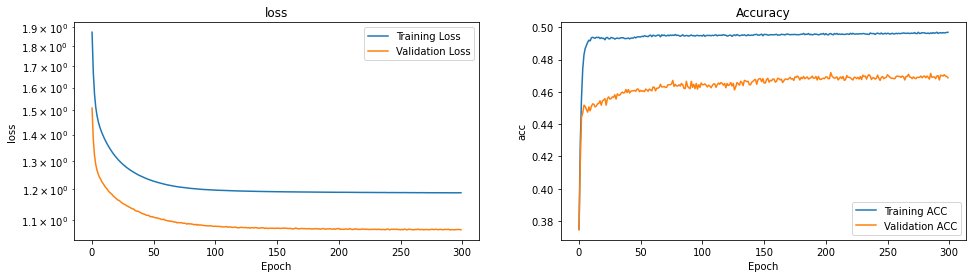

In [107]:
# We can also look at the optimisation history
train_loss = np.array(train_loss_lr)
valid_loss = np.array(valid_loss_lr)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=plt.figaspect(0.25))
ax1.plot(np.nanmean(train_loss,axis=0), label='Training Loss')
ax1.plot(np.nanmean(valid_loss,axis=0), label='Validation Loss')
ax1.set_yscale('log')
ax1.set_title('loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(np.nanmean(train_acc_lr,axis=0), label='Training ACC')
ax2.plot(np.nanmean(valid_acc_lr,axis=0), label='Validation ACC')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('acc')
ax2.legend()
#plt.savefig('precip_accur_loss_week1_lr_t1.png')

In [214]:
from sklearn.calibration import calibration_curve
def metrics_plot(bss_tr,bss_va,bss_te,calib_y_te,calib_x_te,rpss_tr,rpss_va,fig_name):
    # BSS
    train_bss = np.nanmean(bss_tr)
    valid_bss = np.nanmean(bss_va)
    #test_bss = np.nanmean(bss_te)
    print(train_bss,valid_bss)
    
    train_bss_std = np.std(bss_tr)
    valid_bss_std = np.std(bss_va)
    #test_std = np.std(bss_te)
    
    # RPSS
    train_rpss = np.nanmean(rpss_tr)
    valid_rpss = np.nanmean(rpss_va)
    print(train_bss,valid_bss)
    
    train_rpss_std = np.std(rpss_tr)
    valid_rpss_std = np.std(rpss_va)
    
    # reliability diagram
    calib_y = []
    calib_x = []
    for ii in range(len(calib_y_te)):
        ytmp = list(calib_y_te[ii])
        xtmp = list(calib_x_te[ii])
        while len(ytmp) < 10:
            ytmp.append(np.nan)
            xtmp.append(np.nan)
        calib_y.append(ytmp)
        calib_x.append(xtmp)
    calib_y = np.nanmean(calib_y,axis=0)
    calib_x = np.nanmean(calib_x,axis=0)
    fig1, ax1 = plt.subplots()
    plt.plot(calib_y, calib_x, marker='o', color="darkorange", label='NN')
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--", label='Best score')
    plt.text(0.05, 0.95, 'BSS: '+str(round(valid_bss,2)))
    plt.text(0.05, 0.90, 'std: '+str(round(valid_bss_std,2)))
    plt.text(0.05, 0.85, 'RPSS: '+str(round(valid_rpss,2)))
    plt.text(0.05, 0.80, 'std: '+str(round(valid_rpss_std,2)))
    plt.savefig(fig_name)

0.1853365445781821 0.014986706576926632
0.1853365445781821 0.014986706576926632
0.1008931193271185 -0.05583013377467789
0.1008931193271185 -0.05583013377467789
0.2722106640139196 0.037049404827812715
0.2722106640139196 0.037049404827812715


/tmp/ipykernel_55417/4220087004.py:32: RuntimeWarning: Mean of empty slice
  calib_y = np.nanmean(calib_y,axis=0)
/tmp/ipykernel_55417/4220087004.py:33: RuntimeWarning: Mean of empty slice
  calib_x = np.nanmean(calib_x,axis=0)
/tmp/ipykernel_55417/4220087004.py:32: RuntimeWarning: Mean of empty slice
  calib_y = np.nanmean(calib_y,axis=0)
/tmp/ipykernel_55417/4220087004.py:33: RuntimeWarning: Mean of empty slice
  calib_x = np.nanmean(calib_x,axis=0)


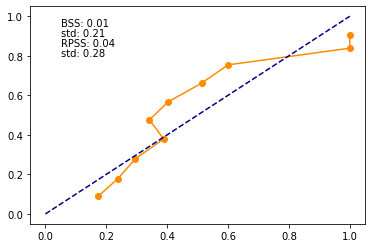

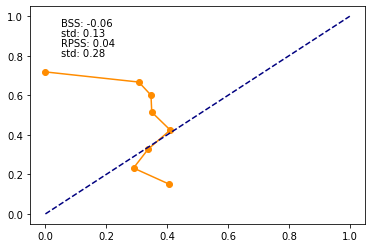

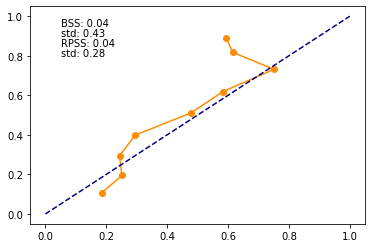

In [216]:
fig_name = 'precip_reliab_stat_index_1d_week4_lr_1.png'
metrics_plot(bss_tr1_lr,bss_va1_lr,bss_te1_lr,calib_y_va1_lr,calib_x_va1_lr,rpss_tr_lr,rpss_va_lr,fig_name)
fig_name = 'precip_reliab_stat_index_1d_week4_lr_2.png'
metrics_plot(bss_tr2_lr,bss_va2_lr,bss_te2_lr,calib_y_va2_lr,calib_x_va2_lr,rpss_tr_lr,rpss_va_lr,fig_name)
fig_name = 'precip_reliab_stat_index_1d_week4_lr_3.png'
metrics_plot(bss_tr3_lr,bss_va3_lr,bss_te3_lr,calib_y_va3_lr,calib_x_va3_lr,rpss_tr_lr,rpss_va_lr,fig_name)

In [217]:
def acc_plot(f1_tr,f1_va,f1_te,rec_tr,rec_va,rec_te,prec_tr,prec_va,prec_te,
             acc_tr,acc_va,acc_te,fign1,fign2,fign3):
    f1_tr = np.array(f1_tr)
    f1_va = np.array(f1_va)
    f1_te = np.array(f1_te)
    rec_tr = np.array(rec_tr)
    rec_va = np.array(rec_va)
    rec_te = np.array(rec_te)
    prec_tr = np.array(prec_tr)
    prec_va = np.array(prec_va)
    prec_te = np.array(prec_te)

    fig1, ax1 = plt.subplots()
    ax1.set_title('performance')
    dat_plot = [acc_tr, acc_va, prec_tr[:,0], prec_va[:,0], rec_tr[:,0], rec_va[:,0], f1_tr[:,0], f1_va[:,0]]
    labels = ['acc', 'acc', 'precision', 'precision', 'recall', 'recall', 'F1', 'F1']
    bplot = ax1.boxplot(dat_plot, labels=labels, patch_artist=True)
    colors = ['lightblue', 'lightgreen', 'lightblue', 'lightgreen', 'lightblue', 'lightgreen', 'lightblue', 'lightgreen']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_fc(color)
    plt.savefig(fign1)

    fig1, ax1 = plt.subplots()
    ax1.set_title('performance')
    dat_plot = [acc_tr, acc_va, prec_tr[:,1], prec_va[:,1], rec_tr[:,1], rec_va[:,1], f1_tr[:,1], f1_va[:,1]]
    labels = ['acc', 'acc', 'precision', 'precision', 'recall', 'recall', 'F1', 'F1']
    bplot = ax1.boxplot(dat_plot, labels=labels, patch_artist=True)
    colors = ['lightblue', 'lightgreen', 'lightblue', 'lightgreen', 'lightblue', 'lightgreen', 'lightblue', 'lightgreen']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_fc(color)
    plt.savefig(fign2)

    fig1, ax1 = plt.subplots()
    ax1.set_title('performance')
    dat_plot = [acc_tr, acc_va, prec_tr[:,2], prec_va[:,2], rec_tr[:,2], rec_va[:,2], f1_tr[:,2], f1_va[:,2]]
    labels = ['acc', 'acc', 'precision', 'precision', 'recall', 'recall', 'F1', 'F1']
    bplot = ax1.boxplot(dat_plot, labels=labels, patch_artist=True)
    colors = ['lightblue', 'lightgreen', 'lightblue', 'lightgreen', 'lightblue', 'lightgreen', 'lightblue', 'lightgreen']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_fc(color)
    plt.savefig(fign3)

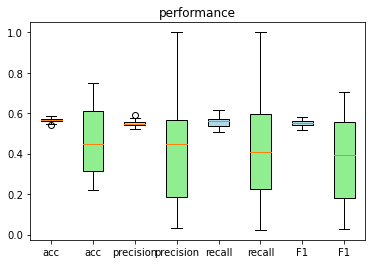

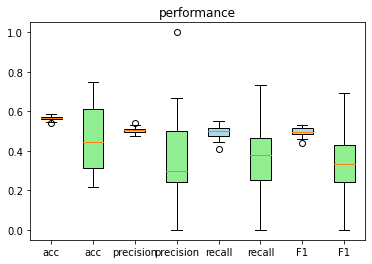

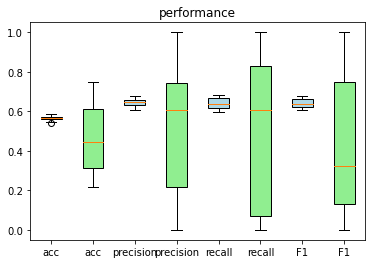

In [218]:
fign1 = 'precip_metrics_stat_index_1d_week4_lr_1.png'
fign2 = 'precip_metrics_stat_index_1d_week4_lr_2.png'
fign3 = 'precip_metrics_stat_index_1d_week4_lr_3.png'
acc_plot(f1_tr_lr,f1_va_lr,f1_te_lr,rec_tr_lr,rec_va_lr,rec_te_lr,
         prec_tr_lr,prec_va_lr,prec_te_lr,acc_tr_lr,acc_va_lr,acc_te_lr,fign1,fign2,fign3)

In [219]:
rec_va_lr = np.array(rec_va_lr)
prec_va_lr = np.array(prec_va_lr)
f1_va_lr = np.array(f1_va_lr)
acc_va_lr = np.array(acc_va_lr)
bss_va3_lr = np.array(bss_va3_lr)
bss_va1_lr = np.array(bss_va1_lr)
rpss_va_lr = np.array(rpss_va_lr)
rec_tr_lr = np.array(rec_tr_lr)
prec_tr_lr = np.array(prec_tr_lr)
f1_tr_lr = np.array(f1_tr_lr)
acc_tr_lr = np.array(acc_tr_lr)
bss_tr3_lr = np.array(bss_tr3_lr)
bss_tr1_lr = np.array(bss_tr1_lr)
rpss_tr_lr = np.array(rpss_tr_lr)

In [220]:
Lead_num=28
f_va={'recall_va':rec_va_lr[:,2], 'precision_va':prec_va_lr[:,2], 'f1_va':f1_va_lr[:,2], 
 'acc_va':acc_va_lr,'bss_va':bss_va3_lr, 'rpss_va':rpss_va_lr, 'calib_y_va_sel':calib_y_va3_lr, 'calib_x_va_sel':calib_x_va3_lr}
np.save(root_results+'Flood_'+'scores_valid_Lead'+str(Lead_num)+'_CLIM0.3_lr.npy',f_va)

d_va={'recall_va':rec_va_lr[:,0], 'precision_va':prec_va_lr[:,0], 'f1_va':f1_va_lr[:,0], 
 'acc_va':acc_va_lr,'bss_va':bss_va1_lr, 'rpss_va':rpss_va_lr, 'calib_y_va_sel':calib_y_va1_lr, 'calib_x_va_sel':calib_x_va1_lr}
np.save(root_results+'Drought_'+'scores_valid_Lead'+str(Lead_num)+'_CLIM0.3_lr.npy',d_va)

f_tr={'recall_tr':rec_tr_lr[:,2], 'precision_tr':prec_tr_lr[:,2], 'f1_tr':f1_tr_lr[:,2], 
 'acc_tr':acc_tr_lr,'bss_tr':bss_tr3_lr, 'rpss_tr':rpss_tr_lr, 'calib_y_tr_sel':calib_y_tr3_lr, 'calib_x_tr_sel':calib_x_tr3_lr}
np.save(root_results+'Flood_'+'scores_train_Lead'+str(Lead_num)+'_CLIM0.3_lr.npy',f_tr)

d_tr={'recall_tr':rec_tr_lr[:,0], 'precision_tr':prec_tr_lr[:,0], 'f1_tr':f1_tr_lr[:,0], 
 'acc_tr':acc_tr_lr,'bss_tr':bss_tr1_lr, 'rpss_tr':rpss_tr_lr, 'calib_y_tr_sel':calib_y_tr1_lr, 'calib_x_tr_sel':calib_x_tr1_lr}
np.save(root_results+'Drought_'+'scores_train_Lead'+str(Lead_num)+'_CLIM0.3_lr.npy',d_tr)

In [53]:
import json
Lead_num=0
datafn = root_results+'Flood_'+'scores_valid_Lead'+str(Lead_num)+'_lag_60d_lr.npy'
tmp = np.load(datafn,allow_pickle=True)
tmp=tmp.tolist()
tmp

{'recall_va': array([0.75      , 0.8627451 , 0.        , 0.        , 0.        ,
        0.3030303 , 1.        , 0.3902439 , 0.54545455, 0.78571429,
        0.        , 0.325     , 0.83116883, 0.73239437, 0.        ,
        0.82051282, 1.        , 0.36363636, 0.25      , 0.09302326,
        0.5       , 0.82758621, 0.83076923, 0.97826087, 1.        ,
        0.8255814 , 0.48076923, 0.5       , 0.74285714]),
 'precision_va': array([0.75      , 0.73333333, 0.        , 0.        , 0.        ,
        0.17857143, 0.15625   , 0.94117647, 0.6122449 , 0.19642857,
        0.        , 0.54166667, 0.74418605, 0.8125    , 0.        ,
        1.        , 1.        , 1.        , 1.        , 0.36363636,
        0.66666667, 0.57831325, 0.56842105, 0.61643836, 0.77631579,
        0.76344086, 0.43859649, 0.54545455, 0.54166667]),
 'f1_va': array([0.75      , 0.79279279, 0.        , 0.        , 0.        ,
        0.2247191 , 0.27027027, 0.55172414, 0.57692308, 0.31428571,
        0.        , 0.40625   

In [161]:
callback_paths = '/s2s_nobackup/mpyrina/New_runs_ind_shal/Lead_0d/Run48/weight_3cat_comb48_9'
tf_model = tf.keras.models.load_model(callback_paths)
tf_model

In [170]:
dummy = predictor_array.Index
y_all_2d = keras.utils.to_categorical(Y_train-1)
tmp = np.ndarray((1920,60,6))
for ii in range(6):
    tmp[:,:,ii] = dummy.values[:,ii,:]
print(tmp.shape)

(1920, 60, 6)


(60, 6)
(60, 6)
1/1 [==============================] - 0s 26ms/step


array([[0.35939628, 0.31695232, 0.32365143]], dtype=float32)

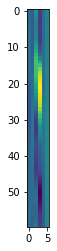

In [174]:
expind = 10
pca_input = tmp[expind,:,:]
print(pca_input.shape)
plt.imshow(pca_input)
tf_model.input_size = pca_input.shape
print(pca_input.shape)
tf_model.predict(pca_input[np.newaxis,:,:])

In [175]:
def generate_masks(N, s, p1, model):
    cell_size = np.ceil(np.array(model.input_size) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *model.input_size))

    for i in tqdm(range(N), desc='Generating masks'):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + model.input_size[0], y:y + model.input_size[1]]
    masks = masks.reshape(-1, *model.input_size, 1)
    return masks

In [177]:
batch_size = 100
from skimage.transform import resize
from tqdm import tqdm
def explain(N, model, inp, masks):
    preds = []
    p1 = 0.5
    # Make sure multiplication is being done for correct axes
    masked = inp * masks
    for i in tqdm(range(0, len(masks), batch_size), desc='Explaining'):
        preds.append(model.predict(masked[i:min(i+batch_size, len(masks))]))
    preds = np.concatenate(preds)
    sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, *model.input_size)
    sal = sal / N / p1
    return sal

Explaining:   0%|                                        | 0/10 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


Explaining:  20%|██████▍                         | 2/10 [00:00<00:00, 14.26it/s]

4/4 [==============================] - 0s 5ms/step


Explaining:  40%|████████████▊                   | 4/10 [00:00<00:00, 14.56it/s]

4/4 [==============================] - 0s 5ms/step


Explaining:  60%|███████████████████▏            | 6/10 [00:00<00:00, 14.71it/s]

4/4 [==============================] - 0s 5ms/step


Explaining:  80%|█████████████████████████▌      | 8/10 [00:00<00:00, 14.36it/s]

4/4 [==============================] - 0s 4ms/step


Explaining: 100%|███████████████████████████████| 10/10 [00:00<00:00, 14.55it/s]


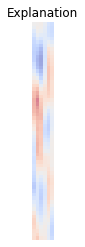

In [181]:
masks = generate_masks(1000, 8, 0.5, tf_model)[:,:,:,0]
sal = explain(1000, tf_model, pca_input, masks)
fig = plt.figure(figsize=(6,4))
plt.subplot(1,3,1)
plt.title('Explanation')
plt.axis('off')
plt.imshow(sal[1], cmap='coolwarm', alpha=0.5)

## modeling with an LSTM

In [20]:
from models import build_lstm
from models import build_CNN
from models import class_weight_creator
from train import get_train_test_val, cross_valid_one_out
from train import train_model

In [24]:
# train the lstm
#del model_history
from random import sample as random_s
NY_train = 30 # its not used
recall_tr1, precision_tr1, f1_tr1, acc_tr1, bss_tr1, bs_tr1, calib_y_tr1, calib_x_tr1 = [],[],[],[],[],[],[],[]
recall_tr2, precision_tr2, f1_tr2, acc_tr2, bss_tr2, bs_tr2, calib_y_tr2, calib_x_tr2 = [],[],[],[],[],[],[],[]
recall_tr3, precision_tr3, f1_tr3, acc_tr3, bss_tr3, bs_tr3, calib_y_tr3, calib_x_tr3 = [],[],[],[],[],[],[],[]
recall_tr4, precision_tr4, f1_tr4, acc_tr4, bss_tr4, bs_tr4, calib_y_tr4, calib_x_tr4 = [],[],[],[],[],[],[],[]

recall_va1, precision_va1, f1_va1, acc_va1, bss_va1, bs_va1, calib_y_va1, calib_x_va1 = [],[],[],[],[],[],[],[]
recall_va2, precision_va2, f1_va2, acc_va2, bss_va2, bs_va2, calib_y_va2, calib_x_va2 = [],[],[],[],[],[],[],[]
recall_va3, precision_va3, f1_va3, acc_va3, bss_va3, bs_va3, calib_y_va3, calib_x_va3 = [],[],[],[],[],[],[],[]
recall_va4, precision_va4, f1_va4, acc_va4, bss_va4, bs_va4, calib_y_va4, calib_x_va4 = [],[],[],[],[],[],[],[]

loss_tr, loss_va = [],[]
metri_tr, metri_va = [],[]

import random
NS = 10
#select_ind = random.sample(list(np.arange(EYY-SYY+1-5)), NS) #it selects NS indices our of 35
for ii in range(NS):
    model = build_lstm(ntimestep, nfeature, layers=2, neurons=[66,35], regval=[0.1,0.05], out_neurons=n_cat+1)
    #train_X, train_y, val_X, val_y = cross_valid_one_out(X_all, y_all, all_years, val_year_ind=ii)
    val_year = [SYY+ii,SYY+ii+1]
    train_X, train_y, val_X, val_y = cross_valid_n_out(X_all_n, y_all_n, all_years, val_year=val_year)
    
    train_y_tmp = train_y.values
    class_weight = class_weight_creator(train_y_tmp)
    callbacks_path = root_results+'tmp/Run20/weight_4cat_'+str(ii+1)
    history_path = root_results+'tmp/Run20/history_4cat_'+str(ii+1)
    batch_size = 64
    epochs = 100
    model_history = train_model(model, train_X, train_y, val_X, val_y, callbacks_path, epochs, batch_size, class_weight)
    loss_tr.append(model_history.history['loss'])
    loss_va.append(model_history.history['val_loss'])
    metri_tr.append(model_history.history['accuracy'])
    metri_va.append(model_history.history['val_accuracy'])
    
    # train score
    #ref_prob = clim_pr_y[0:int(train_y[:,1].shape[0])]
    #print(ref_prob.shape)
    y_prob = model.predict(train_X); #y_pred = np.argmax(y_prob,axis=1)
    #print('y prediction shape', y_pred.shape)
    nbins = 10
    
    recall, precision, f1, acc, bs, bss, calib_y, calib_x = score(np.argmax(train_y,axis=1), train_y[:,1], np.argmax(y_prob,axis=1), 
                                                    y_prob[:,1], nbins, clim_pr_y_cat1[0:int(train_y[:,1].shape[0])])
    recall_tr1.append(recall); precision_tr1.append(precision); f1_tr1.append(f1)
    acc_tr1.append(acc); bs_tr1.append(bs); bss_tr1.append(bss)
    calib_y_tr1.append(calib_y); calib_x_tr1.append(calib_x)
    
    recall, precision, f1, acc, bs, bss, calib_y, calib_x = score(np.argmax(train_y,axis=1), train_y[:,2], np.argmax(y_prob,axis=1), y_prob[:,2], nbins, 
                                                                  clim_pr_y_cat3[0:int(train_y[:,2].shape[0])])
    recall_tr3.append(recall); precision_tr3.append(precision); f1_tr3.append(f1)
    acc_tr3.append(acc); bs_tr3.append(bs); bss_tr3.append(bss)
    calib_y_tr3.append(calib_y); calib_x_tr3.append(calib_x)
    
    recall, precision, f1, acc, bs, bss, calib_y, calib_x = score(np.argmax(train_y,axis=1), train_y[:,3], np.argmax(y_prob,axis=1), y_prob[:,3], nbins, 
                                                                  clim_pr_y_cat4[0:int(train_y[:,3].shape[0])])
    recall_tr4.append(recall); precision_tr4.append(precision); f1_tr4.append(f1)
    acc_tr4.append(acc); bs_tr4.append(bs); bss_tr4.append(bss)
    calib_y_tr4.append(calib_y); calib_x_tr4.append(calib_x)
    
    # validation score
    y_prob = model.predict(val_X); #y_pred = np.argmax(y_prob,axis=1)
    nbins = 10
    
    recall, precision, f1, acc, bs, bss, calib_y, calib_x = score(np.argmax(val_y,axis=1), val_y[:,1], np.argmax(y_prob,axis=1),
                                                    y_prob[:,1], nbins, clim_pr_y_cat1[0:int(val_y[:,1].shape[0])])
    recall_va1.append(recall); precision_va1.append(precision); f1_va1.append(f1)
    acc_va1.append(acc); bs_va1.append(bs); bss_va1.append(bss)
    calib_y_va1.append(calib_y); calib_x_va1.append(calib_x)
    
    recall, precision, f1, acc, bs, bss, calib_y, calib_x = score(np.argmax(val_y,axis=1), val_y[:,2], np.argmax(y_prob,axis=1),
                                                    y_prob[:,2], nbins, clim_pr_y_cat3[0:int(val_y[:,2].shape[0])])
    recall_va3.append(recall); precision_va3.append(precision); f1_va3.append(f1)
    acc_va3.append(acc); bs_va3.append(bs); bss_va3.append(bss)
    calib_y_va3.append(calib_y); calib_x_va3.append(calib_x)
    
    recall, precision, f1, acc, bs, bss, calib_y, calib_x = score(np.argmax(val_y,axis=1), val_y[:,3], np.argmax(y_prob,axis=1),
                                                    y_prob[:,3], nbins, clim_pr_y_cat4[0:int(val_y[:,3].shape[0])])
    recall_va4.append(recall); precision_va4.append(precision); f1_va4.append(f1)
    acc_va4.append(acc); bs_va4.append(bs); bss_va4.append(bss)
    calib_y_va4.append(calib_y); calib_x_va4.append(calib_x)
    
    tf.keras.backend.clear_session()
    print('bss_va1 print',bss_va1)
    print('bss_va3 print',bss_va3)
    print('bss_va4 print',bss_va4)

layer 2
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 4)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 60, 66)            18744     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 35)            14280     
_________________________________________________________________
attention_with_context (Atte ((None, 60, 35), (None, 6 1295      
_________________________________________________________________
addition (Addition)          (None, 35)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 144       
_________________________________________________________________
dense_1 (Dense)              (None, 4)               

/net/cfc/s2s/zhengwu/code/models.py:271: RuntimeWarning: divide by zero encountered in true_divide
  weights = np.max(np.sum(Y, axis=0)) / np.sum(Y, axis=0)


52/52 [==============================] - 8s 82ms/step - loss: 5.7816 - accuracy: 0.3538 - val_loss: 3.1268 - val_accuracy: 0.4186
INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_4cat_1/assets
Epoch 2/100
52/52 [==============================] - 4s 70ms/step - loss: 2.9412 - accuracy: 0.3857 - val_loss: 1.8099 - val_accuracy: 0.5174
INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_4cat_1/assets
Epoch 3/100
52/52 [==============================] - 4s 79ms/step - loss: 1.9168 - accuracy: 0.3936 - val_loss: 1.3589 - val_accuracy: 0.4651
INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_4cat_1/assets
Epoch 4/100
52/52 [==============================] - 4s 67ms/step - loss: 1.5401 - accuracy: 0.4091 - val_loss: 1.2021 - val_accuracy: 0.4128
INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_4cat_1/assets
Epoch 5/100
52/52 [=====

KeyboardInterrupt: 

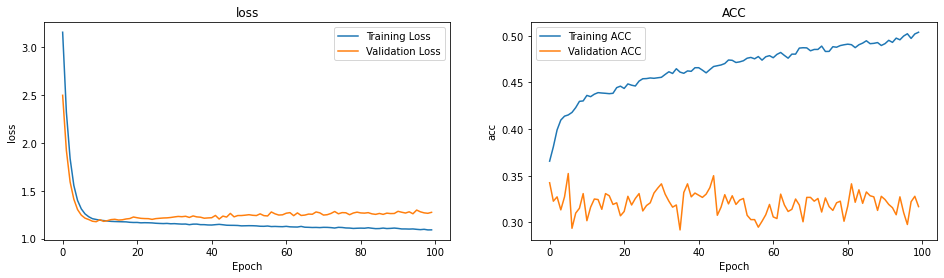

In [35]:
# We can also look at the optimisation history
train_loss = np.array(loss_tr)
valid_loss = np.array(loss_va)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=plt.figaspect(0.25))
ax1.plot(np.nanmean(train_loss,axis=0), label='Training Loss')
ax1.plot(np.nanmean(valid_loss,axis=0), label='Validation Loss')
ax1.set_title('loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(np.nanmean(metri_tr,axis=0), label='Training ACC')
ax2.plot(np.nanmean(metri_va,axis=0), label='Validation ACC')
ax2.set_title('ACC')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('acc')
ax2.legend()

In [36]:
print(np.mean(bss_tr1), np.sum(np.array(bss_tr1) >= 0, axis=0), np.mean(bss_va1), np.sum(np.array(bss_va1) >= 0, axis=0))
print(np.mean(bss_tr3), np.sum(np.array(bss_tr3) >= 0, axis=0), np.mean(bss_va3), np.sum(np.array(bss_va3) >= 0, axis=0))
print(np.mean(bss_tr4), np.sum(np.array(bss_tr4) >= 0, axis=0), np.mean(bss_va4), np.sum(np.array(bss_va4) >= 0, axis=0))
print('Brier Skill score std')
print('validation BSS-std: ',np.std(bss_va1,ddof=1))
print('validation BSS-std: ',np.std(bss_va3,ddof=1))
print('validation BSS-std: ',np.std(bss_va4,ddof=1))

0.1496490377657321 10 -0.1774735952122481 2
-0.014039818243660651 1 -0.04453386507004695 0
0.25750504777282646 10 -0.3404276573540068 4
Brier Skill score std
validation BSS-std:  0.18194772760421027
validation BSS-std:  0.040803453723589386
validation BSS-std:  0.4881124483244908


recall
train:  0.5157282741738066 validation:  0.3168604651162791
precision
train:  0.5157282741738066 validation:  0.3168604651162791
F1-score
train:  0.5157282741738066 validation:  0.3168604651162791
accuracy
train:  0.5157282741738066 validation:  0.3168604651162791
Brier Skill
Brier Skill score
train:  0.25750504777282646 validation:  -0.3404276573540068


/net/cfc/s2s/s2s_ai_challenge/conda/envs/s2sai_2020/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice
/net/cfc/s2s/s2s_ai_challenge/conda/envs/s2sai_2020/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/net/cfc/s2s/s2s_ai_challenge/conda/envs/s2sai_2020/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice
/net/cfc/s2s/s2s_ai_challenge/conda/envs/s2sai_2020/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice


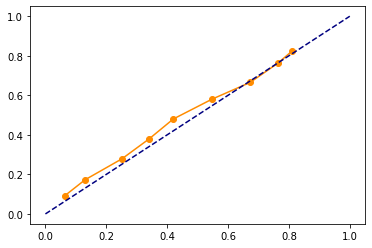

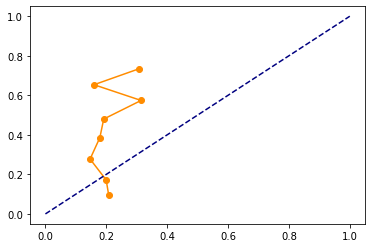

In [37]:
# mean of all cross validation output

recall_tr = recall_tr1
recall_va = recall_va1
precision_tr = precision_tr1
precision_va = precision_va1
f1_tr = f1_tr1
f1_va = f1_va1
acc_tr = acc_tr1
acc_va = acc_va1
bss_tr = bss_tr4
bss_va = bss_va4
calib_y_tr = calib_y_tr4
calib_x_tr = calib_x_tr4
calib_y_va = calib_y_va4
calib_x_va = calib_x_va4

print('recall')
print('train: ',np.nanmean(recall_tr), 'validation: ',np.nanmean(recall_va))
print('precision')
print('train: ',np.nanmean(precision_tr), 'validation: ',np.nanmean(precision_va))
print('F1-score')
print('train: ',np.nanmean(f1_tr), 'validation: ',np.nanmean(f1_va))
print('accuracy')
print('train: ',np.nanmean(acc_tr), 'validation: ',np.nanmean(acc_va))
print('Brier Skill')
#print('train: ',np.nanmean(bs_tr), 'validation: ',np.nanmean(bs_va))
print('Brier Skill score')
print('train: ',np.nanmean(bss_tr), 'validation: ',np.nanmean(bss_va))

calib_y = []
calib_x = []
for ii in range(len(calib_y_tr)):
    ytmp = list(calib_y_tr[ii])
    xtmp = list(calib_x_tr[ii])
    while len(ytmp) < nbins:
        ytmp.append(np.nan)
        xtmp.append(np.nan)
    calib_y.append(ytmp)
    calib_x.append(xtmp)
calib_y = np.nanmean(calib_y,axis=0)
calib_x = np.nanmean(calib_x,axis=0)
fig = plt.figure(figsize=(6,4))
visualization.plot_calibration_curve(calib_x, calib_y)
# due the only one year data, the data point in calib_y and calib_x are not always equal to nbins=10
calib_y = []
calib_x = []
for ii in range(len(calib_y_va)):
    ytmp = list(calib_y_va[ii])
    xtmp = list(calib_x_va[ii])
    while len(ytmp) < nbins:
        ytmp.append(np.nan)
        xtmp.append(np.nan)
    calib_y.append(ytmp)
    calib_x.append(xtmp)
calib_y = np.nanmean(calib_y,axis=0)
calib_x = np.nanmean(calib_x,axis=0)
fig = plt.figure(figsize=(6,4))
visualization.plot_calibration_curve(calib_x, calib_y)

recall
train:  0.5157282741738066 validation:  0.3168604651162791
precision
train:  0.5157282741738066 validation:  0.3168604651162791
F1-score
train:  0.5157282741738066 validation:  0.3168604651162791
accuracy
train:  0.5157282741738066 validation:  0.3168604651162791
Brier Skill
Brier Skill score
train:  0.1496490377657321 validation:  -0.1774735952122481


/net/cfc/s2s/s2s_ai_challenge/conda/envs/s2sai_2020/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/net/cfc/s2s/s2s_ai_challenge/conda/envs/s2sai_2020/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/net/cfc/s2s/s2s_ai_challenge/conda/envs/s2sai_2020/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
/net/cfc/s2s/s2s_ai_challenge/conda/envs/s2sai_2020/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice


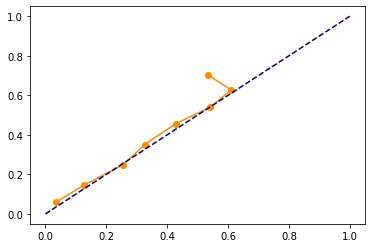

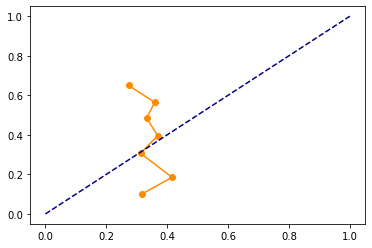

In [38]:
acc_tr = acc_tr1
acc_va = acc_va1
bss_tr = bss_tr1
bss_va = bss_va1
calib_y_tr = calib_y_tr1
calib_x_tr = calib_x_tr1
calib_y_va = calib_y_va1
calib_x_va = calib_x_va1

print('recall')
print('train: ',np.nanmean(recall_tr), 'validation: ',np.nanmean(recall_va))
print('precision')
print('train: ',np.nanmean(precision_tr), 'validation: ',np.nanmean(precision_va))
print('F1-score')
print('train: ',np.nanmean(f1_tr), 'validation: ',np.nanmean(f1_va))
print('accuracy')
print('train: ',np.nanmean(acc_tr), 'validation: ',np.nanmean(acc_va))
print('Brier Skill')
#print('train: ',np.nanmean(bs_tr), 'validation: ',np.nanmean(bs_va))
print('Brier Skill score')
print('train: ',np.nanmean(bss_tr), 'validation: ',np.nanmean(bss_va))

calib_y = []
calib_x = []
for ii in range(len(calib_y_tr)):
    ytmp = list(calib_y_tr[ii])
    xtmp = list(calib_x_tr[ii])
    while len(ytmp) < nbins:
        ytmp.append(np.nan)
        xtmp.append(np.nan)
    calib_y.append(ytmp)
    calib_x.append(xtmp)
calib_y = np.nanmean(calib_y,axis=0)
calib_x = np.nanmean(calib_x,axis=0)
fig = plt.figure(figsize=(6,4))
visualization.plot_calibration_curve(calib_x, calib_y)
# due the only one year data, the data point in calib_y and calib_x are not always equal to nbins=10
calib_y = []
calib_x = []
for ii in range(len(calib_y_va)):
    ytmp = list(calib_y_va[ii])
    xtmp = list(calib_x_va[ii])
    while len(ytmp) < nbins:
        ytmp.append(np.nan)
        xtmp.append(np.nan)
    calib_y.append(ytmp)
    calib_x.append(xtmp)
calib_y = np.nanmean(calib_y,axis=0)
calib_x = np.nanmean(calib_x,axis=0)
fig = plt.figure(figsize=(6,4))
visualization.plot_calibration_curve(calib_x, calib_y)

### CNN-LSTM

In [37]:
# Predictor data preprocessing
# can select the values and region you want by changing the parameters
from preprocess import get_principle_components_and_EOFs

# Run the function
s_target_date='04-10-1981'
e_target_date='28-12-2020' # end of year - approximatelly 14 days

# if eof is 15 days centered then rw_1=7 # If eof is 15 days NOT-centered then rw_1=15
rw_1 = 3 # half eof smoothing
lead_time = 14 # days until valid_time starts
rw = 7 # data full smoothing value (gets half in function), because the data are centered, otherwise set to 0

# LSTM timestep
ntimestep = 60 # lags to consider for the lstm
target_len = len(tp_target) # len(tp_target)

drop_OND_years = [1970, 1971, 1972, 1973, 1974] # fake years to drop because we dont want to do any drop currently

root_data = '/s2s_nobackup/zhengwu/workshop/'
file_vars = ['ERA5_t2m', 'sst']
header_vars = ['t2m', 'sst']
output_vars = [1]*2

# select regions for the individual predictor
lon_slices = [[15,60],[-180,180],[-180,180]]
lat_slices = [[30,-15],[60,-60],[-20,50]]

predictors = []
for file_var, header_var, lon_slice, lat_slice in zip (file_vars, header_vars, lon_slices, lat_slices):
    if file_var == 'era5_olr':
        file = xr.open_dataset(root_data+file_var+'_1950_2021_daily_1deg_tropics.nc')
        #print('olr')
    else:
        file = xr.open_dataset(root_data+file_var+'_1959-2021_1_12_daily_2.0deg.nc')
        #print(header_var)

    if "longitude" in file.coords:
        file = file.rename({"longitude": "lon","latitude": "lat"})

    assert "lat" in file.coords
    assert "lon" in file.coords
    print('lat lon exist')
    
    # select region
    var_dim = file.sel(lon=slice(lon_slice[0],lon_slice[1]),lat=slice(lat_slice[0],lat_slice[1]))
    
    
    var_series = var_dim.sel(time=var_dim.time.dt.year.isin([np.arange(SYY,EYY+1)])).rolling(time=7, center=True).mean(skipna=True)
    var_series = var_series.sel(time=var_series.time.dt.year.isin(all_years))

    # remove climatology
    var_anom_series = var_series.groupby("time.dayofyear") - var_series.groupby("time.dayofyear").mean("time",skipna=True)
    var_norm_series = var_anom_series.groupby("time.dayofyear") / var_anom_series.groupby("time.dayofyear").std("time",skipna=True)
    print(var_norm_series)
    
    predictor_array=sel_train_data_lead(var_norm_series, target_len, s_target_date, e_target_date,
                    rw_1, lead_time, rw, ntimestep, drop_OND_years)
    if file_var == 'ERA5_t2m':
        output_vars[0] = predictor_array
    elif file_var == 'sst':
        output_vars[1] = predictor_array
    print(predictor_array)

lat lon exist
<xarray.Dataset>
Dimensions:    (lat: 23, lon: 23, time: 14610)
Coordinates:
  * lat        (lat) float32 30.0 28.0 26.0 24.0 22.0 ... -8.0 -10.0 -12.0 -14.0
  * lon        (lon) float32 16.0 18.0 20.0 22.0 24.0 ... 54.0 56.0 58.0 60.0
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2020-12-31
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365 366
Data variables:
    t2m        (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
starting
start target date 4 10 1981
end target 28 12 2020
1981.10.04 1981.07.17 1981.09.14 0
1981.10.05 1981.07.18 1981.09.15 1
1981.10.06 1981.07.19 1981.09.16 1
1981.10.07 1981.07.20 1981.09.17 1
1981.10.08 1981.07.21 1981.09.18 1
1981.10.09 1981.07.22 1981.09.19 1
1981.10.10 1981.07.23 1981.09.20 1
1981.10.11 1981.07.24 1981.09.21 1
1981.10.12 1981.07.25 1981.09.22 1
1981.10.13 1981.07.26 1981.09.23 1
1981.10.14 1981.07.27 1981.09.24 1
1981.10.15 1981.07.28 1981.09.25 1
1981.10.16 1981.07.29

1983.12.10 1983.09.22 1983.11.20 1
1983.12.11 1983.09.23 1983.11.21 1
1983.12.12 1983.09.24 1983.11.22 1
1983.12.13 1983.09.25 1983.11.23 1
1983.12.14 1983.09.26 1983.11.24 1
1983.12.15 1983.09.27 1983.11.25 1
1983.12.16 1983.09.28 1983.11.26 1
1983.12.17 1983.09.29 1983.11.27 1
1983.12.18 1983.09.30 1983.11.28 1
1983.12.19 1983.10.01 1983.11.29 1
1983.12.20 1983.10.02 1983.11.30 1
1983.12.21 1983.10.03 1983.12.01 1
1983.12.22 1983.10.04 1983.12.02 1
1983.12.23 1983.10.05 1983.12.03 1
1983.12.24 1983.10.06 1983.12.04 1
1983.12.25 1983.10.07 1983.12.05 1
1983.12.26 1983.10.08 1983.12.06 1
1983.12.27 1983.10.09 1983.12.07 1
1983.12.28 1983.10.10 1983.12.08 1
1984.10.04 1984.07.17 1984.09.14 0
1984.10.05 1984.07.18 1984.09.15 1
1984.10.06 1984.07.19 1984.09.16 1
1984.10.07 1984.07.20 1984.09.17 1
1984.10.08 1984.07.21 1984.09.18 1
1984.10.09 1984.07.22 1984.09.19 1
1984.10.10 1984.07.23 1984.09.20 1
1984.10.11 1984.07.24 1984.09.21 1
1984.10.12 1984.07.25 1984.09.22 1
1984.10.13 1984.07.2

1986.11.27 1986.09.09 1986.11.07 1
1986.11.28 1986.09.10 1986.11.08 1
1986.11.29 1986.09.11 1986.11.09 1
1986.11.30 1986.09.12 1986.11.10 1
1986.12.01 1986.09.13 1986.11.11 1
1986.12.02 1986.09.14 1986.11.12 1
1986.12.03 1986.09.15 1986.11.13 1
1986.12.04 1986.09.16 1986.11.14 1
1986.12.05 1986.09.17 1986.11.15 1
1986.12.06 1986.09.18 1986.11.16 1
1986.12.07 1986.09.19 1986.11.17 1
1986.12.08 1986.09.20 1986.11.18 1
1986.12.09 1986.09.21 1986.11.19 1
1986.12.10 1986.09.22 1986.11.20 1
1986.12.11 1986.09.23 1986.11.21 1
1986.12.12 1986.09.24 1986.11.22 1
1986.12.13 1986.09.25 1986.11.23 1
1986.12.14 1986.09.26 1986.11.24 1
1986.12.15 1986.09.27 1986.11.25 1
1986.12.16 1986.09.28 1986.11.26 1
1986.12.17 1986.09.29 1986.11.27 1
1986.12.18 1986.09.30 1986.11.28 1
1986.12.19 1986.10.01 1986.11.29 1
1986.12.20 1986.10.02 1986.11.30 1
1986.12.21 1986.10.03 1986.12.01 1
1986.12.22 1986.10.04 1986.12.02 1
1986.12.23 1986.10.05 1986.12.03 1
1986.12.24 1986.10.06 1986.12.04 1
1986.12.25 1986.10.0

1989.11.13 1989.08.26 1989.10.24 1
1989.11.14 1989.08.27 1989.10.25 1
1989.11.15 1989.08.28 1989.10.26 1
1989.11.16 1989.08.29 1989.10.27 1
1989.11.17 1989.08.30 1989.10.28 1
1989.11.18 1989.08.31 1989.10.29 1
1989.11.19 1989.09.01 1989.10.30 1
1989.11.20 1989.09.02 1989.10.31 1
1989.11.21 1989.09.03 1989.11.01 1
1989.11.22 1989.09.04 1989.11.02 1
1989.11.23 1989.09.05 1989.11.03 1
1989.11.24 1989.09.06 1989.11.04 1
1989.11.25 1989.09.07 1989.11.05 1
1989.11.26 1989.09.08 1989.11.06 1
1989.11.27 1989.09.09 1989.11.07 1
1989.11.28 1989.09.10 1989.11.08 1
1989.11.29 1989.09.11 1989.11.09 1
1989.11.30 1989.09.12 1989.11.10 1
1989.12.01 1989.09.13 1989.11.11 1
1989.12.02 1989.09.14 1989.11.12 1
1989.12.03 1989.09.15 1989.11.13 1
1989.12.04 1989.09.16 1989.11.14 1
1989.12.05 1989.09.17 1989.11.15 1
1989.12.06 1989.09.18 1989.11.16 1
1989.12.07 1989.09.19 1989.11.17 1
1989.12.08 1989.09.20 1989.11.18 1
1989.12.09 1989.09.21 1989.11.19 1
1989.12.10 1989.09.22 1989.11.20 1
1989.12.11 1989.09.2

1992.10.29 1992.08.11 1992.10.09 1
1992.10.30 1992.08.12 1992.10.10 1
1992.10.31 1992.08.13 1992.10.11 1
1992.11.01 1992.08.14 1992.10.12 1
1992.11.02 1992.08.15 1992.10.13 1
1992.11.03 1992.08.16 1992.10.14 1
1992.11.04 1992.08.17 1992.10.15 1
1992.11.05 1992.08.18 1992.10.16 1
1992.11.06 1992.08.19 1992.10.17 1
1992.11.07 1992.08.20 1992.10.18 1
1992.11.08 1992.08.21 1992.10.19 1
1992.11.09 1992.08.22 1992.10.20 1
1992.11.10 1992.08.23 1992.10.21 1
1992.11.11 1992.08.24 1992.10.22 1
1992.11.12 1992.08.25 1992.10.23 1
1992.11.13 1992.08.26 1992.10.24 1
1992.11.14 1992.08.27 1992.10.25 1
1992.11.15 1992.08.28 1992.10.26 1
1992.11.16 1992.08.29 1992.10.27 1
1992.11.17 1992.08.30 1992.10.28 1
1992.11.18 1992.08.31 1992.10.29 1
1992.11.19 1992.09.01 1992.10.30 1
1992.11.20 1992.09.02 1992.10.31 1
1992.11.21 1992.09.03 1992.11.01 1
1992.11.22 1992.09.04 1992.11.02 1
1992.11.23 1992.09.05 1992.11.03 1
1992.11.24 1992.09.06 1992.11.04 1
1992.11.25 1992.09.07 1992.11.05 1
1992.11.26 1992.09.0

1995.10.14 1995.07.27 1995.09.24 1
1995.10.15 1995.07.28 1995.09.25 1
1995.10.16 1995.07.29 1995.09.26 1
1995.10.17 1995.07.30 1995.09.27 1
1995.10.18 1995.07.31 1995.09.28 1
1995.10.19 1995.08.01 1995.09.29 1
1995.10.20 1995.08.02 1995.09.30 1
1995.10.21 1995.08.03 1995.10.01 1
1995.10.22 1995.08.04 1995.10.02 1
1995.10.23 1995.08.05 1995.10.03 1
1995.10.24 1995.08.06 1995.10.04 1
1995.10.25 1995.08.07 1995.10.05 1
1995.10.26 1995.08.08 1995.10.06 1
1995.10.27 1995.08.09 1995.10.07 1
1995.10.28 1995.08.10 1995.10.08 1
1995.10.29 1995.08.11 1995.10.09 1
1995.10.30 1995.08.12 1995.10.10 1
1995.10.31 1995.08.13 1995.10.11 1
1995.11.01 1995.08.14 1995.10.12 1
1995.11.02 1995.08.15 1995.10.13 1
1995.11.03 1995.08.16 1995.10.14 1
1995.11.04 1995.08.17 1995.10.15 1
1995.11.05 1995.08.18 1995.10.16 1
1995.11.06 1995.08.19 1995.10.17 1
1995.11.07 1995.08.20 1995.10.18 1
1995.11.08 1995.08.21 1995.10.19 1
1995.11.09 1995.08.22 1995.10.20 1
1995.11.10 1995.08.23 1995.10.21 1
1995.11.11 1995.08.2

1997.12.26 1997.10.08 1997.12.06 1
1997.12.27 1997.10.09 1997.12.07 1
1997.12.28 1997.10.10 1997.12.08 1
1998.10.04 1998.07.17 1998.09.14 0
1998.10.05 1998.07.18 1998.09.15 1
1998.10.06 1998.07.19 1998.09.16 1
1998.10.07 1998.07.20 1998.09.17 1
1998.10.08 1998.07.21 1998.09.18 1
1998.10.09 1998.07.22 1998.09.19 1
1998.10.10 1998.07.23 1998.09.20 1
1998.10.11 1998.07.24 1998.09.21 1
1998.10.12 1998.07.25 1998.09.22 1
1998.10.13 1998.07.26 1998.09.23 1
1998.10.14 1998.07.27 1998.09.24 1
1998.10.15 1998.07.28 1998.09.25 1
1998.10.16 1998.07.29 1998.09.26 1
1998.10.17 1998.07.30 1998.09.27 1
1998.10.18 1998.07.31 1998.09.28 1
1998.10.19 1998.08.01 1998.09.29 1
1998.10.20 1998.08.02 1998.09.30 1
1998.10.21 1998.08.03 1998.10.01 1
1998.10.22 1998.08.04 1998.10.02 1
1998.10.23 1998.08.05 1998.10.03 1
1998.10.24 1998.08.06 1998.10.04 1
1998.10.25 1998.08.07 1998.10.05 1
1998.10.26 1998.08.08 1998.10.06 1
1998.10.27 1998.08.09 1998.10.07 1
1998.10.28 1998.08.10 1998.10.08 1
1998.10.29 1998.08.1

2000.12.13 2000.09.25 2000.11.23 1
2000.12.14 2000.09.26 2000.11.24 1
2000.12.15 2000.09.27 2000.11.25 1
2000.12.16 2000.09.28 2000.11.26 1
2000.12.17 2000.09.29 2000.11.27 1
2000.12.18 2000.09.30 2000.11.28 1
2000.12.19 2000.10.01 2000.11.29 1
2000.12.20 2000.10.02 2000.11.30 1
2000.12.21 2000.10.03 2000.12.01 1
2000.12.22 2000.10.04 2000.12.02 1
2000.12.23 2000.10.05 2000.12.03 1
2000.12.24 2000.10.06 2000.12.04 1
2000.12.25 2000.10.07 2000.12.05 1
2000.12.26 2000.10.08 2000.12.06 1
2000.12.27 2000.10.09 2000.12.07 1
2000.12.28 2000.10.10 2000.12.08 1
2001.10.04 2001.07.17 2001.09.14 0
2001.10.05 2001.07.18 2001.09.15 1
2001.10.06 2001.07.19 2001.09.16 1
2001.10.07 2001.07.20 2001.09.17 1
2001.10.08 2001.07.21 2001.09.18 1
2001.10.09 2001.07.22 2001.09.19 1
2001.10.10 2001.07.23 2001.09.20 1
2001.10.11 2001.07.24 2001.09.21 1
2001.10.12 2001.07.25 2001.09.22 1
2001.10.13 2001.07.26 2001.09.23 1
2001.10.14 2001.07.27 2001.09.24 1
2001.10.15 2001.07.28 2001.09.25 1
2001.10.16 2001.07.2

2003.12.01 2003.09.13 2003.11.11 1
2003.12.02 2003.09.14 2003.11.12 1
2003.12.03 2003.09.15 2003.11.13 1
2003.12.04 2003.09.16 2003.11.14 1
2003.12.05 2003.09.17 2003.11.15 1
2003.12.06 2003.09.18 2003.11.16 1
2003.12.07 2003.09.19 2003.11.17 1
2003.12.08 2003.09.20 2003.11.18 1
2003.12.09 2003.09.21 2003.11.19 1
2003.12.10 2003.09.22 2003.11.20 1
2003.12.11 2003.09.23 2003.11.21 1
2003.12.12 2003.09.24 2003.11.22 1
2003.12.13 2003.09.25 2003.11.23 1
2003.12.14 2003.09.26 2003.11.24 1
2003.12.15 2003.09.27 2003.11.25 1
2003.12.16 2003.09.28 2003.11.26 1
2003.12.17 2003.09.29 2003.11.27 1
2003.12.18 2003.09.30 2003.11.28 1
2003.12.19 2003.10.01 2003.11.29 1
2003.12.20 2003.10.02 2003.11.30 1
2003.12.21 2003.10.03 2003.12.01 1
2003.12.22 2003.10.04 2003.12.02 1
2003.12.23 2003.10.05 2003.12.03 1
2003.12.24 2003.10.06 2003.12.04 1
2003.12.25 2003.10.07 2003.12.05 1
2003.12.26 2003.10.08 2003.12.06 1
2003.12.27 2003.10.09 2003.12.07 1
2003.12.28 2003.10.10 2003.12.08 1
2004.10.04 2004.07.1

2006.11.11 2006.08.24 2006.10.22 1
2006.11.12 2006.08.25 2006.10.23 1
2006.11.13 2006.08.26 2006.10.24 1
2006.11.14 2006.08.27 2006.10.25 1
2006.11.15 2006.08.28 2006.10.26 1
2006.11.16 2006.08.29 2006.10.27 1
2006.11.17 2006.08.30 2006.10.28 1
2006.11.18 2006.08.31 2006.10.29 1
2006.11.19 2006.09.01 2006.10.30 1
2006.11.20 2006.09.02 2006.10.31 1
2006.11.21 2006.09.03 2006.11.01 1
2006.11.22 2006.09.04 2006.11.02 1
2006.11.23 2006.09.05 2006.11.03 1
2006.11.24 2006.09.06 2006.11.04 1
2006.11.25 2006.09.07 2006.11.05 1
2006.11.26 2006.09.08 2006.11.06 1
2006.11.27 2006.09.09 2006.11.07 1
2006.11.28 2006.09.10 2006.11.08 1
2006.11.29 2006.09.11 2006.11.09 1
2006.11.30 2006.09.12 2006.11.10 1
2006.12.01 2006.09.13 2006.11.11 1
2006.12.02 2006.09.14 2006.11.12 1
2006.12.03 2006.09.15 2006.11.13 1
2006.12.04 2006.09.16 2006.11.14 1
2006.12.05 2006.09.17 2006.11.15 1
2006.12.06 2006.09.18 2006.11.16 1
2006.12.07 2006.09.19 2006.11.17 1
2006.12.08 2006.09.20 2006.11.18 1
2006.12.09 2006.09.2

2009.11.02 2009.08.15 2009.10.13 1
2009.11.03 2009.08.16 2009.10.14 1
2009.11.04 2009.08.17 2009.10.15 1
2009.11.05 2009.08.18 2009.10.16 1
2009.11.06 2009.08.19 2009.10.17 1
2009.11.07 2009.08.20 2009.10.18 1
2009.11.08 2009.08.21 2009.10.19 1
2009.11.09 2009.08.22 2009.10.20 1
2009.11.10 2009.08.23 2009.10.21 1
2009.11.11 2009.08.24 2009.10.22 1
2009.11.12 2009.08.25 2009.10.23 1
2009.11.13 2009.08.26 2009.10.24 1
2009.11.14 2009.08.27 2009.10.25 1
2009.11.15 2009.08.28 2009.10.26 1
2009.11.16 2009.08.29 2009.10.27 1
2009.11.17 2009.08.30 2009.10.28 1
2009.11.18 2009.08.31 2009.10.29 1
2009.11.19 2009.09.01 2009.10.30 1
2009.11.20 2009.09.02 2009.10.31 1
2009.11.21 2009.09.03 2009.11.01 1
2009.11.22 2009.09.04 2009.11.02 1
2009.11.23 2009.09.05 2009.11.03 1
2009.11.24 2009.09.06 2009.11.04 1
2009.11.25 2009.09.07 2009.11.05 1
2009.11.26 2009.09.08 2009.11.06 1
2009.11.27 2009.09.09 2009.11.07 1
2009.11.28 2009.09.10 2009.11.08 1
2009.11.29 2009.09.11 2009.11.09 1
2009.11.30 2009.09.1

2012.10.17 2012.07.30 2012.09.27 1
2012.10.18 2012.07.31 2012.09.28 1
2012.10.19 2012.08.01 2012.09.29 1
2012.10.20 2012.08.02 2012.09.30 1
2012.10.21 2012.08.03 2012.10.01 1
2012.10.22 2012.08.04 2012.10.02 1
2012.10.23 2012.08.05 2012.10.03 1
2012.10.24 2012.08.06 2012.10.04 1
2012.10.25 2012.08.07 2012.10.05 1
2012.10.26 2012.08.08 2012.10.06 1
2012.10.27 2012.08.09 2012.10.07 1
2012.10.28 2012.08.10 2012.10.08 1
2012.10.29 2012.08.11 2012.10.09 1
2012.10.30 2012.08.12 2012.10.10 1
2012.10.31 2012.08.13 2012.10.11 1
2012.11.01 2012.08.14 2012.10.12 1
2012.11.02 2012.08.15 2012.10.13 1
2012.11.03 2012.08.16 2012.10.14 1
2012.11.04 2012.08.17 2012.10.15 1
2012.11.05 2012.08.18 2012.10.16 1
2012.11.06 2012.08.19 2012.10.17 1
2012.11.07 2012.08.20 2012.10.18 1
2012.11.08 2012.08.21 2012.10.19 1
2012.11.09 2012.08.22 2012.10.20 1
2012.11.10 2012.08.23 2012.10.21 1
2012.11.11 2012.08.24 2012.10.22 1
2012.11.12 2012.08.25 2012.10.23 1
2012.11.13 2012.08.26 2012.10.24 1
2012.11.14 2012.08.2

2014.12.26 2014.10.08 2014.12.06 1
2014.12.27 2014.10.09 2014.12.07 1
2014.12.28 2014.10.10 2014.12.08 1
2015.10.04 2015.07.17 2015.09.14 0
2015.10.05 2015.07.18 2015.09.15 1
2015.10.06 2015.07.19 2015.09.16 1
2015.10.07 2015.07.20 2015.09.17 1
2015.10.08 2015.07.21 2015.09.18 1
2015.10.09 2015.07.22 2015.09.19 1
2015.10.10 2015.07.23 2015.09.20 1
2015.10.11 2015.07.24 2015.09.21 1
2015.10.12 2015.07.25 2015.09.22 1
2015.10.13 2015.07.26 2015.09.23 1
2015.10.14 2015.07.27 2015.09.24 1
2015.10.15 2015.07.28 2015.09.25 1
2015.10.16 2015.07.29 2015.09.26 1
2015.10.17 2015.07.30 2015.09.27 1
2015.10.18 2015.07.31 2015.09.28 1
2015.10.19 2015.08.01 2015.09.29 1
2015.10.20 2015.08.02 2015.09.30 1
2015.10.21 2015.08.03 2015.10.01 1
2015.10.22 2015.08.04 2015.10.02 1
2015.10.23 2015.08.05 2015.10.03 1
2015.10.24 2015.08.06 2015.10.04 1
2015.10.25 2015.08.07 2015.10.05 1
2015.10.26 2015.08.08 2015.10.06 1
2015.10.27 2015.08.09 2015.10.07 1
2015.10.28 2015.08.10 2015.10.08 1
2015.10.29 2015.08.1

2017.12.13 2017.09.25 2017.11.23 1
2017.12.14 2017.09.26 2017.11.24 1
2017.12.15 2017.09.27 2017.11.25 1
2017.12.16 2017.09.28 2017.11.26 1
2017.12.17 2017.09.29 2017.11.27 1
2017.12.18 2017.09.30 2017.11.28 1
2017.12.19 2017.10.01 2017.11.29 1
2017.12.20 2017.10.02 2017.11.30 1
2017.12.21 2017.10.03 2017.12.01 1
2017.12.22 2017.10.04 2017.12.02 1
2017.12.23 2017.10.05 2017.12.03 1
2017.12.24 2017.10.06 2017.12.04 1
2017.12.25 2017.10.07 2017.12.05 1
2017.12.26 2017.10.08 2017.12.06 1
2017.12.27 2017.10.09 2017.12.07 1
2017.12.28 2017.10.10 2017.12.08 1
2018.10.04 2018.07.17 2018.09.14 0
2018.10.05 2018.07.18 2018.09.15 1
2018.10.06 2018.07.19 2018.09.16 1
2018.10.07 2018.07.20 2018.09.17 1
2018.10.08 2018.07.21 2018.09.18 1
2018.10.09 2018.07.22 2018.09.19 1
2018.10.10 2018.07.23 2018.09.20 1
2018.10.11 2018.07.24 2018.09.21 1
2018.10.12 2018.07.25 2018.09.22 1
2018.10.13 2018.07.26 2018.09.23 1
2018.10.14 2018.07.27 2018.09.24 1
2018.10.15 2018.07.28 2018.09.25 1
2018.10.16 2018.07.2

2020.11.22 2020.09.04 2020.11.02 1
2020.11.23 2020.09.05 2020.11.03 1
2020.11.24 2020.09.06 2020.11.04 1
2020.11.25 2020.09.07 2020.11.05 1
2020.11.26 2020.09.08 2020.11.06 1
2020.11.27 2020.09.09 2020.11.07 1
2020.11.28 2020.09.10 2020.11.08 1
2020.11.29 2020.09.11 2020.11.09 1
2020.11.30 2020.09.12 2020.11.10 1
2020.12.01 2020.09.13 2020.11.11 1
2020.12.02 2020.09.14 2020.11.12 1
2020.12.03 2020.09.15 2020.11.13 1
2020.12.04 2020.09.16 2020.11.14 1
2020.12.05 2020.09.17 2020.11.15 1
2020.12.06 2020.09.18 2020.11.16 1
2020.12.07 2020.09.19 2020.11.17 1
2020.12.08 2020.09.20 2020.11.18 1
2020.12.09 2020.09.21 2020.11.19 1
2020.12.10 2020.09.22 2020.11.20 1
2020.12.11 2020.09.23 2020.11.21 1
2020.12.12 2020.09.24 2020.11.22 1
2020.12.13 2020.09.25 2020.11.23 1
2020.12.14 2020.09.26 2020.11.24 1
2020.12.15 2020.09.27 2020.11.25 1
2020.12.16 2020.09.28 2020.11.26 1
2020.12.17 2020.09.29 2020.11.27 1
2020.12.18 2020.09.30 2020.11.28 1
2020.12.19 2020.10.01 2020.11.29 1
2020.12.20 2020.10.0

/net/cfc/s2s/s2s_ai_challenge/conda/envs/s2sai_2020/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:    (lat: 61, lon: 180, time: 14610)
Coordinates:
  * lat        (lat) float32 60.0 58.0 56.0 54.0 ... -54.0 -56.0 -58.0 -60.0
  * lon        (lon) float32 -180.0 -178.0 -176.0 -174.0 ... 174.0 176.0 178.0
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2020-12-31
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365 366
Data variables:
    sst        (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
starting
start target date 4 10 1981
end target 28 12 2020
1981.10.04 1981.07.17 1981.09.14 0
1981.10.05 1981.07.18 1981.09.15 1
1981.10.06 1981.07.19 1981.09.16 1
1981.10.07 1981.07.20 1981.09.17 1
1981.10.08 1981.07.21 1981.09.18 1
1981.10.09 1981.07.22 1981.09.19 1
1981.10.10 1981.07.23 1981.09.20 1
1981.10.11 1981.07.24 1981.09.21 1
1981.10.12 1981.07.25 1981.09.22 1
1981.10.13 1981.07.26 1981.09.23 1
1981.10.14 1981.07.27 1981.09.24 1
1981.10.15 1981.07.28 1981.09.25 1
1981.10.16 1981.07.29 1981.09.26 1
19

1983.11.30 1983.09.12 1983.11.10 1
1983.12.01 1983.09.13 1983.11.11 1
1983.12.02 1983.09.14 1983.11.12 1
1983.12.03 1983.09.15 1983.11.13 1
1983.12.04 1983.09.16 1983.11.14 1
1983.12.05 1983.09.17 1983.11.15 1
1983.12.06 1983.09.18 1983.11.16 1
1983.12.07 1983.09.19 1983.11.17 1
1983.12.08 1983.09.20 1983.11.18 1
1983.12.09 1983.09.21 1983.11.19 1
1983.12.10 1983.09.22 1983.11.20 1
1983.12.11 1983.09.23 1983.11.21 1
1983.12.12 1983.09.24 1983.11.22 1
1983.12.13 1983.09.25 1983.11.23 1
1983.12.14 1983.09.26 1983.11.24 1
1983.12.15 1983.09.27 1983.11.25 1
1983.12.16 1983.09.28 1983.11.26 1
1983.12.17 1983.09.29 1983.11.27 1
1983.12.18 1983.09.30 1983.11.28 1
1983.12.19 1983.10.01 1983.11.29 1
1983.12.20 1983.10.02 1983.11.30 1
1983.12.21 1983.10.03 1983.12.01 1
1983.12.22 1983.10.04 1983.12.02 1
1983.12.23 1983.10.05 1983.12.03 1
1983.12.24 1983.10.06 1983.12.04 1
1983.12.25 1983.10.07 1983.12.05 1
1983.12.26 1983.10.08 1983.12.06 1
1983.12.27 1983.10.09 1983.12.07 1
1983.12.28 1983.10.1

1986.11.09 1986.08.22 1986.10.20 1
1986.11.10 1986.08.23 1986.10.21 1
1986.11.11 1986.08.24 1986.10.22 1
1986.11.12 1986.08.25 1986.10.23 1
1986.11.13 1986.08.26 1986.10.24 1
1986.11.14 1986.08.27 1986.10.25 1
1986.11.15 1986.08.28 1986.10.26 1
1986.11.16 1986.08.29 1986.10.27 1
1986.11.17 1986.08.30 1986.10.28 1
1986.11.18 1986.08.31 1986.10.29 1
1986.11.19 1986.09.01 1986.10.30 1
1986.11.20 1986.09.02 1986.10.31 1
1986.11.21 1986.09.03 1986.11.01 1
1986.11.22 1986.09.04 1986.11.02 1
1986.11.23 1986.09.05 1986.11.03 1
1986.11.24 1986.09.06 1986.11.04 1
1986.11.25 1986.09.07 1986.11.05 1
1986.11.26 1986.09.08 1986.11.06 1
1986.11.27 1986.09.09 1986.11.07 1
1986.11.28 1986.09.10 1986.11.08 1
1986.11.29 1986.09.11 1986.11.09 1
1986.11.30 1986.09.12 1986.11.10 1
1986.12.01 1986.09.13 1986.11.11 1
1986.12.02 1986.09.14 1986.11.12 1
1986.12.03 1986.09.15 1986.11.13 1
1986.12.04 1986.09.16 1986.11.14 1
1986.12.05 1986.09.17 1986.11.15 1
1986.12.06 1986.09.18 1986.11.16 1
1986.12.07 1986.09.1

1989.10.27 1989.08.09 1989.10.07 1
1989.10.28 1989.08.10 1989.10.08 1
1989.10.29 1989.08.11 1989.10.09 1
1989.10.30 1989.08.12 1989.10.10 1
1989.10.31 1989.08.13 1989.10.11 1
1989.11.01 1989.08.14 1989.10.12 1
1989.11.02 1989.08.15 1989.10.13 1
1989.11.03 1989.08.16 1989.10.14 1
1989.11.04 1989.08.17 1989.10.15 1
1989.11.05 1989.08.18 1989.10.16 1
1989.11.06 1989.08.19 1989.10.17 1
1989.11.07 1989.08.20 1989.10.18 1
1989.11.08 1989.08.21 1989.10.19 1
1989.11.09 1989.08.22 1989.10.20 1
1989.11.10 1989.08.23 1989.10.21 1
1989.11.11 1989.08.24 1989.10.22 1
1989.11.12 1989.08.25 1989.10.23 1
1989.11.13 1989.08.26 1989.10.24 1
1989.11.14 1989.08.27 1989.10.25 1
1989.11.15 1989.08.28 1989.10.26 1
1989.11.16 1989.08.29 1989.10.27 1
1989.11.17 1989.08.30 1989.10.28 1
1989.11.18 1989.08.31 1989.10.29 1
1989.11.19 1989.09.01 1989.10.30 1
1989.11.20 1989.09.02 1989.10.31 1
1989.11.21 1989.09.03 1989.11.01 1
1989.11.22 1989.09.04 1989.11.02 1
1989.11.23 1989.09.05 1989.11.03 1
1989.11.24 1989.09.0

1992.10.08 1992.07.21 1992.09.18 1
1992.10.09 1992.07.22 1992.09.19 1
1992.10.10 1992.07.23 1992.09.20 1
1992.10.11 1992.07.24 1992.09.21 1
1992.10.12 1992.07.25 1992.09.22 1
1992.10.13 1992.07.26 1992.09.23 1
1992.10.14 1992.07.27 1992.09.24 1
1992.10.15 1992.07.28 1992.09.25 1
1992.10.16 1992.07.29 1992.09.26 1
1992.10.17 1992.07.30 1992.09.27 1
1992.10.18 1992.07.31 1992.09.28 1
1992.10.19 1992.08.01 1992.09.29 1
1992.10.20 1992.08.02 1992.09.30 1
1992.10.21 1992.08.03 1992.10.01 1
1992.10.22 1992.08.04 1992.10.02 1
1992.10.23 1992.08.05 1992.10.03 1
1992.10.24 1992.08.06 1992.10.04 1
1992.10.25 1992.08.07 1992.10.05 1
1992.10.26 1992.08.08 1992.10.06 1
1992.10.27 1992.08.09 1992.10.07 1
1992.10.28 1992.08.10 1992.10.08 1
1992.10.29 1992.08.11 1992.10.09 1
1992.10.30 1992.08.12 1992.10.10 1
1992.10.31 1992.08.13 1992.10.11 1
1992.11.01 1992.08.14 1992.10.12 1
1992.11.02 1992.08.15 1992.10.13 1
1992.11.03 1992.08.16 1992.10.14 1
1992.11.04 1992.08.17 1992.10.15 1
1992.11.05 1992.08.1

1994.12.15 1994.09.27 1994.11.25 1
1994.12.16 1994.09.28 1994.11.26 1
1994.12.17 1994.09.29 1994.11.27 1
1994.12.18 1994.09.30 1994.11.28 1
1994.12.19 1994.10.01 1994.11.29 1
1994.12.20 1994.10.02 1994.11.30 1
1994.12.21 1994.10.03 1994.12.01 1
1994.12.22 1994.10.04 1994.12.02 1
1994.12.23 1994.10.05 1994.12.03 1
1994.12.24 1994.10.06 1994.12.04 1
1994.12.25 1994.10.07 1994.12.05 1
1994.12.26 1994.10.08 1994.12.06 1
1994.12.27 1994.10.09 1994.12.07 1
1994.12.28 1994.10.10 1994.12.08 1
1995.10.04 1995.07.17 1995.09.14 0
1995.10.05 1995.07.18 1995.09.15 1
1995.10.06 1995.07.19 1995.09.16 1
1995.10.07 1995.07.20 1995.09.17 1
1995.10.08 1995.07.21 1995.09.18 1
1995.10.09 1995.07.22 1995.09.19 1
1995.10.10 1995.07.23 1995.09.20 1
1995.10.11 1995.07.24 1995.09.21 1
1995.10.12 1995.07.25 1995.09.22 1
1995.10.13 1995.07.26 1995.09.23 1
1995.10.14 1995.07.27 1995.09.24 1
1995.10.15 1995.07.28 1995.09.25 1
1995.10.16 1995.07.29 1995.09.26 1
1995.10.17 1995.07.30 1995.09.27 1
1995.10.18 1995.07.3

1997.11.27 1997.09.09 1997.11.07 1
1997.11.28 1997.09.10 1997.11.08 1
1997.11.29 1997.09.11 1997.11.09 1
1997.11.30 1997.09.12 1997.11.10 1
1997.12.01 1997.09.13 1997.11.11 1
1997.12.02 1997.09.14 1997.11.12 1
1997.12.03 1997.09.15 1997.11.13 1
1997.12.04 1997.09.16 1997.11.14 1
1997.12.05 1997.09.17 1997.11.15 1
1997.12.06 1997.09.18 1997.11.16 1
1997.12.07 1997.09.19 1997.11.17 1
1997.12.08 1997.09.20 1997.11.18 1
1997.12.09 1997.09.21 1997.11.19 1
1997.12.10 1997.09.22 1997.11.20 1
1997.12.11 1997.09.23 1997.11.21 1
1997.12.12 1997.09.24 1997.11.22 1
1997.12.13 1997.09.25 1997.11.23 1
1997.12.14 1997.09.26 1997.11.24 1
1997.12.15 1997.09.27 1997.11.25 1
1997.12.16 1997.09.28 1997.11.26 1
1997.12.17 1997.09.29 1997.11.27 1
1997.12.18 1997.09.30 1997.11.28 1
1997.12.19 1997.10.01 1997.11.29 1
1997.12.20 1997.10.02 1997.11.30 1
1997.12.21 1997.10.03 1997.12.01 1
1997.12.22 1997.10.04 1997.12.02 1
1997.12.23 1997.10.05 1997.12.03 1
1997.12.24 1997.10.06 1997.12.04 1
1997.12.25 1997.10.0

2000.11.12 2000.08.25 2000.10.23 1
2000.11.13 2000.08.26 2000.10.24 1
2000.11.14 2000.08.27 2000.10.25 1
2000.11.15 2000.08.28 2000.10.26 1
2000.11.16 2000.08.29 2000.10.27 1
2000.11.17 2000.08.30 2000.10.28 1
2000.11.18 2000.08.31 2000.10.29 1
2000.11.19 2000.09.01 2000.10.30 1
2000.11.20 2000.09.02 2000.10.31 1
2000.11.21 2000.09.03 2000.11.01 1
2000.11.22 2000.09.04 2000.11.02 1
2000.11.23 2000.09.05 2000.11.03 1
2000.11.24 2000.09.06 2000.11.04 1
2000.11.25 2000.09.07 2000.11.05 1
2000.11.26 2000.09.08 2000.11.06 1
2000.11.27 2000.09.09 2000.11.07 1
2000.11.28 2000.09.10 2000.11.08 1
2000.11.29 2000.09.11 2000.11.09 1
2000.11.30 2000.09.12 2000.11.10 1
2000.12.01 2000.09.13 2000.11.11 1
2000.12.02 2000.09.14 2000.11.12 1
2000.12.03 2000.09.15 2000.11.13 1
2000.12.04 2000.09.16 2000.11.14 1
2000.12.05 2000.09.17 2000.11.15 1
2000.12.06 2000.09.18 2000.11.16 1
2000.12.07 2000.09.19 2000.11.17 1
2000.12.08 2000.09.20 2000.11.18 1
2000.12.09 2000.09.21 2000.11.19 1
2000.12.10 2000.09.2

2003.10.23 2003.08.05 2003.10.03 1
2003.10.24 2003.08.06 2003.10.04 1
2003.10.25 2003.08.07 2003.10.05 1
2003.10.26 2003.08.08 2003.10.06 1
2003.10.27 2003.08.09 2003.10.07 1
2003.10.28 2003.08.10 2003.10.08 1
2003.10.29 2003.08.11 2003.10.09 1
2003.10.30 2003.08.12 2003.10.10 1
2003.10.31 2003.08.13 2003.10.11 1
2003.11.01 2003.08.14 2003.10.12 1
2003.11.02 2003.08.15 2003.10.13 1
2003.11.03 2003.08.16 2003.10.14 1
2003.11.04 2003.08.17 2003.10.15 1
2003.11.05 2003.08.18 2003.10.16 1
2003.11.06 2003.08.19 2003.10.17 1
2003.11.07 2003.08.20 2003.10.18 1
2003.11.08 2003.08.21 2003.10.19 1
2003.11.09 2003.08.22 2003.10.20 1
2003.11.10 2003.08.23 2003.10.21 1
2003.11.11 2003.08.24 2003.10.22 1
2003.11.12 2003.08.25 2003.10.23 1
2003.11.13 2003.08.26 2003.10.24 1
2003.11.14 2003.08.27 2003.10.25 1
2003.11.15 2003.08.28 2003.10.26 1
2003.11.16 2003.08.29 2003.10.27 1
2003.11.17 2003.08.30 2003.10.28 1
2003.11.18 2003.08.31 2003.10.29 1
2003.11.19 2003.09.01 2003.10.30 1
2003.11.20 2003.09.0

2005.12.25 2005.10.07 2005.12.05 1
2005.12.26 2005.10.08 2005.12.06 1
2005.12.27 2005.10.09 2005.12.07 1
2005.12.28 2005.10.10 2005.12.08 1
2006.10.04 2006.07.17 2006.09.14 0
2006.10.05 2006.07.18 2006.09.15 1
2006.10.06 2006.07.19 2006.09.16 1
2006.10.07 2006.07.20 2006.09.17 1
2006.10.08 2006.07.21 2006.09.18 1
2006.10.09 2006.07.22 2006.09.19 1
2006.10.10 2006.07.23 2006.09.20 1
2006.10.11 2006.07.24 2006.09.21 1
2006.10.12 2006.07.25 2006.09.22 1
2006.10.13 2006.07.26 2006.09.23 1
2006.10.14 2006.07.27 2006.09.24 1
2006.10.15 2006.07.28 2006.09.25 1
2006.10.16 2006.07.29 2006.09.26 1
2006.10.17 2006.07.30 2006.09.27 1
2006.10.18 2006.07.31 2006.09.28 1
2006.10.19 2006.08.01 2006.09.29 1
2006.10.20 2006.08.02 2006.09.30 1
2006.10.21 2006.08.03 2006.10.01 1
2006.10.22 2006.08.04 2006.10.02 1
2006.10.23 2006.08.05 2006.10.03 1
2006.10.24 2006.08.06 2006.10.04 1
2006.10.25 2006.08.07 2006.10.05 1
2006.10.26 2006.08.08 2006.10.06 1
2006.10.27 2006.08.09 2006.10.07 1
2006.10.28 2006.08.1

2008.12.16 2008.09.28 2008.11.26 1
2008.12.17 2008.09.29 2008.11.27 1
2008.12.18 2008.09.30 2008.11.28 1
2008.12.19 2008.10.01 2008.11.29 1
2008.12.20 2008.10.02 2008.11.30 1
2008.12.21 2008.10.03 2008.12.01 1
2008.12.22 2008.10.04 2008.12.02 1
2008.12.23 2008.10.05 2008.12.03 1
2008.12.24 2008.10.06 2008.12.04 1
2008.12.25 2008.10.07 2008.12.05 1
2008.12.26 2008.10.08 2008.12.06 1
2008.12.27 2008.10.09 2008.12.07 1
2008.12.28 2008.10.10 2008.12.08 1
2009.10.04 2009.07.17 2009.09.14 0
2009.10.05 2009.07.18 2009.09.15 1
2009.10.06 2009.07.19 2009.09.16 1
2009.10.07 2009.07.20 2009.09.17 1
2009.10.08 2009.07.21 2009.09.18 1
2009.10.09 2009.07.22 2009.09.19 1
2009.10.10 2009.07.23 2009.09.20 1
2009.10.11 2009.07.24 2009.09.21 1
2009.10.12 2009.07.25 2009.09.22 1
2009.10.13 2009.07.26 2009.09.23 1
2009.10.14 2009.07.27 2009.09.24 1
2009.10.15 2009.07.28 2009.09.25 1
2009.10.16 2009.07.29 2009.09.26 1
2009.10.17 2009.07.30 2009.09.27 1
2009.10.18 2009.07.31 2009.09.28 1
2009.10.19 2009.08.0

2011.11.29 2011.09.11 2011.11.09 1
2011.11.30 2011.09.12 2011.11.10 1
2011.12.01 2011.09.13 2011.11.11 1
2011.12.02 2011.09.14 2011.11.12 1
2011.12.03 2011.09.15 2011.11.13 1
2011.12.04 2011.09.16 2011.11.14 1
2011.12.05 2011.09.17 2011.11.15 1
2011.12.06 2011.09.18 2011.11.16 1
2011.12.07 2011.09.19 2011.11.17 1
2011.12.08 2011.09.20 2011.11.18 1
2011.12.09 2011.09.21 2011.11.19 1
2011.12.10 2011.09.22 2011.11.20 1
2011.12.11 2011.09.23 2011.11.21 1
2011.12.12 2011.09.24 2011.11.22 1
2011.12.13 2011.09.25 2011.11.23 1
2011.12.14 2011.09.26 2011.11.24 1
2011.12.15 2011.09.27 2011.11.25 1
2011.12.16 2011.09.28 2011.11.26 1
2011.12.17 2011.09.29 2011.11.27 1
2011.12.18 2011.09.30 2011.11.28 1
2011.12.19 2011.10.01 2011.11.29 1
2011.12.20 2011.10.02 2011.11.30 1
2011.12.21 2011.10.03 2011.12.01 1
2011.12.22 2011.10.04 2011.12.02 1
2011.12.23 2011.10.05 2011.12.03 1
2011.12.24 2011.10.06 2011.12.04 1
2011.12.25 2011.10.07 2011.12.05 1
2011.12.26 2011.10.08 2011.12.06 1
2011.12.27 2011.10.0

2014.11.12 2014.08.25 2014.10.23 1
2014.11.13 2014.08.26 2014.10.24 1
2014.11.14 2014.08.27 2014.10.25 1
2014.11.15 2014.08.28 2014.10.26 1
2014.11.16 2014.08.29 2014.10.27 1
2014.11.17 2014.08.30 2014.10.28 1
2014.11.18 2014.08.31 2014.10.29 1
2014.11.19 2014.09.01 2014.10.30 1
2014.11.20 2014.09.02 2014.10.31 1
2014.11.21 2014.09.03 2014.11.01 1
2014.11.22 2014.09.04 2014.11.02 1
2014.11.23 2014.09.05 2014.11.03 1
2014.11.24 2014.09.06 2014.11.04 1
2014.11.25 2014.09.07 2014.11.05 1
2014.11.26 2014.09.08 2014.11.06 1
2014.11.27 2014.09.09 2014.11.07 1
2014.11.28 2014.09.10 2014.11.08 1
2014.11.29 2014.09.11 2014.11.09 1
2014.11.30 2014.09.12 2014.11.10 1
2014.12.01 2014.09.13 2014.11.11 1
2014.12.02 2014.09.14 2014.11.12 1
2014.12.03 2014.09.15 2014.11.13 1
2014.12.04 2014.09.16 2014.11.14 1
2014.12.05 2014.09.17 2014.11.15 1
2014.12.06 2014.09.18 2014.11.16 1
2014.12.07 2014.09.19 2014.11.17 1
2014.12.08 2014.09.20 2014.11.18 1
2014.12.09 2014.09.21 2014.11.19 1
2014.12.10 2014.09.2

2017.10.20 2017.08.02 2017.09.30 1
2017.10.21 2017.08.03 2017.10.01 1
2017.10.22 2017.08.04 2017.10.02 1
2017.10.23 2017.08.05 2017.10.03 1
2017.10.24 2017.08.06 2017.10.04 1
2017.10.25 2017.08.07 2017.10.05 1
2017.10.26 2017.08.08 2017.10.06 1
2017.10.27 2017.08.09 2017.10.07 1
2017.10.28 2017.08.10 2017.10.08 1
2017.10.29 2017.08.11 2017.10.09 1
2017.10.30 2017.08.12 2017.10.10 1
2017.10.31 2017.08.13 2017.10.11 1
2017.11.01 2017.08.14 2017.10.12 1
2017.11.02 2017.08.15 2017.10.13 1
2017.11.03 2017.08.16 2017.10.14 1
2017.11.04 2017.08.17 2017.10.15 1
2017.11.05 2017.08.18 2017.10.16 1
2017.11.06 2017.08.19 2017.10.17 1
2017.11.07 2017.08.20 2017.10.18 1
2017.11.08 2017.08.21 2017.10.19 1
2017.11.09 2017.08.22 2017.10.20 1
2017.11.10 2017.08.23 2017.10.21 1
2017.11.11 2017.08.24 2017.10.22 1
2017.11.12 2017.08.25 2017.10.23 1
2017.11.13 2017.08.26 2017.10.24 1
2017.11.14 2017.08.27 2017.10.25 1
2017.11.15 2017.08.28 2017.10.26 1
2017.11.16 2017.08.29 2017.10.27 1
2017.11.17 2017.08.3

2019.12.28 2019.10.10 2019.12.08 1
2020.10.04 2020.07.17 2020.09.14 0
2020.10.05 2020.07.18 2020.09.15 1
2020.10.06 2020.07.19 2020.09.16 1
2020.10.07 2020.07.20 2020.09.17 1
2020.10.08 2020.07.21 2020.09.18 1
2020.10.09 2020.07.22 2020.09.19 1
2020.10.10 2020.07.23 2020.09.20 1
2020.10.11 2020.07.24 2020.09.21 1
2020.10.12 2020.07.25 2020.09.22 1
2020.10.13 2020.07.26 2020.09.23 1
2020.10.14 2020.07.27 2020.09.24 1
2020.10.15 2020.07.28 2020.09.25 1
2020.10.16 2020.07.29 2020.09.26 1
2020.10.17 2020.07.30 2020.09.27 1
2020.10.18 2020.07.31 2020.09.28 1
2020.10.19 2020.08.01 2020.09.29 1
2020.10.20 2020.08.02 2020.09.30 1
2020.10.21 2020.08.03 2020.10.01 1
2020.10.22 2020.08.04 2020.10.02 1
2020.10.23 2020.08.05 2020.10.03 1
2020.10.24 2020.08.06 2020.10.04 1
2020.10.25 2020.08.07 2020.10.05 1
2020.10.26 2020.08.08 2020.10.06 1
2020.10.27 2020.08.09 2020.10.07 1
2020.10.28 2020.08.10 2020.10.08 1
2020.10.29 2020.08.11 2020.10.09 1
2020.10.30 2020.08.12 2020.10.10 1
2020.10.31 2020.08.1

In [38]:
output_vars[0]

<xarray.Dataset>
Dimensions:    (lag: 60, lat: 23, lon: 23, time: 3440)
Coordinates:
  * lag        (lag) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
  * lat        (lat) float32 30.0 28.0 26.0 24.0 22.0 ... -8.0 -10.0 -12.0 -14.0
  * lon        (lon) float32 16.0 18.0 20.0 22.0 24.0 ... 54.0 56.0 58.0 60.0
    dayofyear  (time, lag) int64 198 199 200 201 202 203 ... 339 340 341 342 343
  * time       (time) datetime64[ns] 1981-10-04 1981-10-05 ... 2020-12-28
Data variables:
    t2m        (time, lag, lat, lon) float32 -0.8605126 ... 1.1051866

In [39]:
output_vars[1]

<xarray.Dataset>
Dimensions:    (lag: 60, lat: 61, lon: 180, time: 3440)
Coordinates:
  * lag        (lag) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
  * lat        (lat) float32 60.0 58.0 56.0 54.0 ... -54.0 -56.0 -58.0 -60.0
  * lon        (lon) float32 -180.0 -178.0 -176.0 -174.0 ... 174.0 176.0 178.0
    dayofyear  (time, lag) int64 198 199 200 201 202 203 ... 339 340 341 342 343
  * time       (time) datetime64[ns] 1981-10-04 1981-10-05 ... 2020-12-28
Data variables:
    sst        (time, lag, lat, lon) float32 -0.36218587 ... 0.24122316

In [50]:
from post import score
# Feature array
tmp = predictor_array.expand_dims(dim={"channel": 1},axis=4)
tmp = tmp.fillna(100)
x = tmp.sst
print(x.shape)

# Model params
ntimestep = x.shape[1]    # number of time step used in the predictors
nx = x.shape[2] 
ny = x.shape[3]

# define input and output data for LSTM
n_cat=3
y_all_tmp = keras.utils.to_categorical(tp_target['precip']) # 4 values, but it creates max(y) + 1
time_dim = tp_target.coords['time']
nclass = np.arange(n_cat+1)

y_all_n = xr.DataArray(y_all_tmp, coords={'time': time_dim, 'category': nclass}, dims=["time","category"])
X_all_n = x
print(X_all_n.shape,y_all_n.shape)

(3440, 60, 61, 180, 1)
(3440, 60, 61, 180, 1) (3440, 4)


In [42]:
X_all_n

<xarray.DataArray 'sst' (time: 3440, lag: 60, lat: 61, lon: 180, channel: 1)>
array([[[[[-3.62185866e-01],
          [ 3.10576499e-01],
          [ 5.07928073e-01],
          ...,
          [ 3.67879808e-01],
          [ 3.25133681e-01],
          [-3.39804977e-01]],

         [[ 4.65958118e-02],
          [ 4.00977582e-01],
          [ 7.80841947e-01],
          ...,
          [ 6.71721101e-01],
          [ 6.03961468e-01],
          [ 5.84028900e-01]],

         [[ 6.76504612e-01],
          [ 8.65939558e-01],
          [ 7.75304794e-01],
          ...,
          [ 7.52957523e-01],
          [ 6.04648471e-01],
          [ 6.45179451e-01]],

         ...,

         [[ 1.31917195e-02],
          [ 6.20493054e-01],
          [ 4.20646071e-01],
          ...,
          [ 2.08507404e-01],
          [ 3.40076119e-01],
          [ 5.22748530e-01]],

         [[ 7.42579639e-01],
          [-1.36416182e-01],
          [-2.30123685e-03],
          ...,
          [ 1.64106369e+00],
          [ 1.28742111e+00],
          [ 1.18877852e+00]],

         [[ 8.97619605e-01],
          [ 1.49698973e+00],
          [ 1.96731377e+00],
          ...,
          [ 1.83101034e+00],
          [ 1.78363490e+00],
          [ 1.56304681e+00]]],


        [[[-3.54809254e-01],
          [ 3.49349380e-01],
          [ 5.40288150e-01],
          ...,
          [ 4.48003441e-01],
          [ 3.88327032e-01],
          [-2.97131151e-01]],

         [[ 1.12070717e-01],
          [ 4.23052967e-01],
          [ 7.83311009e-01],
          ...,
          [ 6.91575646e-01],
          [ 6.13563299e-01],
          [ 6.29878521e-01]],

         [[ 6.93953097e-01],
          [ 8.70202363e-01],
          [ 7.59072006e-01],
          ...,
          [ 7.67725289e-01],
          [ 6.23503089e-01],
          [ 7.11687446e-01]],

         ...,

         [[ 1.20163308e-02],
          [ 6.30487025e-01],
          [ 3.02919269e-01],
          ...,
          [ 2.67718613e-01],
          [ 4.01345760e-01],
          [ 6.17449880e-01]],

         [[ 8.62130046e-01],
          [-1.11007534e-01],
          [ 1.92449056e-02],
          ...,
          [ 1.84401584e+00],
          [ 1.44534183e+00],
          [ 1.35463166e+00]],

         [[ 1.04553270e+00],
          [ 1.76997089e+00],
          [ 2.24499035e+00],
          ...,
          [ 2.14317679e+00],
          [ 2.01471210e+00],
          [ 1.88421190e+00]]],


        [[[-3.42830747e-01],
          [ 3.73506010e-01],
          [ 5.46182752e-01],
          ...,
          [ 5.41157544e-01],
          [ 4.60779071e-01],
          [-2.58643657e-01]],

         [[ 2.18399197e-01],
          [ 4.72794622e-01],
          [ 8.00716877e-01],
          ...,
          [ 7.39316642e-01],
          [ 6.69109285e-01],
          [ 7.03879774e-01]],

         [[ 7.57432997e-01],
          [ 8.98841143e-01],
          [ 7.73531616e-01],
          ...,
          [ 7.94056714e-01],
          [ 6.58193588e-01],
          [ 8.05383742e-01]],

         ...,

         [[ 5.83060049e-02],
          [ 7.13439226e-01],
          [ 2.30205163e-01],
          ...,
          [ 4.42897409e-01],
          [ 5.26245713e-01],
          [ 7.75482595e-01]],

         [[ 1.01246369e+00],
          [-4.89043035e-02],
          [ 1.08723655e-01],
          ...,
          [ 2.04081988e+00],
          [ 1.61541104e+00],
          [ 1.56025541e+00]],

         [[ 1.21782935e+00],
          [ 2.03469133e+00],
          [ 2.52169538e+00],
          ...,
          [ 2.40121460e+00],
          [ 2.16749620e+00],
          [ 2.22528529e+00]]],


        ...,


        [[[-1.89238697e-01],
          [-2.24710032e-01],
          [ 4.23177838e-01],
          ...,
          [-2.35135213e-01],
          [-1.98847502e-01],
          [-3.14200193e-01]],

         [[ 3.35881382e-01],
          [ 4.55341727e-01],
          [ 4.81544733e-01],
          ...,
          [ 8.99040818e-01],
          [ 6.78904057e-01],
          [ 6.03037179e-01]],

         [[ 1.41179430e+00],
       

In [46]:
# Feature array
tmp = output_vars[0].expand_dims(dim={"channel": 1},axis=4)
tmp = tmp.fillna(100)
x = tmp.t2m
print(x.shape)

cnn_op1 = build_CNN(x)
print(cnn_op1)

del x

# Feature array
tmp = output_vars[1].expand_dims(dim={"channel": 1},axis=4)
tmp = tmp.fillna(100)
x = tmp.sst
print(x.shape)

cnn_op2 = build_CNN(x)
print(cnn_op2)

del x

(3440, 60, 23, 23, 1)
tf.Tensor(
[[[0.2253395  0.         0.00381813 0.         0.15441748]
  [0.26483253 0.         0.02860689 0.         0.1603842 ]
  [0.2679529  0.         0.01727467 0.         0.16836566]
  ...
  [0.06504946 0.1917446  0.1370848  0.         0.42671403]
  [0.05352365 0.23758274 0.12607719 0.         0.42049035]
  [0.08251506 0.26748037 0.10798278 0.         0.4008337 ]]

 [[0.26483253 0.         0.02860689 0.         0.1603842 ]
  [0.2679529  0.         0.01727467 0.         0.16836566]
  [0.23541021 0.00464223 0.00923259 0.         0.19475445]
  ...
  [0.05352365 0.23758274 0.12607719 0.         0.42049035]
  [0.08251506 0.26748037 0.10798278 0.         0.4008337 ]
  [0.1262748  0.2688949  0.11820648 0.         0.37279347]]

 [[0.2679529  0.         0.01727467 0.         0.16836566]
  [0.23541021 0.00464223 0.00923259 0.         0.19475445]
  [0.18735442 0.05565199 0.00530745 0.         0.20910195]
  ...
  [0.08251506 0.26748037 0.10798278 0.         0.4008337 ]
 

In [49]:
inputs = Concatenate(axis=-1)([cnn_op1,cnn_op2])
inputs

<tf.Tensor: shape=(3440, 60, 10), dtype=float32, numpy=
array([[[2.25339502e-01, 0.00000000e+00, 3.81813012e-03, ...,
         1.23726120e+01, 4.64149551e+01, 4.19449883e+01],
        [2.64832526e-01, 0.00000000e+00, 2.86068898e-02, ...,
         1.23209820e+01, 4.63896790e+01, 4.19423141e+01],
        [2.67952889e-01, 0.00000000e+00, 1.72746666e-02, ...,
         1.22828989e+01, 4.64100266e+01, 4.18972664e+01],
        ...,
        [6.50494620e-02, 1.91744596e-01, 1.37084797e-01, ...,
         1.22118139e+01, 4.62477150e+01, 4.12711449e+01],
        [5.35236523e-02, 2.37582743e-01, 1.26077190e-01, ...,
         1.22081623e+01, 4.62489662e+01, 4.13536606e+01],
        [8.25150609e-02, 2.67480373e-01, 1.07982785e-01, ...,
         1.22083759e+01, 4.62529869e+01, 4.14347343e+01]],

       [[2.64832526e-01, 0.00000000e+00, 2.86068898e-02, ...,
         1.23209820e+01, 4.63896790e+01, 4.19423141e+01],
        [2.67952889e-01, 0.00000000e+00, 1.72746666e-02, ...,
         1.22828989e+01, 4.

In [53]:
model = build_lstm(60, 10, layers=2, neurons=[66,35], regval=[0.1,0.05], out_neurons=n_cat+1)
train_y_tmp = y_all_n.values
class_weight = class_weight_creator(train_y_tmp)
callbacks_path = root_results+'tmp/Run20/weight_cnn_1'
history_path = root_results+'tmp/Run20/history_cnn_1'
batch_size = 64
epochs = 100
val_X = inputs
val_y = y_all_n
model_history = train_model(model, inputs, y_all_n, val_X, val_y, callbacks_path, epochs, batch_size, class_weight)
loss_tr, loss_va = [],[]
metri_tr, metri_va = [],[]
loss_tr.append(model_history.history['loss'])
loss_va.append(model_history.history['val_loss'])
metri_tr.append(model_history.history['accuracy'])
metri_va.append(model_history.history['val_accuracy'])

layer 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 60, 10)]          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 66)            20328     
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 35)            14280     
_________________________________________________________________
attention_with_context_1 (At ((None, 60, 35), (None, 6 1295      
_________________________________________________________________
addition_1 (Addition)        (None, 35)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 144       
_________________________________________________________________
dense_3 (Dense)              (None, 4)             

INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 2/100
54/54 [==============================] - 4s 67ms/step - loss: 7.2864 - accuracy: 0.2962 - val_loss: 6.7948 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 3/100
54/54 [==============================] - 3s 64ms/step - loss: 6.8564 - accuracy: 0.3025 - val_loss: 6.4079 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 4/100
54/54 [==============================] - 3s 63ms/step - loss: 6.4752 - accuracy: 0.2958 - val_loss: 6.0474 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 5/100
54/54 [==============================] - 3s 65ms/step - loss: 6.1229 - accuracy: 0.2982 - val_loss: 5.7174 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 6/100
54/54 [==============================] - 3s 61ms/step - loss: 5.7966 - accuracy: 0.3022 - val_loss: 5.4102 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 7/100
54/54 [==============================] - 3s 58ms/step - loss: 5.4991 - accuracy: 0.3170 - val_loss: 5.1285 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 8/100
54/54 [==============================] - 3s 58ms/step - loss: 5.2247 - accuracy: 0.3065 - val_loss: 4.8679 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 9/100
54/54 [==============================] - 3s 57ms/step - loss: 4.9691 - accuracy: 0.3019 - val_loss: 4.6276 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 10/100
54/54 [==============================] - 3s 60ms/step - loss: 4.7337 - accuracy: 0.3059 - val_loss: 4.4048 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 11/100
54/54 [==============================] - 3s 59ms/step - loss: 4.5174 - accuracy: 0.3114 - val_loss: 4.1978 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 12/100
54/54 [==============================] - 3s 59ms/step - loss: 4.3150 - accuracy: 0.3113 - val_loss: 4.0058 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 13/100
54/54 [==============================] - 3s 56ms/step - loss: 4.1277 - accuracy: 0.3153 - val_loss: 3.8267 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 14/100
54/54 [==============================] - 3s 58ms/step - loss: 3.9498 - accuracy: 0.3160 - val_loss: 3.6610 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 15/100
54/54 [==============================] - 3s 59ms/step - loss: 3.7875 - accuracy: 0.3149 - val_loss: 3.5057 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 16/100
54/54 [==============================] - 4s 68ms/step - loss: 3.6353 - accuracy: 0.3044 - val_loss: 3.3602 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 17/100
54/54 [==============================] - 3s 57ms/step - loss: 3.4906 - accuracy: 0.3067 - val_loss: 3.2262 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 18/100
54/54 [==============================] - 3s 58ms/step - loss: 3.3607 - accuracy: 0.3025 - val_loss: 3.1000 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 19/100
54/54 [==============================] - 4s 67ms/step - loss: 3.2342 - accuracy: 0.3023 - val_loss: 2.9817 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 20/100
54/54 [==============================] - 3s 59ms/step - loss: 3.1214 - accuracy: 0.3192 - val_loss: 2.8711 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 21/100
54/54 [==============================] - 3s 60ms/step - loss: 3.0092 - accuracy: 0.3137 - val_loss: 2.7685 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 22/100
54/54 [==============================] - 4s 66ms/step - loss: 2.9088 - accuracy: 0.3218 - val_loss: 2.6716 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 23/100
54/54 [==============================] - 3s 56ms/step - loss: 2.8143 - accuracy: 0.3082 - val_loss: 2.5814 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 24/100
54/54 [==============================] - 3s 59ms/step - loss: 2.7250 - accuracy: 0.3084 - val_loss: 2.4967 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 25/100
54/54 [==============================] - 4s 68ms/step - loss: 2.6400 - accuracy: 0.3329 - val_loss: 2.4169 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 26/100
54/54 [==============================] - 3s 57ms/step - loss: 2.5643 - accuracy: 0.3059 - val_loss: 2.3423 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 27/100
54/54 [==============================] - 3s 64ms/step - loss: 2.4883 - accuracy: 0.3407 - val_loss: 2.2724 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 28/100
54/54 [==============================] - 4s 68ms/step - loss: 2.4211 - accuracy: 0.2976 - val_loss: 2.2069 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 29/100
54/54 [==============================] - 3s 58ms/step - loss: 2.3553 - accuracy: 0.3133 - val_loss: 2.1452 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 30/100
54/54 [==============================] - 3s 56ms/step - loss: 2.2913 - accuracy: 0.3353 - val_loss: 2.0875 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 31/100
54/54 [==============================] - 3s 64ms/step - loss: 2.2385 - accuracy: 0.3013 - val_loss: 2.0328 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 32/100
54/54 [==============================] - 3s 57ms/step - loss: 2.1839 - accuracy: 0.3038 - val_loss: 1.9812 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 33/100
54/54 [==============================] - 3s 57ms/step - loss: 2.1335 - accuracy: 0.3188 - val_loss: 1.9333 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 34/100
54/54 [==============================] - 4s 65ms/step - loss: 2.0845 - accuracy: 0.3165 - val_loss: 1.8876 - val_accuracy: 0.3105


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 35/100
54/54 [==============================] - 3s 56ms/step - loss: 2.0378 - accuracy: 0.3268 - val_loss: 1.8451 - val_accuracy: 0.3105


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 36/100
54/54 [==============================] - 3s 55ms/step - loss: 1.9990 - accuracy: 0.3189 - val_loss: 1.8045 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 37/100
54/54 [==============================] - 3s 55ms/step - loss: 1.9580 - accuracy: 0.2835 - val_loss: 1.7666 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 38/100
54/54 [==============================] - 3s 56ms/step - loss: 1.9243 - accuracy: 0.3101 - val_loss: 1.7302 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 39/100
54/54 [==============================] - 3s 55ms/step - loss: 1.8857 - accuracy: 0.3566 - val_loss: 1.6967 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 40/100
54/54 [==============================] - 3s 56ms/step - loss: 1.8555 - accuracy: 0.3111 - val_loss: 1.6645 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 41/100
54/54 [==============================] - 3s 56ms/step - loss: 1.8250 - accuracy: 0.3168 - val_loss: 1.6344 - val_accuracy: 0.3026


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 42/100
54/54 [==============================] - 3s 58ms/step - loss: 1.7933 - accuracy: 0.3407 - val_loss: 1.6058 - val_accuracy: 0.3831


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 43/100
54/54 [==============================] - 3s 57ms/step - loss: 1.7643 - accuracy: 0.3407 - val_loss: 1.5790 - val_accuracy: 0.3831


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 44/100
54/54 [==============================] - 3s 55ms/step - loss: 1.7433 - accuracy: 0.3174 - val_loss: 1.5537 - val_accuracy: 0.3831


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 45/100
54/54 [==============================] - 3s 56ms/step - loss: 1.7151 - accuracy: 0.3364 - val_loss: 1.5301 - val_accuracy: 0.3105


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 46/100
54/54 [==============================] - 3s 59ms/step - loss: 1.6898 - accuracy: 0.3239 - val_loss: 1.5075 - val_accuracy: 0.3721


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 47/100
54/54 [==============================] - 4s 66ms/step - loss: 1.6692 - accuracy: 0.3184 - val_loss: 1.4861 - val_accuracy: 0.3547


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 48/100
54/54 [==============================] - 3s 59ms/step - loss: 1.6512 - accuracy: 0.3001 - val_loss: 1.4656 - val_accuracy: 0.3831


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 49/100
54/54 [==============================] - 3s 59ms/step - loss: 1.6259 - accuracy: 0.3656 - val_loss: 1.4469 - val_accuracy: 0.3831


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 50/100
54/54 [==============================] - 3s 63ms/step - loss: 1.6080 - accuracy: 0.3575 - val_loss: 1.4290 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 51/100
54/54 [==============================] - 3s 56ms/step - loss: 1.5885 - accuracy: 0.3266 - val_loss: 1.4123 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 52/100
54/54 [==============================] - 3s 59ms/step - loss: 1.5689 - accuracy: 0.3430 - val_loss: 1.3964 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 53/100
54/54 [==============================] - 3s 63ms/step - loss: 1.5562 - accuracy: 0.2876 - val_loss: 1.3813 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 54/100
54/54 [==============================] - 3s 58ms/step - loss: 1.5432 - accuracy: 0.2951 - val_loss: 1.3666 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 55/100
54/54 [==============================] - 3s 59ms/step - loss: 1.5262 - accuracy: 0.3335 - val_loss: 1.3530 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 56/100
54/54 [==============================] - 4s 68ms/step - loss: 1.5136 - accuracy: 0.3176 - val_loss: 1.3403 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 57/100
54/54 [==============================] - 3s 59ms/step - loss: 1.5017 - accuracy: 0.3234 - val_loss: 1.3281 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 58/100
54/54 [==============================] - 3s 58ms/step - loss: 1.4872 - accuracy: 0.3635 - val_loss: 1.3164 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 59/100
54/54 [==============================] - 4s 67ms/step - loss: 1.4773 - accuracy: 0.3308 - val_loss: 1.3056 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 60/100
54/54 [==============================] - 3s 58ms/step - loss: 1.4706 - accuracy: 0.3094 - val_loss: 1.2951 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 61/100
54/54 [==============================] - 3s 59ms/step - loss: 1.4563 - accuracy: 0.3363 - val_loss: 1.2851 - val_accuracy: 0.3105


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 62/100
54/54 [==============================] - 3s 65ms/step - loss: 1.4468 - accuracy: 0.3229 - val_loss: 1.2762 - val_accuracy: 0.3105


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 63/100
54/54 [==============================] - 3s 56ms/step - loss: 1.4361 - accuracy: 0.3223 - val_loss: 1.2676 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 64/100
54/54 [==============================] - 3s 57ms/step - loss: 1.4304 - accuracy: 0.3032 - val_loss: 1.2591 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 65/100
54/54 [==============================] - 3s 56ms/step - loss: 1.4243 - accuracy: 0.3219 - val_loss: 1.2507 - val_accuracy: 0.3831


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 66/100
54/54 [==============================] - 3s 55ms/step - loss: 1.4133 - accuracy: 0.3760 - val_loss: 1.2436 - val_accuracy: 0.3105


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 67/100
54/54 [==============================] - 3s 60ms/step - loss: 1.4089 - accuracy: 0.3085 - val_loss: 1.2362 - val_accuracy: 0.3105


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 68/100
54/54 [==============================] - 3s 59ms/step - loss: 1.3984 - accuracy: 0.3708 - val_loss: 1.2295 - val_accuracy: 0.3360


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 69/100
54/54 [==============================] - 3s 58ms/step - loss: 1.3944 - accuracy: 0.3096 - val_loss: 1.2233 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 70/100
54/54 [==============================] - 3s 59ms/step - loss: 1.3833 - accuracy: 0.3758 - val_loss: 1.2173 - val_accuracy: 0.2721


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 71/100
54/54 [==============================] - 3s 63ms/step - loss: 1.3788 - accuracy: 0.3464 - val_loss: 1.2118 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 72/100
54/54 [==============================] - 3s 58ms/step - loss: 1.3741 - accuracy: 0.3104 - val_loss: 1.2061 - val_accuracy: 0.3105


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 73/100
54/54 [==============================] - 3s 58ms/step - loss: 1.3668 - accuracy: 0.3213 - val_loss: 1.2014 - val_accuracy: 0.3105


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 74/100
54/54 [==============================] - 3s 56ms/step - loss: 1.3655 - accuracy: 0.3005 - val_loss: 1.1965 - val_accuracy: 0.3105


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 75/100
54/54 [==============================] - 3s 57ms/step - loss: 1.3580 - accuracy: 0.3097 - val_loss: 1.1915 - val_accuracy: 0.3105


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 76/100
54/54 [==============================] - 3s 57ms/step - loss: 1.3535 - accuracy: 0.3129 - val_loss: 1.1876 - val_accuracy: 0.3105


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 77/100
54/54 [==============================] - 3s 57ms/step - loss: 1.3483 - accuracy: 0.3191 - val_loss: 1.1833 - val_accuracy: 0.3105


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 78/100
54/54 [==============================] - 3s 56ms/step - loss: 1.3469 - accuracy: 0.3108 - val_loss: 1.1794 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 79/100
54/54 [==============================] - 3s 57ms/step - loss: 1.3445 - accuracy: 0.3088 - val_loss: 1.1752 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 80/100
54/54 [==============================] - 3s 57ms/step - loss: 1.3414 - accuracy: 0.2974 - val_loss: 1.1715 - val_accuracy: 0.3759


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 81/100
54/54 [==============================] - 3s 56ms/step - loss: 1.3369 - accuracy: 0.3286 - val_loss: 1.1681 - val_accuracy: 0.3709


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 82/100
54/54 [==============================] - 3s 63ms/step - loss: 1.3327 - accuracy: 0.3346 - val_loss: 1.1650 - val_accuracy: 0.3105


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 83/100
54/54 [==============================] - 3s 64ms/step - loss: 1.3256 - accuracy: 0.3767 - val_loss: 1.1619 - val_accuracy: 0.3831


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 84/100
54/54 [==============================] - 3s 61ms/step - loss: 1.3282 - accuracy: 0.3009 - val_loss: 1.1595 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 85/100
54/54 [==============================] - 3s 61ms/step - loss: 1.3227 - accuracy: 0.3223 - val_loss: 1.1563 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 86/100
54/54 [==============================] - 3s 63ms/step - loss: 1.3187 - accuracy: 0.3444 - val_loss: 1.1537 - val_accuracy: 0.3265


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 87/100
54/54 [==============================] - 3s 62ms/step - loss: 1.3193 - accuracy: 0.3198 - val_loss: 1.1513 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 88/100
54/54 [==============================] - 3s 56ms/step - loss: 1.3144 - accuracy: 0.3358 - val_loss: 1.1492 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 89/100
54/54 [==============================] - 3s 59ms/step - loss: 1.3164 - accuracy: 0.3122 - val_loss: 1.1463 - val_accuracy: 0.3831


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 90/100
54/54 [==============================] - 4s 67ms/step - loss: 1.3085 - accuracy: 0.3783 - val_loss: 1.1445 - val_accuracy: 0.3105


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 91/100
54/54 [==============================] - 3s 57ms/step - loss: 1.3111 - accuracy: 0.3262 - val_loss: 1.1431 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 92/100
54/54 [==============================] - 3s 56ms/step - loss: 1.3042 - accuracy: 0.3533 - val_loss: 1.1406 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 93/100
54/54 [==============================] - 4s 66ms/step - loss: 1.3041 - accuracy: 0.3207 - val_loss: 1.1393 - val_accuracy: 0.3105


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 94/100
54/54 [==============================] - 3s 61ms/step - loss: 1.3037 - accuracy: 0.2896 - val_loss: 1.1371 - val_accuracy: 0.3105


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 95/100
54/54 [==============================] - 3s 58ms/step - loss: 1.3006 - accuracy: 0.3249 - val_loss: 1.1354 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 96/100
54/54 [==============================] - 4s 67ms/step - loss: 1.2972 - accuracy: 0.3294 - val_loss: 1.1343 - val_accuracy: 0.3105


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 97/100
54/54 [==============================] - 3s 58ms/step - loss: 1.2981 - accuracy: 0.3046 - val_loss: 1.1326 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 98/100
54/54 [==============================] - 3s 61ms/step - loss: 1.3004 - accuracy: 0.3171 - val_loss: 1.1311 - val_accuracy: 0.3064


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 99/100
54/54 [==============================] - 3s 65ms/step - loss: 1.2963 - accuracy: 0.3108 - val_loss: 1.1296 - val_accuracy: 0.3128


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 100/100
54/54 [==============================] - 3s 55ms/step - loss: 1.2944 - accuracy: 0.3589 - val_loss: 1.1281 - val_accuracy: 0.3831


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


In [ ]:
def built_cnn_lstm()

In [65]:
import tensorflow as tf    
from typing import Dict, List
import numpy as np
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (Dropout, Activation, Reshape, Flatten, 
                                     Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU,
                                     TimeDistributed, Concatenate)
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten

In [69]:
tf.keras.backend.clear_session()

In [70]:
inputs = Input(shape=(ntimestep,nx,ny,1))
layer1 = TimeDistributed(Conv2D(8, [3,3], padding='same', strides=(2, 2)))(inputs)
layer1 = TimeDistributed(MaxPooling2D((2, 2), strides=2))(layer1)
layer1 = TimeDistributed(Conv2D(8*np.power(2,1), [3, 3], padding='same', strides=(2, 2)))(layer1)
layer1 = TimeDistributed(MaxPooling2D((2, 2), strides=2))(layer1)
flat1 = TimeDistributed(Flatten())(layer1)
cnn_op1 = TimeDistributed(Dense(100, activation="relu", use_bias=True,
                        kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01),
                        bias_initializer=initializers.RandomNormal(seed=None),
                        kernel_initializer=initializers.RandomNormal(seed=None), name='dense_out'))(flat1)

In [71]:
input_tensor = Concatenate(axis=-1)([cnn_op1,cnn_op1])
layer2 = LSTM(20, return_sequences=True, dropout=0.2, kernel_regularizer=regularizers.l2(0.01))(input_tensor)
layer2 = LSTM(10, return_sequences=False, dropout=0.1, kernel_regularizer=regularizers.l2(0.01))(layer2)
layer2 = Dense(6, activation="relu")(layer2)
outputs = Dense(n_cat+1, activation='softmax')(layer2)
model = Model(inputs, outputs)
model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 61, 180, 0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 60, 31, 90, 8 80          input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 60, 15, 45, 8 0           time_distributed[0][0]           
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 60, 8, 23, 16 1168        time_distributed_1[0][0]         
______________________________________________________________________________________________

In [69]:
# train the lstm
#del model_history
from random import sample as random_s
NY_train = 30 # its not used
recall_tr1, precision_tr1, f1_tr1, acc_tr1, bss_tr1, bs_tr1, calib_y_tr1, calib_x_tr1 = [],[],[],[],[],[],[],[]
recall_tr2, precision_tr2, f1_tr2, acc_tr2, bss_tr2, bs_tr2, calib_y_tr2, calib_x_tr2 = [],[],[],[],[],[],[],[]
recall_tr3, precision_tr3, f1_tr3, acc_tr3, bss_tr3, bs_tr3, calib_y_tr3, calib_x_tr3 = [],[],[],[],[],[],[],[]
recall_tr4, precision_tr4, f1_tr4, acc_tr4, bss_tr4, bs_tr4, calib_y_tr4, calib_x_tr4 = [],[],[],[],[],[],[],[]

recall_va1, precision_va1, f1_va1, acc_va1, bss_va1, bs_va1, calib_y_va1, calib_x_va1 = [],[],[],[],[],[],[],[]
recall_va2, precision_va2, f1_va2, acc_va2, bss_va2, bs_va2, calib_y_va2, calib_x_va2 = [],[],[],[],[],[],[],[]
recall_va3, precision_va3, f1_va3, acc_va3, bss_va3, bs_va3, calib_y_va3, calib_x_va3 = [],[],[],[],[],[],[],[]
recall_va4, precision_va4, f1_va4, acc_va4, bss_va4, bs_va4, calib_y_va4, calib_x_va4 = [],[],[],[],[],[],[],[]

loss_tr, loss_va = [],[]
metri_tr, metri_va = [],[]

import random
NS = 1
#select_ind = random.sample(list(np.arange(EYY-SYY+1-5)), NS) #it selects NS indices our of 35
for ii in range(NS):
    #model = build_lstm(ntimestep, nfeature, layers=2, neurons=[66,35], regval=[0.1,0.05], out_neurons=n_cat+1)
    #train_X, train_y, val_X, val_y = cross_valid_one_out(X_all, y_all, all_years, val_year_ind=ii)
    val_year = [SYY+ii,SYY+ii+1]
    train_X, train_y, val_X, val_y = cross_valid_n_out(X_all_n, y_all_n, all_years, val_year=val_year)
    
    train_y_tmp = train_y.values
    class_weight = class_weight_creator(train_y_tmp)
    callbacks_path = root_results+'tmp/Run20/weight_cnn_'+str(ii+1)
    history_path = root_results+'tmp/Run20/history_cnn_'+str(ii+1)
    batch_size = 64
    epochs = 100
    model_history = train_model(model, train_X, train_y, val_X, val_y, callbacks_path, epochs, batch_size, class_weight)
    loss_tr.append(model_history.history['loss'])
    loss_va.append(model_history.history['val_loss'])
    metri_tr.append(model_history.history['accuracy'])
    metri_va.append(model_history.history['val_accuracy'])
    
    # train score
    #ref_prob = clim_pr_y[0:int(train_y[:,1].shape[0])]
    #print(ref_prob.shape)
    y_prob = model.predict(train_X) #y_pred = np.argmax(y_prob,axis=1)
    #print('y prediction shape', y_pred.shape)
    nbins = 10
    
    recall, precision, f1, acc, bs, bss, calib_y, calib_x = score(np.argmax(train_y,axis=1), train_y[:,1], np.argmax(y_prob,axis=1), 
                                                    y_prob[:,1], nbins, clim_pr_y_cat1[0:int(train_y[:,1].shape[0])])
    recall_tr1.append(recall); precision_tr1.append(precision); f1_tr1.append(f1)
    acc_tr1.append(acc); bs_tr1.append(bs); bss_tr1.append(bss)
    calib_y_tr1.append(calib_y); calib_x_tr1.append(calib_x)
    
    recall, precision, f1, acc, bs, bss, calib_y, calib_x = score(np.argmax(train_y,axis=1), train_y[:,2], np.argmax(y_prob,axis=1), y_prob[:,2], nbins, 
                                                                  clim_pr_y_cat3[0:int(train_y[:,2].shape[0])])
    recall_tr3.append(recall); precision_tr3.append(precision); f1_tr3.append(f1)
    acc_tr3.append(acc); bs_tr3.append(bs); bss_tr3.append(bss)
    calib_y_tr3.append(calib_y); calib_x_tr3.append(calib_x)
    
    recall, precision, f1, acc, bs, bss, calib_y, calib_x = score(np.argmax(train_y,axis=1), train_y[:,3], np.argmax(y_prob,axis=1), y_prob[:,3], nbins, 
                                                                  clim_pr_y_cat4[0:int(train_y[:,3].shape[0])])
    recall_tr4.append(recall); precision_tr4.append(precision); f1_tr4.append(f1)
    acc_tr4.append(acc); bs_tr4.append(bs); bss_tr4.append(bss)
    calib_y_tr4.append(calib_y); calib_x_tr4.append(calib_x)
    
    # validation score
    y_prob = model.predict(val_X); #y_pred = np.argmax(y_prob,axis=1)
    nbins = 10
    
    recall, precision, f1, acc, bs, bss, calib_y, calib_x = score(np.argmax(val_y,axis=1), val_y[:,1], np.argmax(y_prob,axis=1),
                                                    y_prob[:,1], nbins, clim_pr_y_cat1[0:int(val_y[:,1].shape[0])])
    recall_va1.append(recall); precision_va1.append(precision); f1_va1.append(f1)
    acc_va1.append(acc); bs_va1.append(bs); bss_va1.append(bss)
    calib_y_va1.append(calib_y); calib_x_va1.append(calib_x)
    
    recall, precision, f1, acc, bs, bss, calib_y, calib_x = score(np.argmax(val_y,axis=1), val_y[:,2], np.argmax(y_prob,axis=1),
                                                    y_prob[:,2], nbins, clim_pr_y_cat3[0:int(val_y[:,2].shape[0])])
    recall_va3.append(recall); precision_va3.append(precision); f1_va3.append(f1)
    acc_va3.append(acc); bs_va3.append(bs); bss_va3.append(bss)
    calib_y_va3.append(calib_y); calib_x_va3.append(calib_x)
    
    recall, precision, f1, acc, bs, bss, calib_y, calib_x = score(np.argmax(val_y,axis=1), val_y[:,3], np.argmax(y_prob,axis=1),
                                                    y_prob[:,3], nbins, clim_pr_y_cat4[0:int(val_y[:,3].shape[0])])
    recall_va4.append(recall); precision_va4.append(precision); f1_va4.append(f1)
    acc_va4.append(acc); bs_va4.append(bs); bss_va4.append(bss)
    calib_y_va4.append(calib_y); calib_x_va4.append(calib_x)
    
    tf.keras.backend.clear_session()
    print('bss_va1 print',bss_va1)
    print('bss_va3 print',bss_va3)
    print('bss_va4 print',bss_va4)

validation years [1981, 1982]
train years {1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020}


/net/cfc/s2s/zhengwu/code/models.py:271: RuntimeWarning: divide by zero encountered in true_divide
  weights = np.max(np.sum(Y, axis=0)) / np.sum(Y, axis=0)


Epoch 1/100
52/52 [==============================] - ETA: 0s - loss: 32.0405 - accuracy: 0.3125WARNING:tensorflow:Keras is training/fitting/evaluating on array-like data. Keras may not be optimized for this format, so if your input data format is supported by TensorFlow I/O (https://github.com/tensorflow/io) we recommend using that to load a Dataset instead.


52/52 [==============================] - 29s 281ms/step - loss: 32.0313 - accuracy: 0.3126 - val_loss: 30.3241 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 2/100
52/52 [==============================] - 12s 222ms/step - loss: 29.9411 - accuracy: 0.3114 - val_loss: 28.2890 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 3/100
52/52 [==============================] - 12s 226ms/step - loss: 27.9311 - accuracy: 0.3096 - val_loss: 26.3075 - val_accuracy: 0.4535


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 4/100
52/52 [==============================] - 13s 247ms/step - loss: 26.0099 - accuracy: 0.3049 - val_loss: 24.4667 - val_accuracy: 0.4535


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 5/100
52/52 [==============================] - 13s 244ms/step - loss: 24.1927 - accuracy: 0.3083 - val_loss: 22.7348 - val_accuracy: 0.4535


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 6/100
52/52 [==============================] - 13s 242ms/step - loss: 22.4792 - accuracy: 0.3145 - val_loss: 21.0908 - val_accuracy: 0.4535


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 7/100
52/52 [==============================] - 13s 254ms/step - loss: 20.8616 - accuracy: 0.3491 - val_loss: 19.5362 - val_accuracy: 0.4535


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 8/100
52/52 [==============================] - 12s 227ms/step - loss: 19.3344 - accuracy: 0.3726 - val_loss: 18.0940 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 9/100
52/52 [==============================] - 11s 218ms/step - loss: 17.9078 - accuracy: 0.3440 - val_loss: 16.7346 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 10/100
52/52 [==============================] - 12s 230ms/step - loss: 16.5666 - accuracy: 0.3250 - val_loss: 15.4570 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 11/100
52/52 [==============================] - 13s 243ms/step - loss: 15.3073 - accuracy: 0.3124 - val_loss: 14.2623 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 12/100
52/52 [==============================] - 12s 230ms/step - loss: 14.1334 - accuracy: 0.3171 - val_loss: 13.1440 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 13/100
52/52 [==============================] - 12s 228ms/step - loss: 13.0323 - accuracy: 0.3389 - val_loss: 12.1093 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 14/100
52/52 [==============================] - 12s 231ms/step - loss: 12.0138 - accuracy: 0.3150 - val_loss: 11.1421 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 15/100
52/52 [==============================] - 12s 233ms/step - loss: 11.0661 - accuracy: 0.3076 - val_loss: 10.2442 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 16/100
52/52 [==============================] - 12s 240ms/step - loss: 10.1843 - accuracy: 0.3224 - val_loss: 9.4192 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 17/100
52/52 [==============================] - 12s 224ms/step - loss: 9.3733 - accuracy: 0.3218 - val_loss: 8.6540 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 18/100
52/52 [==============================] - 12s 229ms/step - loss: 8.6269 - accuracy: 0.3239 - val_loss: 7.9466 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 19/100
52/52 [==============================] - 12s 227ms/step - loss: 7.9392 - accuracy: 0.3454 - val_loss: 7.3034 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 20/100
52/52 [==============================] - 12s 229ms/step - loss: 7.3097 - accuracy: 0.3583 - val_loss: 6.7158 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 21/100
52/52 [==============================] - 12s 232ms/step - loss: 6.7304 - accuracy: 0.3566 - val_loss: 6.1823 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 22/100
52/52 [==============================] - 12s 223ms/step - loss: 6.2096 - accuracy: 0.3429 - val_loss: 5.6961 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 23/100
52/52 [==============================] - 12s 233ms/step - loss: 5.7385 - accuracy: 0.3146 - val_loss: 5.2535 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 24/100
52/52 [==============================] - 12s 225ms/step - loss: 5.3034 - accuracy: 0.3253 - val_loss: 4.8543 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 25/100
52/52 [==============================] - 12s 228ms/step - loss: 4.9156 - accuracy: 0.3307 - val_loss: 4.4958 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 26/100
52/52 [==============================] - 12s 233ms/step - loss: 4.5666 - accuracy: 0.3237 - val_loss: 4.1783 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 27/100
52/52 [==============================] - 12s 234ms/step - loss: 4.2553 - accuracy: 0.2951 - val_loss: 3.8850 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 28/100
52/52 [==============================] - 13s 243ms/step - loss: 3.9696 - accuracy: 0.3535 - val_loss: 3.6264 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 29/100
52/52 [==============================] - 12s 231ms/step - loss: 3.7198 - accuracy: 0.3146 - val_loss: 3.3969 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 30/100
52/52 [==============================] - 12s 222ms/step - loss: 3.4916 - accuracy: 0.3369 - val_loss: 3.1903 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 31/100
52/52 [==============================] - 12s 223ms/step - loss: 3.2957 - accuracy: 0.3533 - val_loss: 3.0100 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 32/100
52/52 [==============================] - 12s 240ms/step - loss: 3.1222 - accuracy: 0.3168 - val_loss: 2.8501 - val_accuracy: 0.2267


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 33/100
52/52 [==============================] - 12s 231ms/step - loss: 2.9675 - accuracy: 0.3299 - val_loss: 2.7101 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 34/100
52/52 [==============================] - 13s 250ms/step - loss: 2.8294 - accuracy: 0.3309 - val_loss: 2.5880 - val_accuracy: 0.2267


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 35/100
52/52 [==============================] - 12s 224ms/step - loss: 2.7105 - accuracy: 0.3333 - val_loss: 2.4764 - val_accuracy: 0.2267


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 36/100
52/52 [==============================] - 15s 281ms/step - loss: 2.6049 - accuracy: 0.3487 - val_loss: 2.3818 - val_accuracy: 0.4535


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 37/100
52/52 [==============================] - 13s 257ms/step - loss: 2.5163 - accuracy: 0.3218 - val_loss: 2.2979 - val_accuracy: 0.4535


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 38/100
52/52 [==============================] - 12s 230ms/step - loss: 2.4396 - accuracy: 0.3475 - val_loss: 2.2370 - val_accuracy: 0.4419


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 39/100
52/52 [==============================] - 12s 230ms/step - loss: 2.3733 - accuracy: 0.3584 - val_loss: 2.1650 - val_accuracy: 0.4535


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 40/100
52/52 [==============================] - 18s 353ms/step - loss: 2.3059 - accuracy: 0.3539 - val_loss: 2.1980 - val_accuracy: 0.4535
Epoch 41/100
52/52 [==============================] - 17s 335ms/step - loss: 2.5671 - accuracy: 0.3808 - val_loss: 2.2827 - val_accuracy: 0.3198
Epoch 42/100
52/52 [==============================] - 15s 285ms/step - loss: 2.3948 - accuracy: 0.3297 - val_loss: 2.1282 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 43/100
52/52 [==============================] - 12s 228ms/step - loss: 2.2583 - accuracy: 0.3388 - val_loss: 2.0490 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 44/100
52/52 [==============================] - 14s 267ms/step - loss: 2.1839 - accuracy: 0.3441 - val_loss: 1.9962 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 45/100
52/52 [==============================] - 16s 316ms/step - loss: 2.1331 - accuracy: 0.3052 - val_loss: 1.9551 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 46/100
52/52 [==============================] - 24s 457ms/step - loss: 2.0969 - accuracy: 0.3463 - val_loss: 1.9289 - val_accuracy: 0.2267


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 47/100
52/52 [==============================] - 17s 333ms/step - loss: 2.0697 - accuracy: 0.3155 - val_loss: 1.9045 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 48/100
52/52 [==============================] - 15s 289ms/step - loss: 2.0526 - accuracy: 0.3030 - val_loss: 1.9047 - val_accuracy: 0.2267
Epoch 49/100
52/52 [==============================] - 20s 386ms/step - loss: 2.0369 - accuracy: 0.3293 - val_loss: 1.9243 - val_accuracy: 0.3198
Epoch 50/100
52/52 [==============================] - 20s 375ms/step - loss: 2.0299 - accuracy: 0.3065 - val_loss: 1.8598 - val_accuracy: 0.2267


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 51/100
52/52 [==============================] - 45s 871ms/step - loss: 2.0027 - accuracy: 0.3289 - val_loss: 1.8331 - val_accuracy: 0.4535


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 52/100
52/52 [==============================] - 22s 421ms/step - loss: 1.9849 - accuracy: 0.3262 - val_loss: 1.8321 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 53/100
52/52 [==============================] - 13s 253ms/step - loss: 1.9836 - accuracy: 0.3223 - val_loss: 1.8139 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 54/100
52/52 [==============================] - 12s 229ms/step - loss: 1.9681 - accuracy: 0.3148 - val_loss: 1.8140 - val_accuracy: 0.2267
Epoch 55/100
52/52 [==============================] - 14s 261ms/step - loss: 1.9571 - accuracy: 0.3267 - val_loss: 1.8082 - val_accuracy: 0.2267


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 56/100
52/52 [==============================] - 12s 233ms/step - loss: 1.9527 - accuracy: 0.3275 - val_loss: 1.7841 - val_accuracy: 0.4535


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 57/100
52/52 [==============================] - 13s 243ms/step - loss: 1.9507 - accuracy: 0.3540 - val_loss: 1.7769 - val_accuracy: 0.4535


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 58/100
52/52 [==============================] - 12s 225ms/step - loss: 1.9356 - accuracy: 0.3312 - val_loss: 1.7604 - val_accuracy: 0.4535


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 59/100
52/52 [==============================] - 12s 224ms/step - loss: 1.9379 - accuracy: 0.3223 - val_loss: 1.7669 - val_accuracy: 0.2267
Epoch 60/100
52/52 [==============================] - 12s 237ms/step - loss: 1.9178 - accuracy: 0.3276 - val_loss: 1.7549 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 61/100
52/52 [==============================] - 12s 235ms/step - loss: 1.9141 - accuracy: 0.3208 - val_loss: 1.7431 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 62/100
52/52 [==============================] - 12s 240ms/step - loss: 1.9021 - accuracy: 0.3565 - val_loss: 1.7554 - val_accuracy: 0.3198
Epoch 63/100
52/52 [==============================] - 13s 243ms/step - loss: 1.8997 - accuracy: 0.3337 - val_loss: 1.7438 - val_accuracy: 0.2267
Epoch 64/100
52/52 [==============================] - 12s 234ms/step - loss: 1.8888 - accuracy: 0.3361 - val_loss: 1.7428 - val_accuracy: 0.2267


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 65/100
52/52 [==============================] - 12s 226ms/step - loss: 1.8846 - accuracy: 0.3419 - val_loss: 1.7257 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 66/100
52/52 [==============================] - 12s 231ms/step - loss: 1.8774 - accuracy: 0.3236 - val_loss: 1.7325 - val_accuracy: 0.2267
Epoch 67/100
52/52 [==============================] - 12s 227ms/step - loss: 1.8735 - accuracy: 0.3308 - val_loss: 1.7246 - val_accuracy: 0.2267


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 68/100
52/52 [==============================] - 12s 237ms/step - loss: 1.8711 - accuracy: 0.3068 - val_loss: 1.7749 - val_accuracy: 0.3198
Epoch 69/100
52/52 [==============================] - 12s 240ms/step - loss: 1.8786 - accuracy: 0.3159 - val_loss: 1.7369 - val_accuracy: 0.2267
Epoch 70/100
52/52 [==============================] - 12s 235ms/step - loss: 1.8573 - accuracy: 0.3127 - val_loss: 1.6870 - val_accuracy: 0.4535


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 71/100
52/52 [==============================] - 12s 239ms/step - loss: 1.8492 - accuracy: 0.3612 - val_loss: 1.6907 - val_accuracy: 0.4535
Epoch 72/100
52/52 [==============================] - 12s 240ms/step - loss: 1.8508 - accuracy: 0.3642 - val_loss: 1.6775 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 73/100
52/52 [==============================] - 13s 241ms/step - loss: 1.8399 - accuracy: 0.3320 - val_loss: 1.6849 - val_accuracy: 0.2267
Epoch 74/100
52/52 [==============================] - 12s 228ms/step - loss: 1.8262 - accuracy: 0.3274 - val_loss: 1.6721 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 75/100
52/52 [==============================] - 12s 236ms/step - loss: 1.8233 - accuracy: 0.3100 - val_loss: 1.6604 - val_accuracy: 0.4535


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 76/100
52/52 [==============================] - 12s 238ms/step - loss: 1.8149 - accuracy: 0.3743 - val_loss: 1.7141 - val_accuracy: 0.3198
Epoch 77/100
52/52 [==============================] - 12s 226ms/step - loss: 1.8310 - accuracy: 0.3318 - val_loss: 1.6544 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 78/100
52/52 [==============================] - 12s 237ms/step - loss: 1.8040 - accuracy: 0.3183 - val_loss: 1.6478 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 79/100
52/52 [==============================] - 12s 225ms/step - loss: 1.8018 - accuracy: 0.3372 - val_loss: 1.6458 - val_accuracy: 0.2267


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 80/100
52/52 [==============================] - 12s 233ms/step - loss: 1.7924 - accuracy: 0.3185 - val_loss: 1.6277 - val_accuracy: 0.4535


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 81/100
52/52 [==============================] - 15s 290ms/step - loss: 1.7944 - accuracy: 0.3473 - val_loss: 1.6407 - val_accuracy: 0.2267
Epoch 82/100
52/52 [==============================] - 18s 354ms/step - loss: 1.7883 - accuracy: 0.3108 - val_loss: 1.6063 - val_accuracy: 0.4535


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 83/100
52/52 [==============================] - 18s 343ms/step - loss: 1.7840 - accuracy: 0.3646 - val_loss: 1.6369 - val_accuracy: 0.2267
Epoch 84/100
52/52 [==============================] - 17s 336ms/step - loss: 1.7793 - accuracy: 0.3334 - val_loss: 1.6242 - val_accuracy: 0.3198
Epoch 85/100
52/52 [==============================] - 14s 274ms/step - loss: 1.7663 - accuracy: 0.3400 - val_loss: 1.6241 - val_accuracy: 0.2267
Epoch 86/100
52/52 [==============================] - 14s 273ms/step - loss: 1.7617 - accuracy: 0.3288 - val_loss: 1.6119 - val_accuracy: 0.2267
Epoch 87/100
52/52 [==============================] - 17s 332ms/step - loss: 1.7721 - accuracy: 0.3445 - val_loss: 1.6061 - val_accuracy: 0.2267


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 88/100
52/52 [==============================] - 18s 339ms/step - loss: 1.7516 - accuracy: 0.3271 - val_loss: 1.5873 - val_accuracy: 0.4535


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 89/100
52/52 [==============================] - 12s 223ms/step - loss: 1.7522 - accuracy: 0.3444 - val_loss: 1.5854 - val_accuracy: 0.4535


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 90/100
52/52 [==============================] - 19s 366ms/step - loss: 1.7450 - accuracy: 0.3689 - val_loss: 1.5885 - val_accuracy: 0.3198
Epoch 91/100
52/52 [==============================] - 18s 354ms/step - loss: 1.7371 - accuracy: 0.3252 - val_loss: 1.5917 - val_accuracy: 0.3198
Epoch 92/100
52/52 [==============================] - 19s 361ms/step - loss: 1.7339 - accuracy: 0.2994 - val_loss: 1.5911 - val_accuracy: 0.3198
Epoch 93/100
52/52 [==============================] - 15s 297ms/step - loss: 1.7349 - accuracy: 0.3473 - val_loss: 1.5812 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 94/100
52/52 [==============================] - 17s 333ms/step - loss: 1.7252 - accuracy: 0.3299 - val_loss: 1.5807 - val_accuracy: 0.2267


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 95/100
52/52 [==============================] - 19s 369ms/step - loss: 1.7199 - accuracy: 0.3059 - val_loss: 1.5606 - val_accuracy: 0.4535


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 96/100
52/52 [==============================] - 14s 263ms/step - loss: 1.7170 - accuracy: 0.3653 - val_loss: 1.5980 - val_accuracy: 0.3198
Epoch 97/100
52/52 [==============================] - 18s 346ms/step - loss: 1.7164 - accuracy: 0.3496 - val_loss: 1.5530 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 98/100
52/52 [==============================] - 23s 445ms/step - loss: 1.7077 - accuracy: 0.3245 - val_loss: 1.5502 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 99/100
52/52 [==============================] - 20s 384ms/step - loss: 1.7001 - accuracy: 0.3220 - val_loss: 1.5470 - val_accuracy: 0.2267


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


INFO:tensorflow:Assets written to: /s2s_nobackup/zhengwu/workshop/Results/tmp/Run20/weight_cnn_1/assets


Epoch 100/100
52/52 [==============================] - 12s 237ms/step - loss: 1.7005 - accuracy: 0.3327 - val_loss: 1.5551 - val_accuracy: 0.2267


Recall: 0.31
Precision: 0.31
F1-score: 0.31
Accuracy: 0.31
Brier score:0.21677347665469593
Brier climat:0.21157053243574053
Brier skill score:-0.024592007965644536
Recall: 0.31
Precision: 0.31
F1-score: 0.31
Accuracy: 0.31
Brier score:0.2382071558606374
Brier climat:0.22915391676866584
Brier skill score:-0.03950724133208228
Recall: 0.31
Precision: 0.31
F1-score: 0.31
Accuracy: 0.31
Brier score:0.21258491725121398
Brier climat:0.210234088127295
Brier skill score:-0.011181959808989506


Recall: 0.23
Precision: 0.23
F1-score: 0.23
Accuracy: 0.23
Brier score:0.1898481315140249
Brier climat:0.18510174418604652
Brier skill score:-0.02564204539967907
Recall: 0.23
Precision: 0.23
F1-score: 0.23
Accuracy: 0.23
Brier score:0.26381872226416936
Brier climat:0.25363372093023256
Brier skill score:-0.04015633763752735
Recall: 0.23
Precision: 0.23
F1-score: 0.23
Accuracy: 0.23
Brier score:0.21753311312463675
Brier climat:0.21427325581395348
Brier skill score:-0.015213551958690008
bss_va1 print [-0.02564204539967907]
bss_va3 print [-0.04015633763752735]
bss_va4 print [-0.015213551958690008]


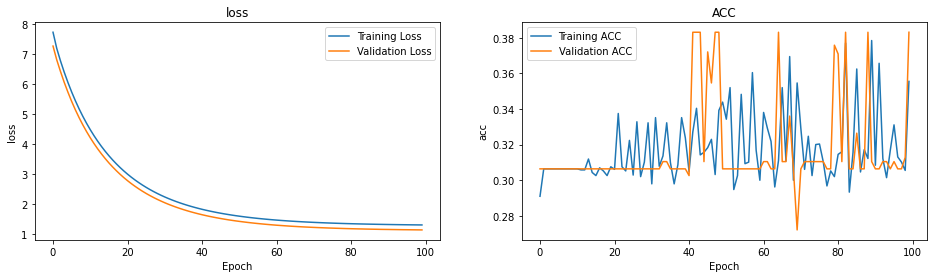

In [57]:
# We can also look at the optimisation history
train_loss = np.array(loss_tr)
valid_loss = np.array(loss_va)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=plt.figaspect(0.25))
ax1.plot(np.nanmean(train_loss,axis=0), label='Training Loss')
ax1.plot(np.nanmean(valid_loss,axis=0), label='Validation Loss')
ax1.set_title('loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(np.nanmean(metri_tr,axis=0), label='Training ACC')
ax2.plot(np.nanmean(metri_va,axis=0), label='Validation ACC')
ax2.set_title('ACC')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('acc')
ax2.legend()

In [ ]:
#importing a 3-class dataset from sklearn's toy dataset
from sklearn.datasets import load_wine

dataset = load_wine()
X = dataset.data
y = dataset.target
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(kernel='rbf', C=1).fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(X_train.shape,y_train.shape,y_pred.shape)

#importing confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))